In [1]:
from google.colab import drive
drive.mount('/content/drive')
%tensorflow_version 1.x
import tensorflow as tf
print(tf.__version__)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
TensorFlow 1.x selected.
1.15.2


In [2]:
import pandas as pd
import numpy as np
import datetime
import time
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
import math
import random

# read data from csv file and process X, y
def data_loader(data_path):
		# load raw data
		df = pd.read_csv(data_path)

		# clean data with missing values          
		'''drop the rows directly -> mess up the order
			first 24 rows have pm2.5 value that is NaN -> discard
			else: forward filling'''
		df = df[24:].fillna(method='ffill')

		# integrate 'year', 'month', 'day', 'hour', 'No' as one attribute
		df['time'] = df.apply(lambda x : datetime.datetime(year=x['year'], month=x['month'], day=x['day'], hour=x['hour']), axis=1)
		df.drop(columns=['year', 'month', 'day', 'hour', 'No'], inplace=True)
		df = df.set_index('time')

		# expand "cbwd" into 4 attributes 'SE', 'cv', 'NW', 'NE'
		df = df.join(pd.get_dummies(df['cbwd'])) # one-hot encoding
		del df['cbwd']

		# df = df.drop('cbwd', axis = 1) # remove the attribute temporarily

		X = df.iloc[:,1:].astype(np.float32)
		y = df['pm2.5'].astype(np.float32).to_frame()
	
		return X, y
  
# Z-score normalisation
def data_normalisation(train, test):
		X_train, y_train = train[0], train[1]
		X_test, y_test = test[0], test[1]

		mean_x, std_x = X_train.mean(axis=0), X_train.std(axis=0)
		mean_y, std_y = y_train.mean(axis=0), y_train.std(axis=0)
	
		# Use the mean & std of train. Since there's no way for us to know the future.
		# (X_train, y_train) = ((X_train-mean_x)/std_x, (y_train-mean_y)/std_y)
		# (X_val, y_val) = ((X_val-mean_x)/std_x, (y_val-mean_y)/std_y) 
		# (X_test, y_test) = ((X_test-mean_x)/std_x, (y_test-mean_y)/std_y)
		(X_train, y_train) = ((X_train-mean_x)/std_x, np.log(np.asarray(y_train) + 1))
		(X_test, y_test) = ((X_test-mean_x)/std_x, np.log(np.asarray(y_test) + 1))
		# (X_train, y_train) = ((X_train-mean_x)/std_x, y_train)
		# (X_val, y_val) = ((X_val-mean_x)/std_x, y_val) 
		# (X_test, y_test) = ((X_test-mean_x)/std_x, y_test)

		return (X_train, y_train),(X_test, y_test)

data_path = "/content/drive/My Drive/Colab Notebooks/PM2dot5.csv"
X, y = data_loader(data_path)

#X_data = X.values
#y_data = y.values
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.1, shuffle=True)

(X_train, y_train),(X_test, y_test) = data_normalisation((X_train, y_train),(X_test, y_test))

X_train.shape, y_train.shape, X_test.shape, y_test.shape
#X_data.shape, y_data.shape

((39420, 10), (39420, 1), (4380, 10), (4380, 1))

In [3]:
#Network parameters
n_input = 10 
n_hidden1, n_hidden2,n_hidden3 = 20, 10, 5
n_output = 1


#Defining the input and the output
X_p = tf.placeholder("float", [None, n_input], name='X_p') 
Y_p = tf.placeholder("float", [None, n_output], name='Y_p')

# forward
def multilayer_perceptron1(input_d):
    #DEFINING WEIGHTS AND BIASES
    b1 = tf.Variable(tf.random_normal([n_hidden1])) #Biases first hidden layer
    b2 = tf.Variable(tf.random_normal([n_output]))  #Biases output layer
    
    w1 = tf.Variable(tf.random_normal([n_input, n_hidden1]))   #Weights connecting input layer with first hidden layer
    w2 = tf.Variable(tf.random_normal([n_hidden1, n_output])) #Weights connecting first hidden layer with second hidden layer 

    layer_1 = tf.nn.leaky_relu(tf.add(tf.matmul(input_d, w1), b1), alpha=0.01) #Task of neurons of first hidden layer
    out_layer = tf.add(tf.matmul(layer_1, w2),b2)            #Task of neurons of output layer
    
    return out_layer
def multilayer_perceptron2(input_d):
#DEFINING WEIGHTS AND BIASES
    b1 = tf.Variable(tf.random_normal([n_hidden1])) #Biases first hidden layer
    b2 = tf.Variable(tf.random_normal([n_hidden2])) #Biases second hidden layer
    b3 = tf.Variable(tf.random_normal([n_output]))  #Biases output layer
    
    w1 = tf.Variable(tf.random_normal([n_input, n_hidden1]))   #Weights connecting input layer with first hidden layer
    w2 = tf.Variable(tf.random_normal([n_hidden1, n_hidden2])) #Weights connecting first hidden layer with second hidden layer 
    w3 = tf.Variable(tf.random_normal([n_hidden2, n_output]))

    layer_1 = tf.nn.leaky_relu(tf.add(tf.matmul(input_d, w1), b1), alpha=0.01) #Task of neurons of first hidden layer
    layer_2 = tf.nn.leaky_relu(tf.add(tf.matmul(layer_1, w2), b2), alpha=0.01) #Task of neurons of second hidden layer
    out_layer = tf.add(tf.matmul(layer_2, w3),b3)            #Task of neurons of output layer
    return out_layer
def multilayer_perceptron3(input_d):
#DEFINING WEIGHTS AND BIASES
    b1 = tf.Variable(tf.random_normal([n_hidden1])) #Biases first hidden layer
    b2 = tf.Variable(tf.random_normal([n_hidden2])) #Biases second hidden layer
    b3 = tf.Variable(tf.random_normal([n_hidden3])) #Biases third hidden layer
    b4 = tf.Variable(tf.random_normal([n_output]))  #Biases output layer
    
    w1 = tf.Variable(tf.random_normal([n_input, n_hidden1]))   #Weights connecting input layer with first hidden layer
    w2 = tf.Variable(tf.random_normal([n_hidden1, n_hidden2])) #Weights connecting first hidden layer with second hidden layer 
    w3 = tf.Variable(tf.random_normal([n_hidden2, n_hidden3])) #Weights connecting second hidden layer with third layer
    w4 = tf.Variable(tf.random_normal([n_hidden3, n_output]))  #Weights connecting third hidden layer with output layer


    layer_1 = tf.nn.leaky_relu(tf.add(tf.matmul(input_d, w1), b1), alpha=0.01) #Task of neurons of first hidden layer
    layer_2 = tf.nn.leaky_relu(tf.add(tf.matmul(layer_1, w2), b2), alpha=0.01) #Task of neurons of second hidden layer
    layer_3 = tf.nn.leaky_relu(tf.add(tf.matmul(layer_2, w3), b3), alpha=0.01) #Task of neurons of thrid layer
    out_layer = tf.add(tf.matmul(layer_3, w4),b4)            #Task of neurons of output layer
    return out_layer


Fold 1, lr: 5e-05, batch_size: 64, number_epochs: 2000, type_loss_func: MSE, type_optimizer: GradientDescent, neural_network_structure: multilayer_perceptron1
Epoch: 1000, Training loss: 4.8706465, Validation loss: 9.229349, 
Epoch: 2000, Training loss: 3.432844, Validation loss: 5.080734, 
The total training time is: 4.851103


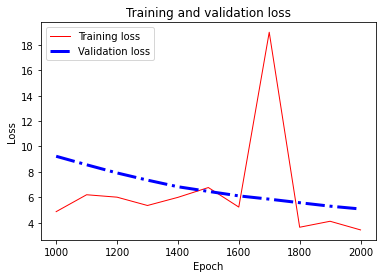

<Figure size 432x288 with 0 Axes>

Final Training loss: 3.432844, Final Validation loss: 5.080734, Training RMSE: 2.2971609, Validation RMSE: 2.2540483
-------------------------------------------------------------------------------------


Fold 2, lr: 5e-05, batch_size: 64, number_epochs: 2000, type_loss_func: MSE, type_optimizer: GradientDescent, neural_network_structure: multilayer_perceptron1
Epoch: 1000, Training loss: 5.3917723, Validation loss: 6.3145714, 
Epoch: 2000, Training loss: 2.6575165, Validation loss: 3.807359, 
The total training time is: 4.996449999999999


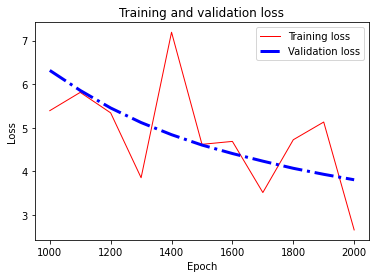

<Figure size 432x288 with 0 Axes>

Final Training loss: 2.6575165, Final Validation loss: 3.807359, Training RMSE: 1.909124, Validation RMSE: 1.9512455
-------------------------------------------------------------------------------------


Fold 3, lr: 5e-05, batch_size: 64, number_epochs: 2000, type_loss_func: MSE, type_optimizer: GradientDescent, neural_network_structure: multilayer_perceptron1
Epoch: 1000, Training loss: 5.4765387, Validation loss: 5.9034944, 
Epoch: 2000, Training loss: 2.5230184, Validation loss: 3.9519367, 
The total training time is: 5.022344


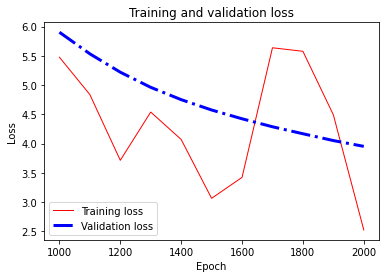

<Figure size 432x288 with 0 Axes>

Final Training loss: 2.5230184, Final Validation loss: 3.9519367, Training RMSE: 1.9449731, Validation RMSE: 1.9879478
-------------------------------------------------------------------------------------


Fold 4, lr: 5e-05, batch_size: 64, number_epochs: 2000, type_loss_func: MSE, type_optimizer: GradientDescent, neural_network_structure: multilayer_perceptron1
Epoch: 1000, Training loss: 5.5007205, Validation loss: 7.4443073, 
Epoch: 2000, Training loss: 4.1420465, Validation loss: 4.352775, 
The total training time is: 5.0083839999999995


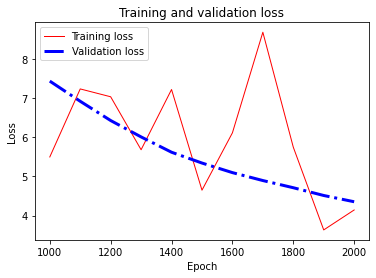

<Figure size 432x288 with 0 Axes>

Final Training loss: 4.1420465, Final Validation loss: 4.352775, Training RMSE: 2.0753374, Validation RMSE: 2.0863307
-------------------------------------------------------------------------------------


Fold 5, lr: 5e-05, batch_size: 64, number_epochs: 2000, type_loss_func: MSE, type_optimizer: GradientDescent, neural_network_structure: multilayer_perceptron1
Epoch: 1000, Training loss: 9.769217, Validation loss: 12.226966, 
Epoch: 2000, Training loss: 4.971863, Validation loss: 6.626789, 
The total training time is: 5.078576999999999


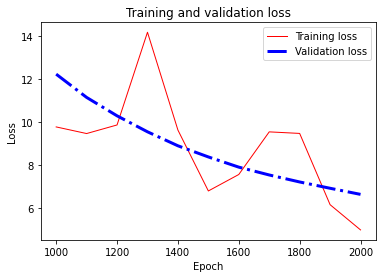

<Figure size 432x288 with 0 Axes>

Final Training loss: 4.971863, Final Validation loss: 6.626789, Training RMSE: 2.5532222, Validation RMSE: 2.574255
-------------------------------------------------------------------------------------


Fold 6, lr: 5e-05, batch_size: 64, number_epochs: 2000, type_loss_func: MSE, type_optimizer: GradientDescent, neural_network_structure: multilayer_perceptron1
Epoch: 1000, Training loss: 5.1300116, Validation loss: 5.880365, 
Epoch: 2000, Training loss: 2.516651, Validation loss: 3.1747088, 
The total training time is: 5.077935000000004


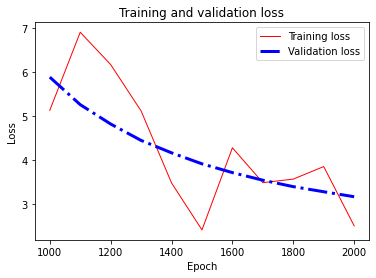

<Figure size 432x288 with 0 Axes>

Final Training loss: 2.516651, Final Validation loss: 3.1747088, Training RMSE: 1.7771318, Validation RMSE: 1.7817713
-------------------------------------------------------------------------------------


Fold 7, lr: 5e-05, batch_size: 64, number_epochs: 2000, type_loss_func: MSE, type_optimizer: GradientDescent, neural_network_structure: multilayer_perceptron1
Epoch: 1000, Training loss: 8.745616, Validation loss: 9.225601, 
Epoch: 2000, Training loss: 4.8076525, Validation loss: 6.132687, 
The total training time is: 4.782871


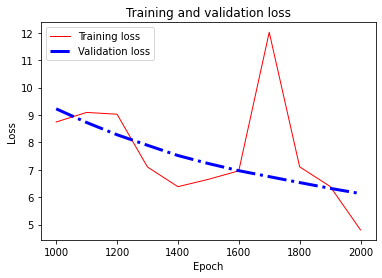

<Figure size 432x288 with 0 Axes>

Final Training loss: 4.8076525, Final Validation loss: 6.132687, Training RMSE: 2.48115, Validation RMSE: 2.4764264
-------------------------------------------------------------------------------------


Fold 8, lr: 5e-05, batch_size: 64, number_epochs: 2000, type_loss_func: MSE, type_optimizer: GradientDescent, neural_network_structure: multilayer_perceptron1
Epoch: 1000, Training loss: 5.5862384, Validation loss: 6.6589236, 
Epoch: 2000, Training loss: 2.8255153, Validation loss: 4.715134, 
The total training time is: 4.877471


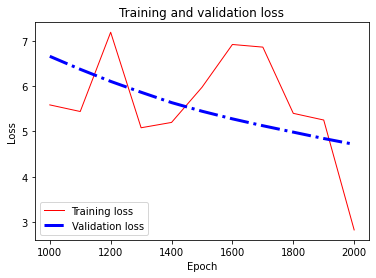

<Figure size 432x288 with 0 Axes>

Final Training loss: 2.8255153, Final Validation loss: 4.715134, Training RMSE: 2.1950269, Validation RMSE: 2.171436
-------------------------------------------------------------------------------------


Fold 9, lr: 5e-05, batch_size: 64, number_epochs: 2000, type_loss_func: MSE, type_optimizer: GradientDescent, neural_network_structure: multilayer_perceptron1
Epoch: 1000, Training loss: 14.764593, Validation loss: 11.437156, 
Epoch: 2000, Training loss: 5.7732124, Validation loss: 7.1987205, 
The total training time is: 5.249777999999999


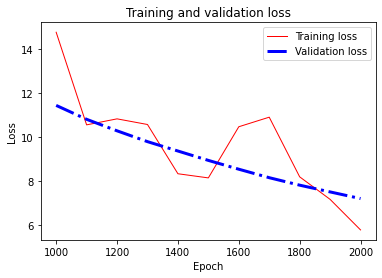

<Figure size 432x288 with 0 Axes>

Final Training loss: 5.7732124, Final Validation loss: 7.1987205, Training RMSE: 2.7438602, Validation RMSE: 2.6830432
-------------------------------------------------------------------------------------


Fold 10, lr: 5e-05, batch_size: 64, number_epochs: 2000, type_loss_func: MSE, type_optimizer: GradientDescent, neural_network_structure: multilayer_perceptron1
Epoch: 1000, Training loss: 3.3346548, Validation loss: 4.3966584, 
Epoch: 2000, Training loss: 2.3916264, Validation loss: 3.000858, 
The total training time is: 5.182636000000002


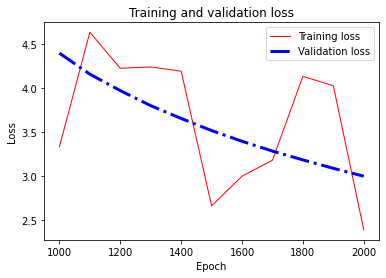

<Figure size 432x288 with 0 Axes>

Final Training loss: 2.3916264, Final Validation loss: 3.000858, Training RMSE: 1.732844, Validation RMSE: 1.7322985
-------------------------------------------------------------------------------------


For the model with learning rate: 5e-05, batch size: 64, number_epochs: 2000, type_optimizer: GradientDescent, neural_network_structure: multilayer_perceptron1 

Average Training RMSE for the 10 folds: 2.1709828 

Average Validation RMSE for the 10 folds: 2.1698802 


-------------------------------------------------------------------------------------


Fold 1, lr: 5e-05, batch_size: 64, number_epochs: 2000, type_loss_func: MSE, type_optimizer: GradientDescent, neural_network_structure: multilayer_perceptron2
Epoch: 1000, Training loss: 8.31469, Validation loss: 7.5487885, 
Epoch: 2000, Training loss: 2.6343498, Validation loss: 4.116173, 
The total training time is: 6.365327000000001


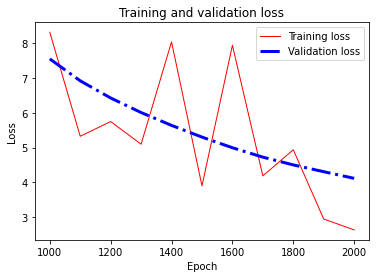

<Figure size 432x288 with 0 Axes>

Final Training loss: 2.6343498, Final Validation loss: 4.116173, Training RMSE: 2.0174317, Validation RMSE: 2.0288353
-------------------------------------------------------------------------------------


Fold 2, lr: 5e-05, batch_size: 64, number_epochs: 2000, type_loss_func: MSE, type_optimizer: GradientDescent, neural_network_structure: multilayer_perceptron2
Epoch: 1000, Training loss: 4.1332636, Validation loss: 5.3918514, 
Epoch: 2000, Training loss: 4.7169747, Validation loss: 3.620895, 
The total training time is: 6.27159300000001


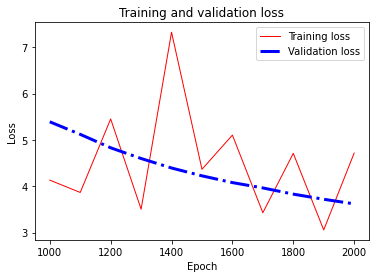

<Figure size 432x288 with 0 Axes>

Final Training loss: 4.7169747, Final Validation loss: 3.620895, Training RMSE: 1.9176298, Validation RMSE: 1.9028649
-------------------------------------------------------------------------------------


Fold 3, lr: 5e-05, batch_size: 64, number_epochs: 2000, type_loss_func: MSE, type_optimizer: GradientDescent, neural_network_structure: multilayer_perceptron2
Epoch: 1000, Training loss: 5.286961, Validation loss: 5.9924684, 
Epoch: 2000, Training loss: 3.9017487, Validation loss: 3.579693, 
The total training time is: 6.264604000000006


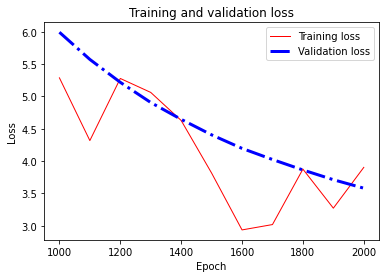

<Figure size 432x288 with 0 Axes>

Final Training loss: 3.9017487, Final Validation loss: 3.579693, Training RMSE: 1.920745, Validation RMSE: 1.8920077
-------------------------------------------------------------------------------------


Fold 4, lr: 5e-05, batch_size: 64, number_epochs: 2000, type_loss_func: MSE, type_optimizer: GradientDescent, neural_network_structure: multilayer_perceptron2
Epoch: 1000, Training loss: 5.1467333, Validation loss: 6.404613, 
Epoch: 2000, Training loss: 4.0071006, Validation loss: 3.5679038, 
The total training time is: 6.327156000000002


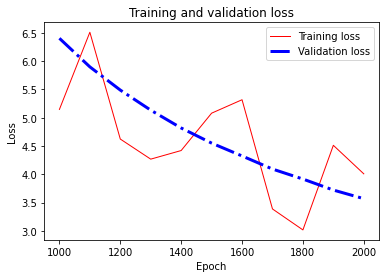

<Figure size 432x288 with 0 Axes>

Final Training loss: 4.0071006, Final Validation loss: 3.5679038, Training RMSE: 1.8549974, Validation RMSE: 1.8888896
-------------------------------------------------------------------------------------


Fold 5, lr: 5e-05, batch_size: 64, number_epochs: 2000, type_loss_func: MSE, type_optimizer: GradientDescent, neural_network_structure: multilayer_perceptron2
Epoch: 1000, Training loss: 4.4532747, Validation loss: 4.7134557, 
Epoch: 2000, Training loss: 2.1118853, Validation loss: 3.3147764, 
The total training time is: 6.352874


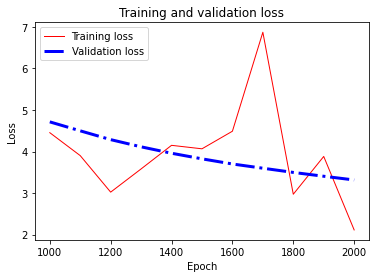

<Figure size 432x288 with 0 Axes>

Final Training loss: 2.1118853, Final Validation loss: 3.3147764, Training RMSE: 1.830098, Validation RMSE: 1.8206527
-------------------------------------------------------------------------------------


Fold 6, lr: 5e-05, batch_size: 64, number_epochs: 2000, type_loss_func: MSE, type_optimizer: GradientDescent, neural_network_structure: multilayer_perceptron2
Epoch: 1000, Training loss: 6.688466, Validation loss: 7.5060415, 
Epoch: 2000, Training loss: 3.6447716, Validation loss: 4.9656577, 
The total training time is: 6.349361999999999


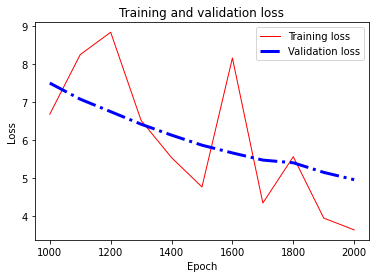

<Figure size 432x288 with 0 Axes>

Final Training loss: 3.6447716, Final Validation loss: 4.9656577, Training RMSE: 2.1729267, Validation RMSE: 2.2283757
-------------------------------------------------------------------------------------


Fold 7, lr: 5e-05, batch_size: 64, number_epochs: 2000, type_loss_func: MSE, type_optimizer: GradientDescent, neural_network_structure: multilayer_perceptron2
Epoch: 1000, Training loss: 3.306458, Validation loss: 3.3370624, 
Epoch: 2000, Training loss: 1.4719563, Validation loss: 2.0568151, 
The total training time is: 6.088616999999999


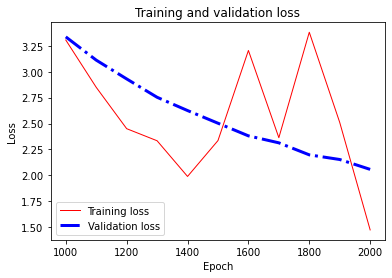

<Figure size 432x288 with 0 Axes>

Final Training loss: 1.4719563, Final Validation loss: 2.0568151, Training RMSE: 1.4790194, Validation RMSE: 1.4341601
-------------------------------------------------------------------------------------


Fold 8, lr: 5e-05, batch_size: 64, number_epochs: 2000, type_loss_func: MSE, type_optimizer: GradientDescent, neural_network_structure: multilayer_perceptron2
Epoch: 1000, Training loss: 5.167834, Validation loss: 4.6403527, 
Epoch: 2000, Training loss: 1.500165, Validation loss: 3.0993207, 
The total training time is: 7.0418670000000105


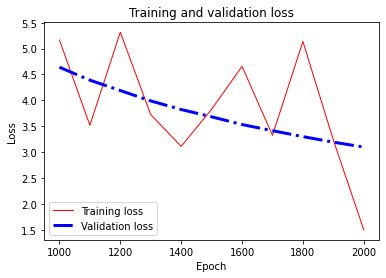

<Figure size 432x288 with 0 Axes>

Final Training loss: 1.500165, Final Validation loss: 3.0993207, Training RMSE: 1.7564498, Validation RMSE: 1.7604887
-------------------------------------------------------------------------------------


Fold 9, lr: 5e-05, batch_size: 64, number_epochs: 2000, type_loss_func: MSE, type_optimizer: GradientDescent, neural_network_structure: multilayer_perceptron2
Epoch: 1000, Training loss: 6.225005, Validation loss: 6.6446466, 
Epoch: 2000, Training loss: 2.6754084, Validation loss: 4.453051, 
The total training time is: 7.416610000000006


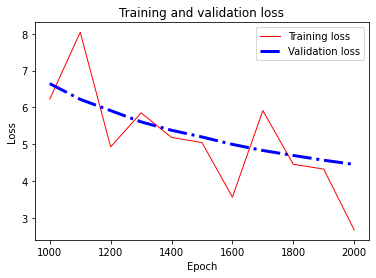

<Figure size 432x288 with 0 Axes>

Final Training loss: 2.6754084, Final Validation loss: 4.453051, Training RMSE: 2.1204038, Validation RMSE: 2.1102254
-------------------------------------------------------------------------------------


Fold 10, lr: 5e-05, batch_size: 64, number_epochs: 2000, type_loss_func: MSE, type_optimizer: GradientDescent, neural_network_structure: multilayer_perceptron2
Epoch: 1000, Training loss: 3.3851943, Validation loss: 4.566055, 
Epoch: 2000, Training loss: 2.4105484, Validation loss: 3.0770814, 
The total training time is: 6.426142000000013


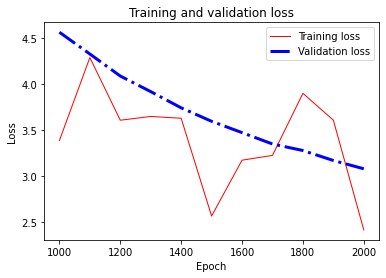

<Figure size 432x288 with 0 Axes>

Final Training loss: 2.4105484, Final Validation loss: 3.0770814, Training RMSE: 1.7821141, Validation RMSE: 1.7541611
-------------------------------------------------------------------------------------


For the model with learning rate: 5e-05, batch size: 64, number_epochs: 2000, type_optimizer: GradientDescent, neural_network_structure: multilayer_perceptron2 

Average Training RMSE for the 10 folds: 2.0280824 

Average Validation RMSE for the 10 folds: 2.025973 


-------------------------------------------------------------------------------------


Fold 1, lr: 5e-05, batch_size: 64, number_epochs: 2000, type_loss_func: MSE, type_optimizer: GradientDescent, neural_network_structure: multilayer_perceptron3
Epoch: 1000, Training loss: 4.480183, Validation loss: 6.081464, 
Epoch: 2000, Training loss: 2.9233027, Validation loss: 4.113904, 
The total training time is: 6.867435


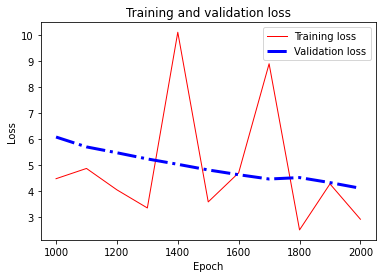

<Figure size 432x288 with 0 Axes>

Final Training loss: 2.9233027, Final Validation loss: 4.113904, Training RMSE: 2.038901, Validation RMSE: 2.0282762
-------------------------------------------------------------------------------------


Fold 2, lr: 5e-05, batch_size: 64, number_epochs: 2000, type_loss_func: MSE, type_optimizer: GradientDescent, neural_network_structure: multilayer_perceptron3
Epoch: 1000, Training loss: 3.2084954, Validation loss: 4.285525, 
Epoch: 2000, Training loss: 2.1893091, Validation loss: 3.1222115, 
The total training time is: 6.8657129999999995


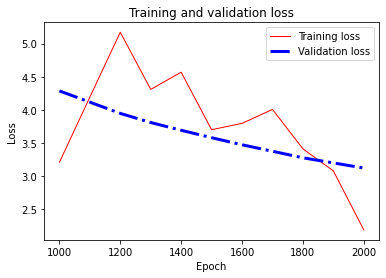

<Figure size 432x288 with 0 Axes>

Final Training loss: 2.1893091, Final Validation loss: 3.1222115, Training RMSE: 1.7894812, Validation RMSE: 1.766978
-------------------------------------------------------------------------------------


Fold 3, lr: 5e-05, batch_size: 64, number_epochs: 2000, type_loss_func: MSE, type_optimizer: GradientDescent, neural_network_structure: multilayer_perceptron3
Epoch: 1000, Training loss: 2.9950085, Validation loss: 4.866621, 
Epoch: 2000, Training loss: 2.4698424, Validation loss: 3.2725925, 
The total training time is: 7.132402000000013


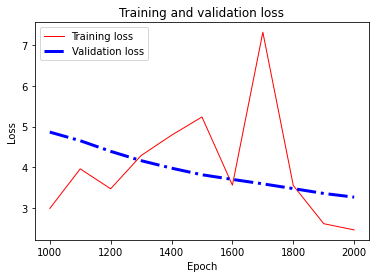

<Figure size 432x288 with 0 Axes>

Final Training loss: 2.4698424, Final Validation loss: 3.2725925, Training RMSE: 1.7840711, Validation RMSE: 1.8090308
-------------------------------------------------------------------------------------


Fold 4, lr: 5e-05, batch_size: 64, number_epochs: 2000, type_loss_func: MSE, type_optimizer: GradientDescent, neural_network_structure: multilayer_perceptron3
Epoch: 1000, Training loss: 4.152624, Validation loss: 6.0742726, 
Epoch: 2000, Training loss: 4.668642, Validation loss: 4.3661427, 
The total training time is: 7.1792859999999905


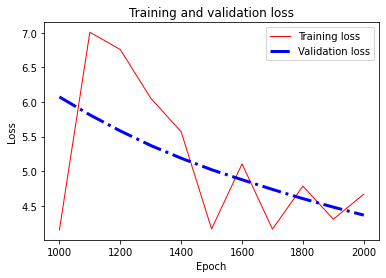

<Figure size 432x288 with 0 Axes>

Final Training loss: 4.668642, Final Validation loss: 4.3661427, Training RMSE: 2.1053302, Validation RMSE: 2.0895317
-------------------------------------------------------------------------------------


Fold 5, lr: 5e-05, batch_size: 64, number_epochs: 2000, type_loss_func: MSE, type_optimizer: GradientDescent, neural_network_structure: multilayer_perceptron3
Epoch: 1000, Training loss: 3.4375024, Validation loss: 3.7011242, 
Epoch: 2000, Training loss: 2.362607, Validation loss: 2.4349215, 
The total training time is: 6.625940999999983


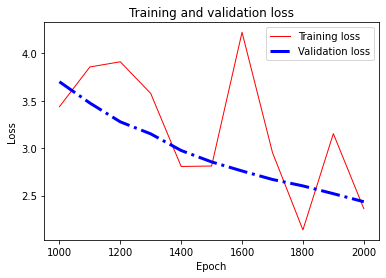

<Figure size 432x288 with 0 Axes>

Final Training loss: 2.362607, Final Validation loss: 2.4349215, Training RMSE: 1.5648346, Validation RMSE: 1.5604235
-------------------------------------------------------------------------------------


Fold 6, lr: 5e-05, batch_size: 64, number_epochs: 2000, type_loss_func: MSE, type_optimizer: GradientDescent, neural_network_structure: multilayer_perceptron3
Epoch: 1000, Training loss: 7.6807494, Validation loss: 9.056549, 
Epoch: 2000, Training loss: 5.7241545, Validation loss: 5.7019434, 
The total training time is: 7.021187999999995


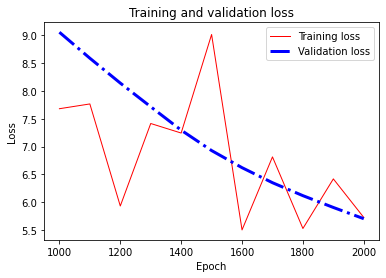

<Figure size 432x288 with 0 Axes>

Final Training loss: 5.7241545, Final Validation loss: 5.7019434, Training RMSE: 2.3526688, Validation RMSE: 2.3878741
-------------------------------------------------------------------------------------


Fold 7, lr: 5e-05, batch_size: 64, number_epochs: 2000, type_loss_func: MSE, type_optimizer: GradientDescent, neural_network_structure: multilayer_perceptron3
Epoch: 1000, Training loss: 6.28566, Validation loss: 7.397903, 
Epoch: 2000, Training loss: 6.0638075, Validation loss: 5.7917027, 
The total training time is: 7.128954999999991


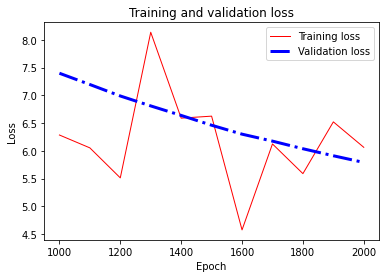

<Figure size 432x288 with 0 Axes>

Final Training loss: 6.0638075, Final Validation loss: 5.7917027, Training RMSE: 2.3875413, Validation RMSE: 2.4065957
-------------------------------------------------------------------------------------


Fold 8, lr: 5e-05, batch_size: 64, number_epochs: 2000, type_loss_func: MSE, type_optimizer: GradientDescent, neural_network_structure: multilayer_perceptron3
Epoch: 1000, Training loss: 5.310709, Validation loss: 6.399961, 
Epoch: 2000, Training loss: 3.379188, Validation loss: 4.709041, 
The total training time is: 6.995084999999989


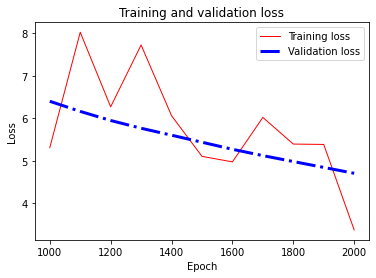

<Figure size 432x288 with 0 Axes>

Final Training loss: 3.379188, Final Validation loss: 4.709041, Training RMSE: 2.1742692, Validation RMSE: 2.1700325
-------------------------------------------------------------------------------------


Fold 9, lr: 5e-05, batch_size: 64, number_epochs: 2000, type_loss_func: MSE, type_optimizer: GradientDescent, neural_network_structure: multilayer_perceptron3
Epoch: 1000, Training loss: 2.5646994, Validation loss: 3.4709365, 
Epoch: 2000, Training loss: 2.2096353, Validation loss: 2.6648316, 
The total training time is: 6.7104870000000005


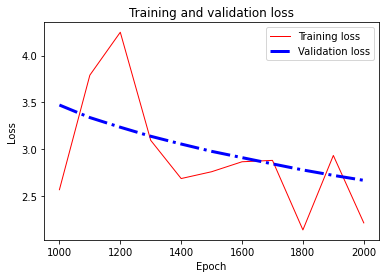

<Figure size 432x288 with 0 Axes>

Final Training loss: 2.2096353, Final Validation loss: 2.6648316, Training RMSE: 1.6261451, Validation RMSE: 1.6324311
-------------------------------------------------------------------------------------


Fold 10, lr: 5e-05, batch_size: 64, number_epochs: 2000, type_loss_func: MSE, type_optimizer: GradientDescent, neural_network_structure: multilayer_perceptron3
Epoch: 1000, Training loss: 7.750728, Validation loss: 8.909316, 
Epoch: 2000, Training loss: 4.21196, Validation loss: 5.6891923, 
The total training time is: 7.090865000000008


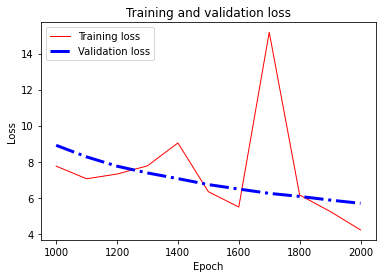

<Figure size 432x288 with 0 Axes>

Final Training loss: 4.21196, Final Validation loss: 5.6891923, Training RMSE: 2.381235, Validation RMSE: 2.385203
-------------------------------------------------------------------------------------


For the model with learning rate: 5e-05, batch size: 64, number_epochs: 2000, type_optimizer: GradientDescent, neural_network_structure: multilayer_perceptron3 

Average Training RMSE for the 10 folds: 2.0255375 

Average Validation RMSE for the 10 folds: 2.025195 


-------------------------------------------------------------------------------------


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Fold 1, lr: 5e-05, batch_size: 64, number_epochs: 2000, type_loss_func: MSE, type_optimizer: Adagrad, neural_network_structure: multilayer_perceptron1
Epoch: 1000, Training loss: 106.859985, Validation loss: 126.98235, 
Epoch: 2000, Training loss: 148.76137, Validation loss: 125.67602, 
The total training time is: 5.37930

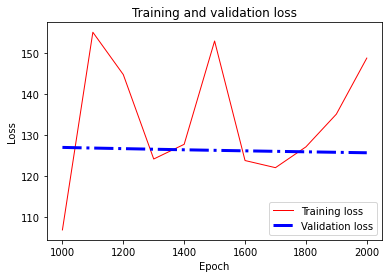

<Figure size 432x288 with 0 Axes>

Final Training loss: 148.76137, Final Validation loss: 125.67602, Training RMSE: 11.237634, Validation RMSE: 11.210531
-------------------------------------------------------------------------------------


Fold 2, lr: 5e-05, batch_size: 64, number_epochs: 2000, type_loss_func: MSE, type_optimizer: Adagrad, neural_network_structure: multilayer_perceptron1
Epoch: 1000, Training loss: 61.161842, Validation loss: 63.739105, 
Epoch: 2000, Training loss: 49.02404, Validation loss: 62.731194, 
The total training time is: 5.386773000000005


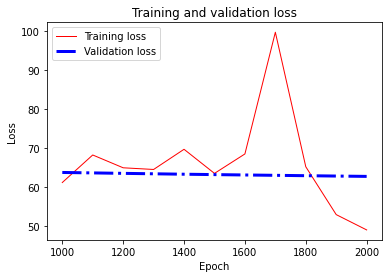

<Figure size 432x288 with 0 Axes>

Final Training loss: 49.02404, Final Validation loss: 62.731194, Training RMSE: 7.7737536, Validation RMSE: 7.9203024
-------------------------------------------------------------------------------------


Fold 3, lr: 5e-05, batch_size: 64, number_epochs: 2000, type_loss_func: MSE, type_optimizer: Adagrad, neural_network_structure: multilayer_perceptron1
Epoch: 1000, Training loss: 198.32053, Validation loss: 222.27606, 
Epoch: 2000, Training loss: 174.60442, Validation loss: 220.3068, 
The total training time is: 5.436554000000001


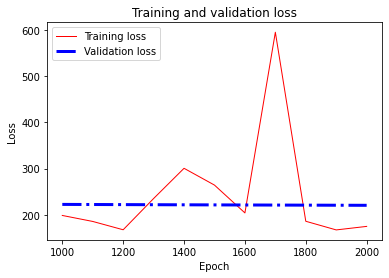

<Figure size 432x288 with 0 Axes>

Final Training loss: 174.60442, Final Validation loss: 220.3068, Training RMSE: 15.133735, Validation RMSE: 14.842735
-------------------------------------------------------------------------------------


Fold 4, lr: 5e-05, batch_size: 64, number_epochs: 2000, type_loss_func: MSE, type_optimizer: Adagrad, neural_network_structure: multilayer_perceptron1
Epoch: 1000, Training loss: 32.854267, Validation loss: 46.85284, 
Epoch: 2000, Training loss: 46.606606, Validation loss: 46.393875, 
The total training time is: 5.145686000000012


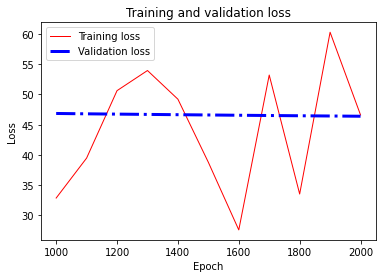

<Figure size 432x288 with 0 Axes>

Final Training loss: 46.606606, Final Validation loss: 46.393875, Training RMSE: 6.926548, Validation RMSE: 6.811305
-------------------------------------------------------------------------------------


Fold 5, lr: 5e-05, batch_size: 64, number_epochs: 2000, type_loss_func: MSE, type_optimizer: Adagrad, neural_network_structure: multilayer_perceptron1
Epoch: 1000, Training loss: 40.09516, Validation loss: 42.201042, 
Epoch: 2000, Training loss: 41.95439, Validation loss: 41.653133, 
The total training time is: 5.179104999999993


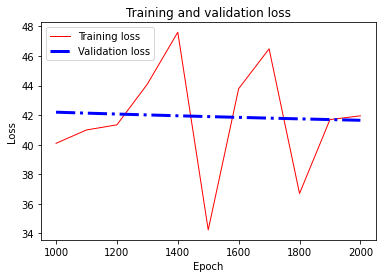

<Figure size 432x288 with 0 Axes>

Final Training loss: 41.95439, Final Validation loss: 41.653133, Training RMSE: 6.3609686, Validation RMSE: 6.4539237
-------------------------------------------------------------------------------------


Fold 6, lr: 5e-05, batch_size: 64, number_epochs: 2000, type_loss_func: MSE, type_optimizer: Adagrad, neural_network_structure: multilayer_perceptron1
Epoch: 1000, Training loss: 104.32974, Validation loss: 99.158134, 
Epoch: 2000, Training loss: 70.12123, Validation loss: 98.14206, 
The total training time is: 5.190327999999994


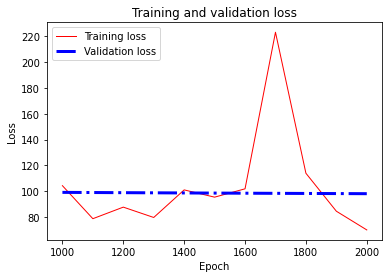

<Figure size 432x288 with 0 Axes>

Final Training loss: 70.12123, Final Validation loss: 98.14206, Training RMSE: 9.899975, Validation RMSE: 9.906668
-------------------------------------------------------------------------------------


Fold 7, lr: 5e-05, batch_size: 64, number_epochs: 2000, type_loss_func: MSE, type_optimizer: Adagrad, neural_network_structure: multilayer_perceptron1
Epoch: 1000, Training loss: 93.69226, Validation loss: 112.23896, 
Epoch: 2000, Training loss: 70.17185, Validation loss: 111.304855, 
The total training time is: 5.585602999999992


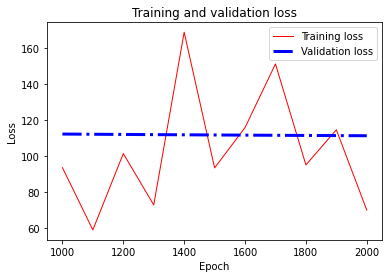

<Figure size 432x288 with 0 Axes>

Final Training loss: 70.17185, Final Validation loss: 111.304855, Training RMSE: 10.711717, Validation RMSE: 10.550112
-------------------------------------------------------------------------------------


Fold 8, lr: 5e-05, batch_size: 64, number_epochs: 2000, type_loss_func: MSE, type_optimizer: Adagrad, neural_network_structure: multilayer_perceptron1
Epoch: 1000, Training loss: 33.93663, Validation loss: 49.667236, 
Epoch: 2000, Training loss: 43.999138, Validation loss: 49.18155, 
The total training time is: 5.569163000000003


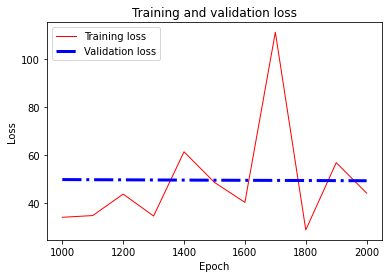

<Figure size 432x288 with 0 Axes>

Final Training loss: 43.999138, Final Validation loss: 49.18155, Training RMSE: 7.014575, Validation RMSE: 7.0129557
-------------------------------------------------------------------------------------


Fold 9, lr: 5e-05, batch_size: 64, number_epochs: 2000, type_loss_func: MSE, type_optimizer: Adagrad, neural_network_structure: multilayer_perceptron1
Epoch: 1000, Training loss: 19.997736, Validation loss: 20.504318, 
Epoch: 2000, Training loss: 14.091082, Validation loss: 20.21739, 
The total training time is: 5.238470999999947


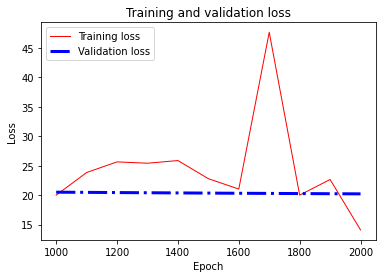

<Figure size 432x288 with 0 Axes>

Final Training loss: 14.091082, Final Validation loss: 20.21739, Training RMSE: 4.761258, Validation RMSE: 4.496375
-------------------------------------------------------------------------------------


Fold 10, lr: 5e-05, batch_size: 64, number_epochs: 2000, type_loss_func: MSE, type_optimizer: Adagrad, neural_network_structure: multilayer_perceptron1
Epoch: 1000, Training loss: 149.70227, Validation loss: 129.03772, 
Epoch: 2000, Training loss: 111.923775, Validation loss: 127.82373, 
The total training time is: 5.16964200000001


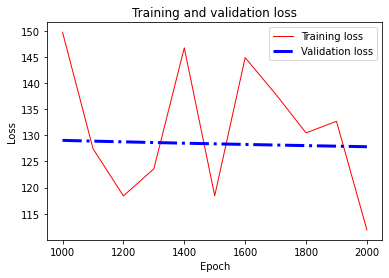

<Figure size 432x288 with 0 Axes>

Final Training loss: 111.923775, Final Validation loss: 127.82373, Training RMSE: 11.341336, Validation RMSE: 11.305916
-------------------------------------------------------------------------------------


For the model with learning rate: 5e-05, batch size: 64, number_epochs: 2000, type_optimizer: Adagrad, neural_network_structure: multilayer_perceptron1 

Average Training RMSE for the 10 folds: 3.7981906 

Average Validation RMSE for the 10 folds: 3.7816665 


-------------------------------------------------------------------------------------


Fold 1, lr: 5e-05, batch_size: 64, number_epochs: 2000, type_loss_func: MSE, type_optimizer: Adagrad, neural_network_structure: multilayer_perceptron2
Epoch: 1000, Training loss: 1920.5454, Validation loss: 2154.1335, 
Epoch: 2000, Training loss: 2004.9956, Validation loss: 2121.6091, 
The total training time is: 6.655710999999997


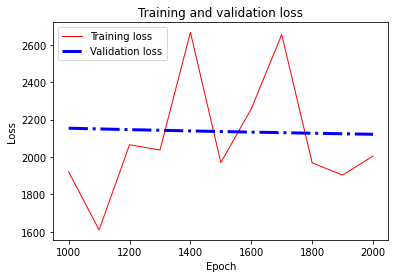

<Figure size 432x288 with 0 Axes>

Final Training loss: 2004.9956, Final Validation loss: 2121.6091, Training RMSE: 46.493153, Validation RMSE: 46.06093
-------------------------------------------------------------------------------------


Fold 2, lr: 5e-05, batch_size: 64, number_epochs: 2000, type_loss_func: MSE, type_optimizer: Adagrad, neural_network_structure: multilayer_perceptron2
Epoch: 1000, Training loss: 167.98108, Validation loss: 182.19649, 
Epoch: 2000, Training loss: 202.9025, Validation loss: 178.05733, 
The total training time is: 6.5960660000000075


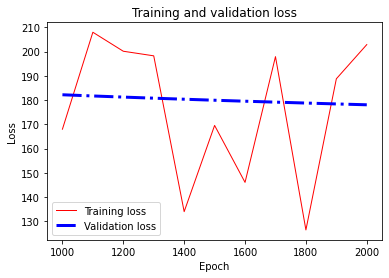

<Figure size 432x288 with 0 Axes>

Final Training loss: 202.9025, Final Validation loss: 178.05733, Training RMSE: 13.445598, Validation RMSE: 13.343812
-------------------------------------------------------------------------------------


Fold 3, lr: 5e-05, batch_size: 64, number_epochs: 2000, type_loss_func: MSE, type_optimizer: Adagrad, neural_network_structure: multilayer_perceptron2
Epoch: 1000, Training loss: 279.25436, Validation loss: 266.3185, 
Epoch: 2000, Training loss: 189.75989, Validation loss: 261.07568, 
The total training time is: 6.7148710000000165


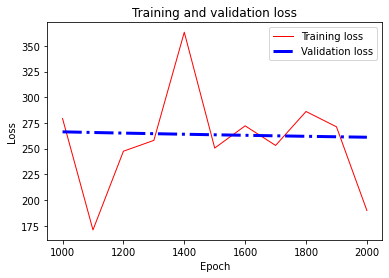

<Figure size 432x288 with 0 Axes>

Final Training loss: 189.75989, Final Validation loss: 261.07568, Training RMSE: 16.337042, Validation RMSE: 16.157837
-------------------------------------------------------------------------------------


Fold 4, lr: 5e-05, batch_size: 64, number_epochs: 2000, type_loss_func: MSE, type_optimizer: Adagrad, neural_network_structure: multilayer_perceptron2
Epoch: 1000, Training loss: 308.36172, Validation loss: 252.09665, 
Epoch: 2000, Training loss: 255.24153, Validation loss: 247.70822, 
The total training time is: 6.656344000000047


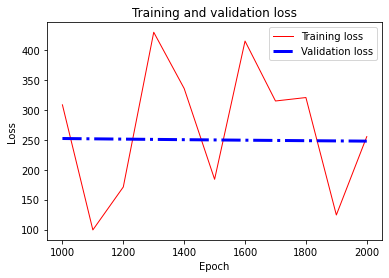

<Figure size 432x288 with 0 Axes>

Final Training loss: 255.24153, Final Validation loss: 247.70822, Training RMSE: 15.433633, Validation RMSE: 15.7387495
-------------------------------------------------------------------------------------


Fold 5, lr: 5e-05, batch_size: 64, number_epochs: 2000, type_loss_func: MSE, type_optimizer: Adagrad, neural_network_structure: multilayer_perceptron2
Epoch: 1000, Training loss: 290.8813, Validation loss: 371.06808, 
Epoch: 2000, Training loss: 339.24396, Validation loss: 364.2355, 
The total training time is: 6.644299999999987


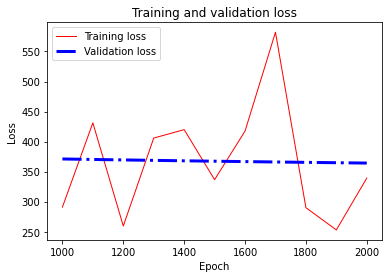

<Figure size 432x288 with 0 Axes>

Final Training loss: 339.24396, Final Validation loss: 364.2355, Training RMSE: 18.407248, Validation RMSE: 19.084955
-------------------------------------------------------------------------------------


Fold 6, lr: 5e-05, batch_size: 64, number_epochs: 2000, type_loss_func: MSE, type_optimizer: Adagrad, neural_network_structure: multilayer_perceptron2
Epoch: 1000, Training loss: 226.85916, Validation loss: 255.57716, 
Epoch: 2000, Training loss: 165.83365, Validation loss: 250.89458, 
The total training time is: 6.814897999999971


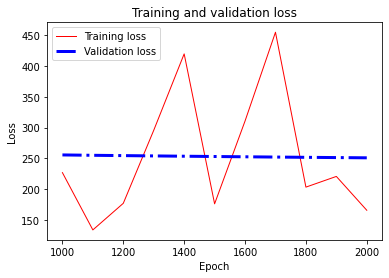

<Figure size 432x288 with 0 Axes>

Final Training loss: 165.83365, Final Validation loss: 250.89458, Training RMSE: 16.195187, Validation RMSE: 15.839652
-------------------------------------------------------------------------------------


Fold 7, lr: 5e-05, batch_size: 64, number_epochs: 2000, type_loss_func: MSE, type_optimizer: Adagrad, neural_network_structure: multilayer_perceptron2
Epoch: 1000, Training loss: 637.0166, Validation loss: 667.92786, 
Epoch: 2000, Training loss: 577.9312, Validation loss: 653.86084, 
The total training time is: 6.810788000000002


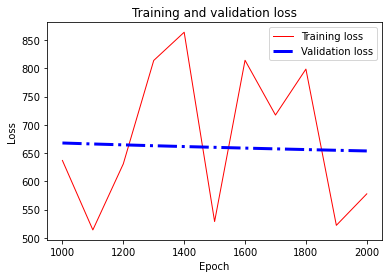

<Figure size 432x288 with 0 Axes>

Final Training loss: 577.9312, Final Validation loss: 653.86084, Training RMSE: 25.42468, Validation RMSE: 25.570704
-------------------------------------------------------------------------------------


Fold 8, lr: 5e-05, batch_size: 64, number_epochs: 2000, type_loss_func: MSE, type_optimizer: Adagrad, neural_network_structure: multilayer_perceptron2
Epoch: 1000, Training loss: 252.27379, Validation loss: 232.70258, 
Epoch: 2000, Training loss: 137.02145, Validation loss: 228.2996, 
The total training time is: 6.732303000000002


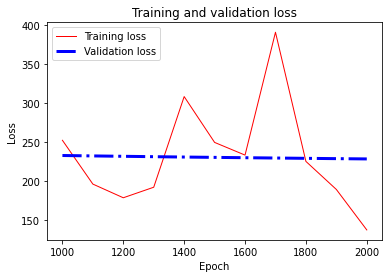

<Figure size 432x288 with 0 Axes>

Final Training loss: 137.02145, Final Validation loss: 228.2996, Training RMSE: 15.015737, Validation RMSE: 15.109587
-------------------------------------------------------------------------------------


Fold 9, lr: 5e-05, batch_size: 64, number_epochs: 2000, type_loss_func: MSE, type_optimizer: Adagrad, neural_network_structure: multilayer_perceptron2
Epoch: 1000, Training loss: 476.12216, Validation loss: 484.92902, 
Epoch: 2000, Training loss: 476.29657, Validation loss: 470.61725, 
The total training time is: 6.892898000000002


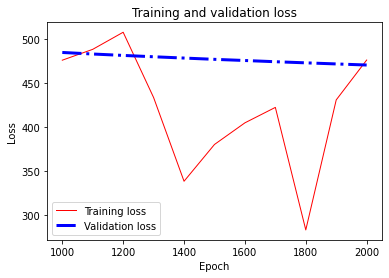

<Figure size 432x288 with 0 Axes>

Final Training loss: 476.29657, Final Validation loss: 470.61725, Training RMSE: 21.120228, Validation RMSE: 21.693714
-------------------------------------------------------------------------------------


Fold 10, lr: 5e-05, batch_size: 64, number_epochs: 2000, type_loss_func: MSE, type_optimizer: Adagrad, neural_network_structure: multilayer_perceptron2
Epoch: 1000, Training loss: 107.86266, Validation loss: 121.11389, 
Epoch: 2000, Training loss: 156.45947, Validation loss: 117.168915, 
The total training time is: 6.685946999999999


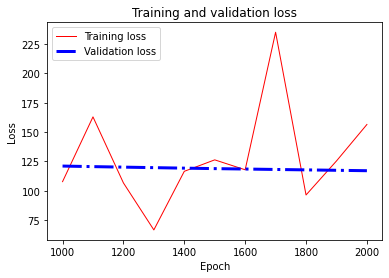

<Figure size 432x288 with 0 Axes>

Final Training loss: 156.45947, Final Validation loss: 117.168915, Training RMSE: 11.056033, Validation RMSE: 10.824459
-------------------------------------------------------------------------------------


For the model with learning rate: 5e-05, batch size: 64, number_epochs: 2000, type_optimizer: Adagrad, neural_network_structure: multilayer_perceptron2 

Average Training RMSE for the 10 folds: 7.017123 

Average Validation RMSE for the 10 folds: 7.013822 


-------------------------------------------------------------------------------------


Fold 1, lr: 5e-05, batch_size: 64, number_epochs: 2000, type_loss_func: MSE, type_optimizer: Adagrad, neural_network_structure: multilayer_perceptron3
Epoch: 1000, Training loss: 162.25775, Validation loss: 511.3229, 
Epoch: 2000, Training loss: 540.8096, Validation loss: 492.48236, 
The total training time is: 7.84537499999999


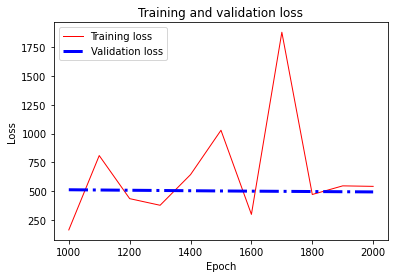

<Figure size 432x288 with 0 Axes>

Final Training loss: 540.8096, Final Validation loss: 492.48236, Training RMSE: 23.215897, Validation RMSE: 22.191944
-------------------------------------------------------------------------------------


Fold 2, lr: 5e-05, batch_size: 64, number_epochs: 2000, type_loss_func: MSE, type_optimizer: Adagrad, neural_network_structure: multilayer_perceptron3
Epoch: 1000, Training loss: 1015.0602, Validation loss: 1081.1887, 
Epoch: 2000, Training loss: 782.88904, Validation loss: 1062.7863, 
The total training time is: 8.288521000000003


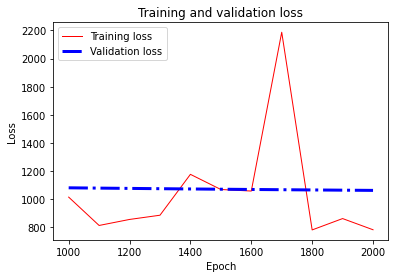

<Figure size 432x288 with 0 Axes>

Final Training loss: 782.88904, Final Validation loss: 1062.7863, Training RMSE: 32.294537, Validation RMSE: 32.600403
-------------------------------------------------------------------------------------


Fold 3, lr: 5e-05, batch_size: 64, number_epochs: 2000, type_loss_func: MSE, type_optimizer: Adagrad, neural_network_structure: multilayer_perceptron3
Epoch: 1000, Training loss: 83.312035, Validation loss: 113.21461, 
Epoch: 2000, Training loss: 63.900402, Validation loss: 108.68214, 
The total training time is: 7.774475999999993


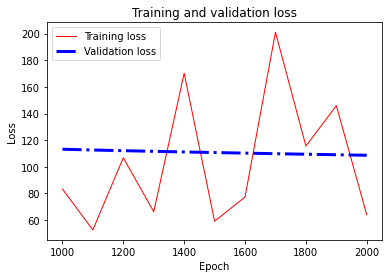

<Figure size 432x288 with 0 Axes>

Final Training loss: 63.900402, Final Validation loss: 108.68214, Training RMSE: 10.652763, Validation RMSE: 10.425073
-------------------------------------------------------------------------------------


Fold 4, lr: 5e-05, batch_size: 64, number_epochs: 2000, type_loss_func: MSE, type_optimizer: Adagrad, neural_network_structure: multilayer_perceptron3
Epoch: 1000, Training loss: 3749.3267, Validation loss: 3753.5393, 
Epoch: 2000, Training loss: 3607.004, Validation loss: 3670.8042, 
The total training time is: 7.52276599999999


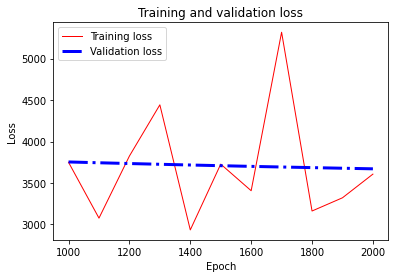

<Figure size 432x288 with 0 Axes>

Final Training loss: 3607.004, Final Validation loss: 3670.8042, Training RMSE: 60.67387, Validation RMSE: 60.587162
-------------------------------------------------------------------------------------


Fold 5, lr: 5e-05, batch_size: 64, number_epochs: 2000, type_loss_func: MSE, type_optimizer: Adagrad, neural_network_structure: multilayer_perceptron3
Epoch: 1000, Training loss: 423.3971, Validation loss: 448.64496, 
Epoch: 2000, Training loss: 503.3669, Validation loss: 436.60684, 
The total training time is: 7.44557199999997


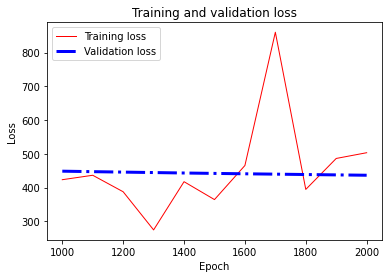

<Figure size 432x288 with 0 Axes>

Final Training loss: 503.3669, Final Validation loss: 436.60684, Training RMSE: 20.63384, Validation RMSE: 20.89514
-------------------------------------------------------------------------------------


Fold 6, lr: 5e-05, batch_size: 64, number_epochs: 2000, type_loss_func: MSE, type_optimizer: Adagrad, neural_network_structure: multilayer_perceptron3
Epoch: 1000, Training loss: 408.26782, Validation loss: 492.45132, 
Epoch: 2000, Training loss: 313.60114, Validation loss: 475.44934, 
The total training time is: 7.074726999999996


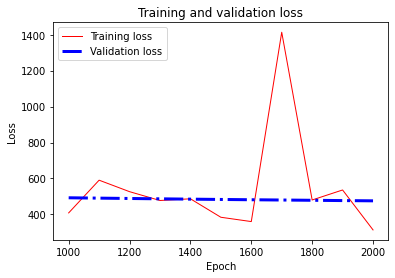

<Figure size 432x288 with 0 Axes>

Final Training loss: 313.60114, Final Validation loss: 475.44934, Training RMSE: 22.144093, Validation RMSE: 21.8048
-------------------------------------------------------------------------------------


Fold 7, lr: 5e-05, batch_size: 64, number_epochs: 2000, type_loss_func: MSE, type_optimizer: Adagrad, neural_network_structure: multilayer_perceptron3
Epoch: 1000, Training loss: 1401.823, Validation loss: 3015.3972, 
Epoch: 2000, Training loss: 1348.2522, Validation loss: 2963.3064, 
The total training time is: 7.075939000000005


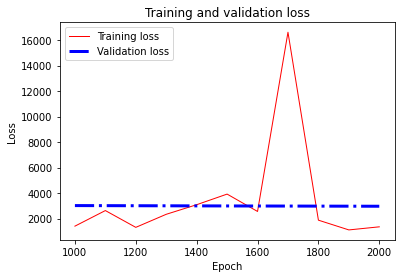

<Figure size 432x288 with 0 Axes>

Final Training loss: 1348.2522, Final Validation loss: 2963.3064, Training RMSE: 53.567314, Validation RMSE: 54.43626
-------------------------------------------------------------------------------------


Fold 8, lr: 5e-05, batch_size: 64, number_epochs: 2000, type_loss_func: MSE, type_optimizer: Adagrad, neural_network_structure: multilayer_perceptron3
Epoch: 1000, Training loss: 1139.0942, Validation loss: 1199.0767, 
Epoch: 2000, Training loss: 1268.5474, Validation loss: 1160.4026, 
The total training time is: 7.175923000000012


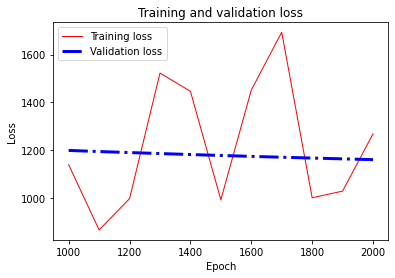

<Figure size 432x288 with 0 Axes>

Final Training loss: 1268.5474, Final Validation loss: 1160.4026, Training RMSE: 33.804157, Validation RMSE: 34.064682
-------------------------------------------------------------------------------------


Fold 9, lr: 5e-05, batch_size: 64, number_epochs: 2000, type_loss_func: MSE, type_optimizer: Adagrad, neural_network_structure: multilayer_perceptron3
Epoch: 1000, Training loss: 54.10983, Validation loss: 48.600433, 
Epoch: 2000, Training loss: 43.55565, Validation loss: 47.14543, 
The total training time is: 7.515713000000005


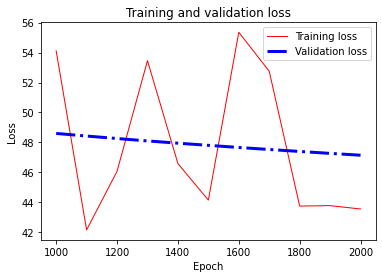

<Figure size 432x288 with 0 Axes>

Final Training loss: 43.55565, Final Validation loss: 47.14543, Training RMSE: 6.9598813, Validation RMSE: 6.866253
-------------------------------------------------------------------------------------


Fold 10, lr: 5e-05, batch_size: 64, number_epochs: 2000, type_loss_func: MSE, type_optimizer: Adagrad, neural_network_structure: multilayer_perceptron3
Epoch: 1000, Training loss: 260.91733, Validation loss: 216.82903, 
Epoch: 2000, Training loss: 229.2904, Validation loss: 209.5393, 
The total training time is: 7.256465999999989


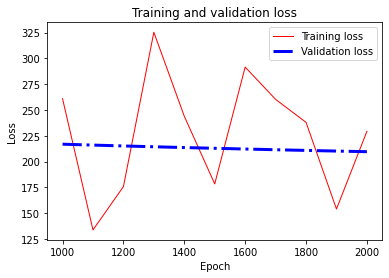

<Figure size 432x288 with 0 Axes>

Final Training loss: 229.2904, Final Validation loss: 209.5393, Training RMSE: 14.519568, Validation RMSE: 14.475472
-------------------------------------------------------------------------------------


For the model with learning rate: 5e-05, batch size: 64, number_epochs: 2000, type_optimizer: Adagrad, neural_network_structure: multilayer_perceptron3 

Average Training RMSE for the 10 folds: 10.488703 

Average Validation RMSE for the 10 folds: 10.483972 


-------------------------------------------------------------------------------------


Fold 1, lr: 5e-05, batch_size: 64, number_epochs: 2000, type_loss_func: MAE, type_optimizer: GradientDescent, neural_network_structure: multilayer_perceptron1
Epoch: 1000, Training loss: 4.800208, Validation loss: 4.7900257, 
Epoch: 2000, Training loss: 3.841545, Validation loss: 3.9885864, 
The total training time is: 5.811281000000008


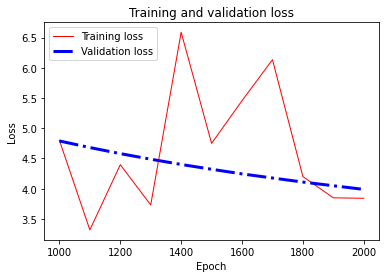

<Figure size 432x288 with 0 Axes>

Final Training loss: 3.841545, Final Validation loss: 3.9885864, Training RMSE: 8.362413, Validation RMSE: 7.877132
-------------------------------------------------------------------------------------


Fold 2, lr: 5e-05, batch_size: 64, number_epochs: 2000, type_loss_func: MAE, type_optimizer: GradientDescent, neural_network_structure: multilayer_perceptron1
Epoch: 1000, Training loss: 6.6452684, Validation loss: 6.1932592, 
Epoch: 2000, Training loss: 4.877988, Validation loss: 5.359726, 
The total training time is: 5.549210000000016


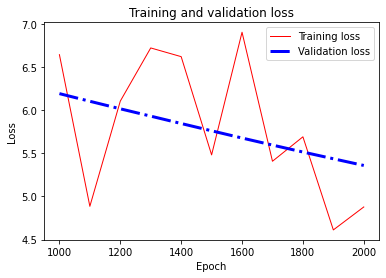

<Figure size 432x288 with 0 Axes>

Final Training loss: 4.877988, Final Validation loss: 5.359726, Training RMSE: 7.3450217, Validation RMSE: 7.3314614
-------------------------------------------------------------------------------------


Fold 3, lr: 5e-05, batch_size: 64, number_epochs: 2000, type_loss_func: MAE, type_optimizer: GradientDescent, neural_network_structure: multilayer_perceptron1
Epoch: 1000, Training loss: 6.6612077, Validation loss: 6.66467, 
Epoch: 2000, Training loss: 5.4966445, Validation loss: 5.7227407, 
The total training time is: 5.775471999999979


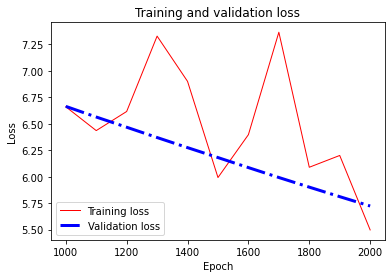

<Figure size 432x288 with 0 Axes>

Final Training loss: 5.4966445, Final Validation loss: 5.7227407, Training RMSE: 7.1978087, Validation RMSE: 7.077405
-------------------------------------------------------------------------------------


Fold 4, lr: 5e-05, batch_size: 64, number_epochs: 2000, type_loss_func: MAE, type_optimizer: GradientDescent, neural_network_structure: multilayer_perceptron1
Epoch: 1000, Training loss: 3.436228, Validation loss: 4.0409575, 
Epoch: 2000, Training loss: 3.6176884, Validation loss: 3.6622407, 
The total training time is: 5.36818599999998


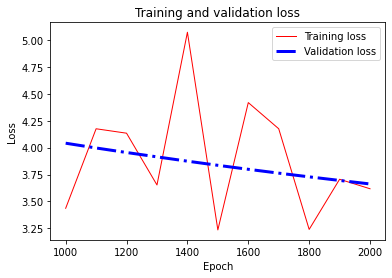

<Figure size 432x288 with 0 Axes>

Final Training loss: 3.6176884, Final Validation loss: 3.6622407, Training RMSE: 6.7333126, Validation RMSE: 6.7569475
-------------------------------------------------------------------------------------


Fold 5, lr: 5e-05, batch_size: 64, number_epochs: 2000, type_loss_func: MAE, type_optimizer: GradientDescent, neural_network_structure: multilayer_perceptron1
Epoch: 1000, Training loss: 4.955653, Validation loss: 5.451386, 
Epoch: 2000, Training loss: 4.976513, Validation loss: 4.8888474, 
The total training time is: 6.429469999999981


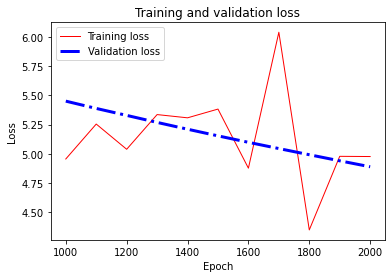

<Figure size 432x288 with 0 Axes>

Final Training loss: 4.976513, Final Validation loss: 4.8888474, Training RMSE: 7.3049603, Validation RMSE: 7.771277
-------------------------------------------------------------------------------------


Fold 6, lr: 5e-05, batch_size: 64, number_epochs: 2000, type_loss_func: MAE, type_optimizer: GradientDescent, neural_network_structure: multilayer_perceptron1
Epoch: 1000, Training loss: 6.239596, Validation loss: 6.4897594, 
Epoch: 2000, Training loss: 4.3490562, Validation loss: 5.2113085, 
The total training time is: 5.723343


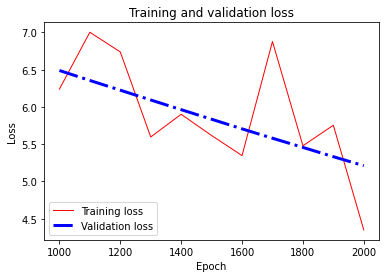

<Figure size 432x288 with 0 Axes>

Final Training loss: 4.3490562, Final Validation loss: 5.2113085, Training RMSE: 7.4322457, Validation RMSE: 7.279021
-------------------------------------------------------------------------------------


Fold 7, lr: 5e-05, batch_size: 64, number_epochs: 2000, type_loss_func: MAE, type_optimizer: GradientDescent, neural_network_structure: multilayer_perceptron1
Epoch: 1000, Training loss: 8.573542, Validation loss: 8.047494, 
Epoch: 2000, Training loss: 6.5664167, Validation loss: 6.6545753, 
The total training time is: 5.73651899999993


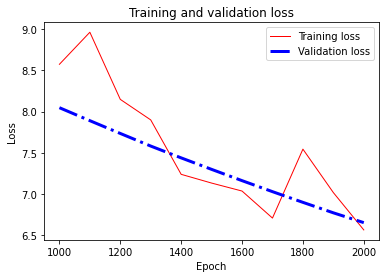

<Figure size 432x288 with 0 Axes>

Final Training loss: 6.5664167, Final Validation loss: 6.6545753, Training RMSE: 8.617416, Validation RMSE: 8.53955
-------------------------------------------------------------------------------------


Fold 8, lr: 5e-05, batch_size: 64, number_epochs: 2000, type_loss_func: MAE, type_optimizer: GradientDescent, neural_network_structure: multilayer_perceptron1
Epoch: 1000, Training loss: 7.194515, Validation loss: 7.636044, 
Epoch: 2000, Training loss: 6.2856293, Validation loss: 6.805619, 
The total training time is: 5.824872000000028


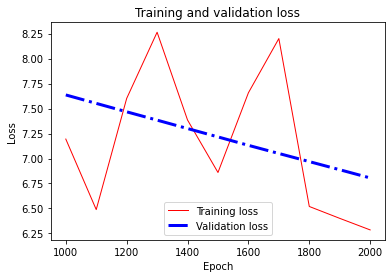

<Figure size 432x288 with 0 Axes>

Final Training loss: 6.2856293, Final Validation loss: 6.805619, Training RMSE: 8.6479025, Validation RMSE: 8.756779
-------------------------------------------------------------------------------------


Fold 9, lr: 5e-05, batch_size: 64, number_epochs: 2000, type_loss_func: MAE, type_optimizer: GradientDescent, neural_network_structure: multilayer_perceptron1
Epoch: 1000, Training loss: 5.1864147, Validation loss: 5.23231, 
Epoch: 2000, Training loss: 4.360587, Validation loss: 4.8577394, 
The total training time is: 5.788858000000005


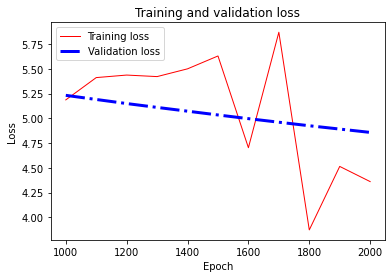

<Figure size 432x288 with 0 Axes>

Final Training loss: 4.360587, Final Validation loss: 4.8577394, Training RMSE: 7.3018737, Validation RMSE: 6.9673014
-------------------------------------------------------------------------------------


Fold 10, lr: 5e-05, batch_size: 64, number_epochs: 2000, type_loss_func: MAE, type_optimizer: GradientDescent, neural_network_structure: multilayer_perceptron1
Epoch: 1000, Training loss: 5.5542006, Validation loss: 5.2413545, 
Epoch: 2000, Training loss: 3.38671, Validation loss: 4.1401844, 
The total training time is: 5.5534580000000915


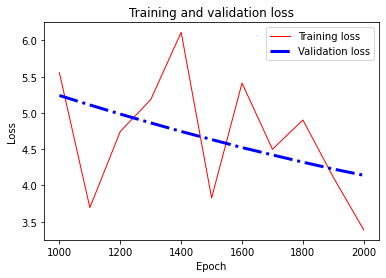

<Figure size 432x288 with 0 Axes>

Final Training loss: 3.38671, Final Validation loss: 4.1401844, Training RMSE: 6.525033, Validation RMSE: 6.4967937
-------------------------------------------------------------------------------------


For the model with learning rate: 5e-05, batch size: 64, number_epochs: 2000, type_optimizer: GradientDescent, neural_network_structure: multilayer_perceptron1 

Average Training RMSE for the 10 folds: 10.068429 

Average Validation RMSE for the 10 folds: 10.055598 


-------------------------------------------------------------------------------------


Fold 1, lr: 5e-05, batch_size: 64, number_epochs: 2000, type_loss_func: MAE, type_optimizer: GradientDescent, neural_network_structure: multilayer_perceptron2
Epoch: 1000, Training loss: 4.459509, Validation loss: 4.5677447, 
Epoch: 2000, Training loss: 3.1640344, Validation loss: 3.6569567, 
The total training time is: 7.2383519999999635


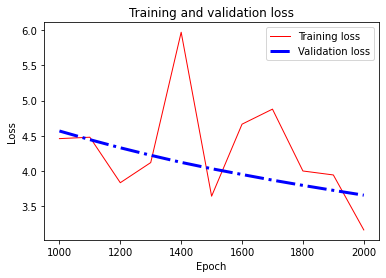

<Figure size 432x288 with 0 Axes>

Final Training loss: 3.1640344, Final Validation loss: 3.6569567, Training RMSE: 6.6027656, Validation RMSE: 6.238307
-------------------------------------------------------------------------------------


Fold 2, lr: 5e-05, batch_size: 64, number_epochs: 2000, type_loss_func: MAE, type_optimizer: GradientDescent, neural_network_structure: multilayer_perceptron2
Epoch: 1000, Training loss: 6.3323793, Validation loss: 5.59311, 
Epoch: 2000, Training loss: 4.8831563, Validation loss: 4.7163825, 
The total training time is: 7.186234000000013


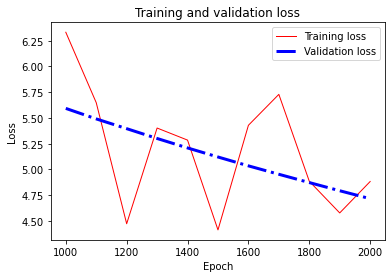

<Figure size 432x288 with 0 Axes>

Final Training loss: 4.8831563, Final Validation loss: 4.7163825, Training RMSE: 6.126186, Validation RMSE: 6.190249
-------------------------------------------------------------------------------------


Fold 3, lr: 5e-05, batch_size: 64, number_epochs: 2000, type_loss_func: MAE, type_optimizer: GradientDescent, neural_network_structure: multilayer_perceptron2
Epoch: 1000, Training loss: 4.7348366, Validation loss: 5.169762, 
Epoch: 2000, Training loss: 4.2082286, Validation loss: 4.24259, 
The total training time is: 6.705130000000054


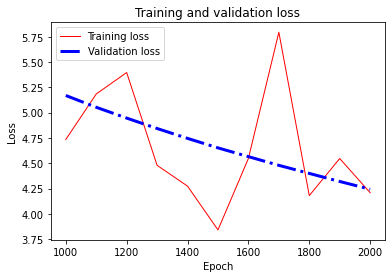

<Figure size 432x288 with 0 Axes>

Final Training loss: 4.2082286, Final Validation loss: 4.24259, Training RMSE: 5.397351, Validation RMSE: 5.4223685
-------------------------------------------------------------------------------------


Fold 4, lr: 5e-05, batch_size: 64, number_epochs: 2000, type_loss_func: MAE, type_optimizer: GradientDescent, neural_network_structure: multilayer_perceptron2
Epoch: 1000, Training loss: 2.2083442, Validation loss: 2.700018, 
Epoch: 2000, Training loss: 1.8107455, Validation loss: 2.3469763, 
The total training time is: 7.093287999999916


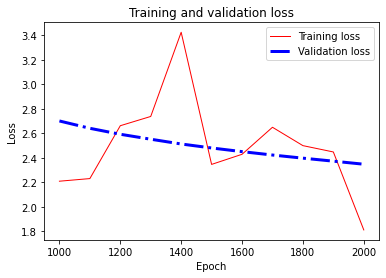

<Figure size 432x288 with 0 Axes>

Final Training loss: 1.8107455, Final Validation loss: 2.3469763, Training RMSE: 4.0498724, Validation RMSE: 3.8742182
-------------------------------------------------------------------------------------


Fold 5, lr: 5e-05, batch_size: 64, number_epochs: 2000, type_loss_func: MAE, type_optimizer: GradientDescent, neural_network_structure: multilayer_perceptron2
Epoch: 1000, Training loss: 9.510178, Validation loss: 9.707045, 
Epoch: 2000, Training loss: 6.659644, Validation loss: 7.1713743, 
The total training time is: 7.089819000000034


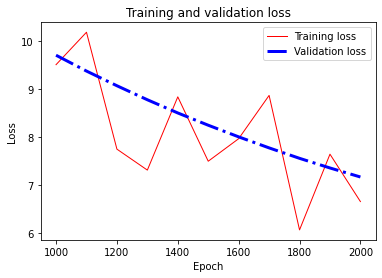

<Figure size 432x288 with 0 Axes>

Final Training loss: 6.659644, Final Validation loss: 7.1713743, Training RMSE: 8.985836, Validation RMSE: 9.064773
-------------------------------------------------------------------------------------


Fold 6, lr: 5e-05, batch_size: 64, number_epochs: 2000, type_loss_func: MAE, type_optimizer: GradientDescent, neural_network_structure: multilayer_perceptron2
Epoch: 1000, Training loss: 5.1999664, Validation loss: 5.69292, 
Epoch: 2000, Training loss: 3.5800226, Validation loss: 3.729225, 
The total training time is: 6.790719000000081


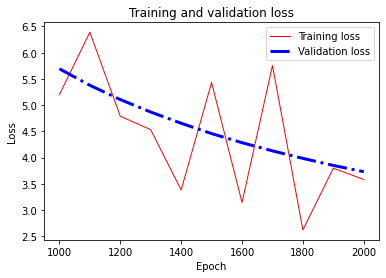

<Figure size 432x288 with 0 Axes>

Final Training loss: 3.5800226, Final Validation loss: 3.729225, Training RMSE: 7.606075, Validation RMSE: 7.507497
-------------------------------------------------------------------------------------


Fold 7, lr: 5e-05, batch_size: 64, number_epochs: 2000, type_loss_func: MAE, type_optimizer: GradientDescent, neural_network_structure: multilayer_perceptron2
Epoch: 1000, Training loss: 5.2671547, Validation loss: 5.8712687, 
Epoch: 2000, Training loss: 4.5603437, Validation loss: 3.8566732, 
The total training time is: 7.244118999999955


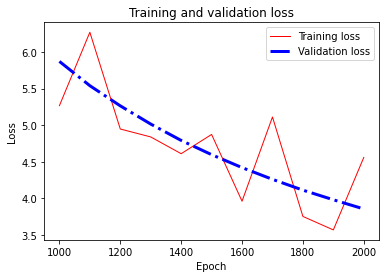

<Figure size 432x288 with 0 Axes>

Final Training loss: 4.5603437, Final Validation loss: 3.8566732, Training RMSE: 5.5485663, Validation RMSE: 5.494033
-------------------------------------------------------------------------------------


Fold 8, lr: 5e-05, batch_size: 64, number_epochs: 2000, type_loss_func: MAE, type_optimizer: GradientDescent, neural_network_structure: multilayer_perceptron2
Epoch: 1000, Training loss: 11.385761, Validation loss: 11.442447, 
Epoch: 2000, Training loss: 7.7217355, Validation loss: 7.854299, 
The total training time is: 7.221451000000002


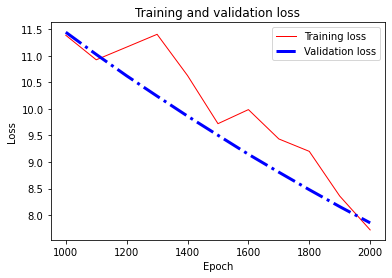

<Figure size 432x288 with 0 Axes>

Final Training loss: 7.7217355, Final Validation loss: 7.854299, Training RMSE: 10.225272, Validation RMSE: 10.104365
-------------------------------------------------------------------------------------


Fold 9, lr: 5e-05, batch_size: 64, number_epochs: 2000, type_loss_func: MAE, type_optimizer: GradientDescent, neural_network_structure: multilayer_perceptron2
Epoch: 1000, Training loss: 13.122213, Validation loss: 12.95713, 
Epoch: 2000, Training loss: 8.051952, Validation loss: 7.738716, 
The total training time is: 7.056508000000008


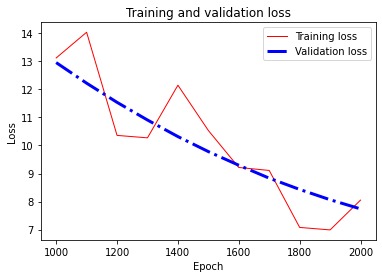

<Figure size 432x288 with 0 Axes>

Final Training loss: 8.051952, Final Validation loss: 7.738716, Training RMSE: 14.341097, Validation RMSE: 13.961904
-------------------------------------------------------------------------------------


Fold 10, lr: 5e-05, batch_size: 64, number_epochs: 2000, type_loss_func: MAE, type_optimizer: GradientDescent, neural_network_structure: multilayer_perceptron2
Epoch: 1000, Training loss: 15.64967, Validation loss: 17.187336, 
Epoch: 2000, Training loss: 7.152548, Validation loss: 7.1975036, 
The total training time is: 7.262689000000023


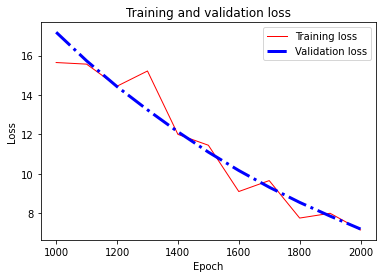

<Figure size 432x288 with 0 Axes>

Final Training loss: 7.152548, Final Validation loss: 7.1975036, Training RMSE: 9.094112, Validation RMSE: 9.112579
-------------------------------------------------------------------------------------


For the model with learning rate: 5e-05, batch size: 64, number_epochs: 2000, type_optimizer: GradientDescent, neural_network_structure: multilayer_perceptron2 

Average Training RMSE for the 10 folds: 9.78459 

Average Validation RMSE for the 10 folds: 9.760777 


-------------------------------------------------------------------------------------


Fold 1, lr: 5e-05, batch_size: 64, number_epochs: 2000, type_loss_func: MAE, type_optimizer: GradientDescent, neural_network_structure: multilayer_perceptron3
Epoch: 1000, Training loss: 3.9936929, Validation loss: 4.506191, 
Epoch: 2000, Training loss: 1.8986795, Validation loss: 2.2869763, 
The total training time is: 7.92436900000007


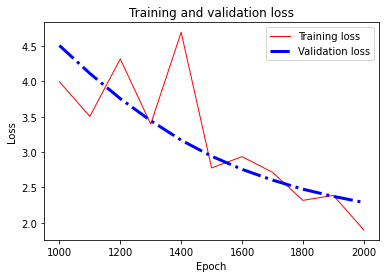

<Figure size 432x288 with 0 Axes>

Final Training loss: 1.8986795, Final Validation loss: 2.2869763, Training RMSE: 4.8583436, Validation RMSE: 4.5197096
-------------------------------------------------------------------------------------


Fold 2, lr: 5e-05, batch_size: 64, number_epochs: 2000, type_loss_func: MAE, type_optimizer: GradientDescent, neural_network_structure: multilayer_perceptron3
Epoch: 1000, Training loss: 4.9543037, Validation loss: 4.8771086, 
Epoch: 2000, Training loss: 1.843654, Validation loss: 2.081757, 
The total training time is: 7.722188999999958


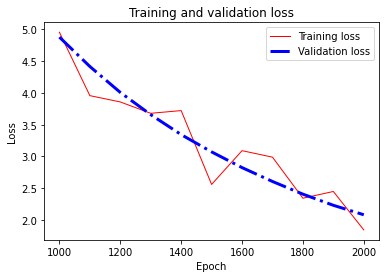

<Figure size 432x288 with 0 Axes>

Final Training loss: 1.843654, Final Validation loss: 2.081757, Training RMSE: 2.8429327, Validation RMSE: 2.8018322
-------------------------------------------------------------------------------------


Fold 3, lr: 5e-05, batch_size: 64, number_epochs: 2000, type_loss_func: MAE, type_optimizer: GradientDescent, neural_network_structure: multilayer_perceptron3
Epoch: 1000, Training loss: 2.625616, Validation loss: 2.520844, 
Epoch: 2000, Training loss: 2.0679805, Validation loss: 2.2802815, 
The total training time is: 7.818630999999982


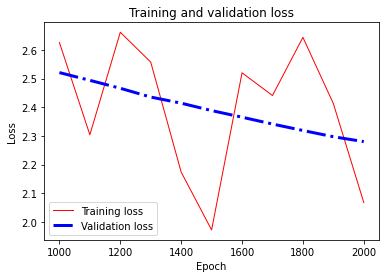

<Figure size 432x288 with 0 Axes>

Final Training loss: 2.0679805, Final Validation loss: 2.2802815, Training RMSE: 2.774851, Validation RMSE: 2.7757187
-------------------------------------------------------------------------------------


Fold 4, lr: 5e-05, batch_size: 64, number_epochs: 2000, type_loss_func: MAE, type_optimizer: GradientDescent, neural_network_structure: multilayer_perceptron3
Epoch: 1000, Training loss: 5.3579893, Validation loss: 5.487448, 
Epoch: 2000, Training loss: 2.5719945, Validation loss: 3.2754083, 
The total training time is: 7.562968999999953


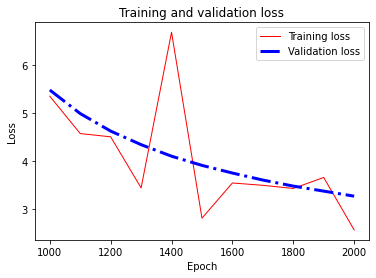

<Figure size 432x288 with 0 Axes>

Final Training loss: 2.5719945, Final Validation loss: 3.2754083, Training RMSE: 6.9042144, Validation RMSE: 6.8101096
-------------------------------------------------------------------------------------


Fold 5, lr: 5e-05, batch_size: 64, number_epochs: 2000, type_loss_func: MAE, type_optimizer: GradientDescent, neural_network_structure: multilayer_perceptron3
Epoch: 1000, Training loss: 7.15912, Validation loss: 9.488242, 
Epoch: 2000, Training loss: 6.02547, Validation loss: 6.7453237, 
The total training time is: 7.875529000000029


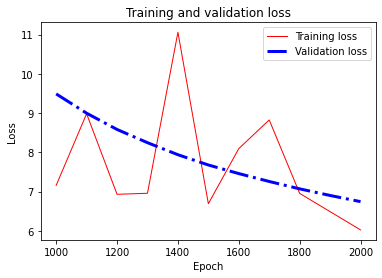

<Figure size 432x288 with 0 Axes>

Final Training loss: 6.02547, Final Validation loss: 6.7453237, Training RMSE: 12.004656, Validation RMSE: 13.015396
-------------------------------------------------------------------------------------


Fold 6, lr: 5e-05, batch_size: 64, number_epochs: 2000, type_loss_func: MAE, type_optimizer: GradientDescent, neural_network_structure: multilayer_perceptron3
Epoch: 1000, Training loss: 5.5040646, Validation loss: 5.826385, 
Epoch: 2000, Training loss: 3.0300946, Validation loss: 3.4027581, 
The total training time is: 7.726076000000035


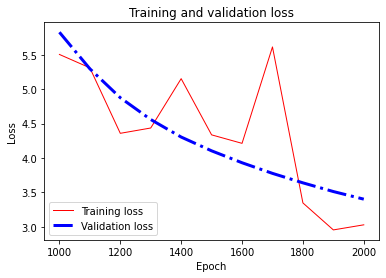

<Figure size 432x288 with 0 Axes>

Final Training loss: 3.0300946, Final Validation loss: 3.4027581, Training RMSE: 6.0414314, Validation RMSE: 5.992315
-------------------------------------------------------------------------------------


Fold 7, lr: 5e-05, batch_size: 64, number_epochs: 2000, type_loss_func: MAE, type_optimizer: GradientDescent, neural_network_structure: multilayer_perceptron3
Epoch: 1000, Training loss: 5.6713934, Validation loss: 5.9312735, 
Epoch: 2000, Training loss: 4.0685663, Validation loss: 4.716127, 
The total training time is: 7.766347999999994


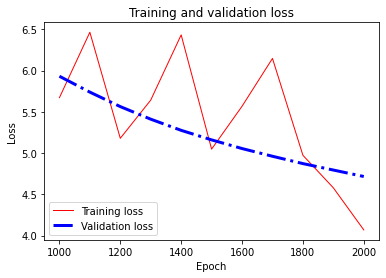

<Figure size 432x288 with 0 Axes>

Final Training loss: 4.0685663, Final Validation loss: 4.716127, Training RMSE: 6.404464, Validation RMSE: 6.349447
-------------------------------------------------------------------------------------


Fold 8, lr: 5e-05, batch_size: 64, number_epochs: 2000, type_loss_func: MAE, type_optimizer: GradientDescent, neural_network_structure: multilayer_perceptron3
Epoch: 1000, Training loss: 5.580534, Validation loss: 5.6445966, 
Epoch: 2000, Training loss: 4.7287636, Validation loss: 3.9401634, 
The total training time is: 7.9132620000000315


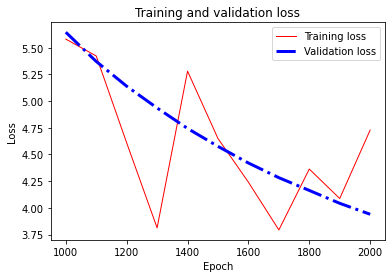

<Figure size 432x288 with 0 Axes>

Final Training loss: 4.7287636, Final Validation loss: 3.9401634, Training RMSE: 5.9027047, Validation RMSE: 5.669243
-------------------------------------------------------------------------------------


Fold 9, lr: 5e-05, batch_size: 64, number_epochs: 2000, type_loss_func: MAE, type_optimizer: GradientDescent, neural_network_structure: multilayer_perceptron3
Epoch: 1000, Training loss: 5.8760567, Validation loss: 5.4692516, 
Epoch: 2000, Training loss: 1.9230554, Validation loss: 2.0501142, 
The total training time is: 8.69381199999998


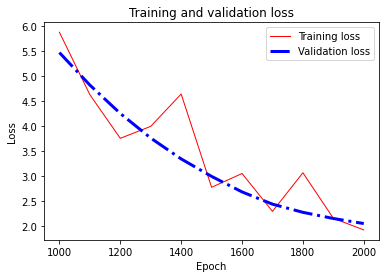

<Figure size 432x288 with 0 Axes>

Final Training loss: 1.9230554, Final Validation loss: 2.0501142, Training RMSE: 3.458558, Validation RMSE: 3.4341104
-------------------------------------------------------------------------------------


Fold 10, lr: 5e-05, batch_size: 64, number_epochs: 2000, type_loss_func: MAE, type_optimizer: GradientDescent, neural_network_structure: multilayer_perceptron3
Epoch: 1000, Training loss: 4.2383094, Validation loss: 4.791179, 
Epoch: 2000, Training loss: 3.932211, Validation loss: 3.036965, 
The total training time is: 7.941183999999907


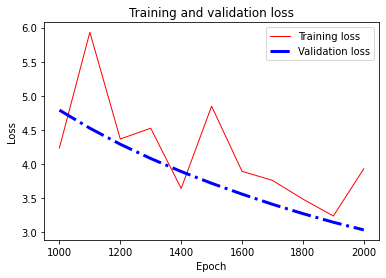

<Figure size 432x288 with 0 Axes>

Final Training loss: 3.932211, Final Validation loss: 3.036965, Training RMSE: 4.775333, Validation RMSE: 4.724608
-------------------------------------------------------------------------------------


For the model with learning rate: 5e-05, batch size: 64, number_epochs: 2000, type_optimizer: GradientDescent, neural_network_structure: multilayer_perceptron3 

Average Training RMSE for the 10 folds: 9.319274 

Average Validation RMSE for the 10 folds: 9.299497 


-------------------------------------------------------------------------------------


Fold 1, lr: 5e-05, batch_size: 64, number_epochs: 2000, type_loss_func: MAE, type_optimizer: Adagrad, neural_network_structure: multilayer_perceptron1
Epoch: 1000, Training loss: 16.6331, Validation loss: 16.678759, 
Epoch: 2000, Training loss: 16.132698, Validation loss: 16.618013, 
The total training time is: 6.159859000000097


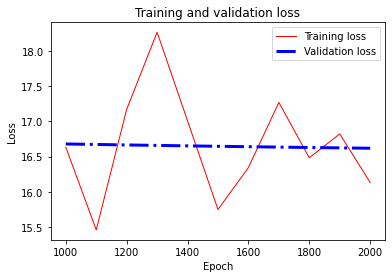

<Figure size 432x288 with 0 Axes>

Final Training loss: 16.132698, Final Validation loss: 16.618013, Training RMSE: 19.205303, Validation RMSE: 18.85337
-------------------------------------------------------------------------------------


Fold 2, lr: 5e-05, batch_size: 64, number_epochs: 2000, type_loss_func: MAE, type_optimizer: Adagrad, neural_network_structure: multilayer_perceptron1
Epoch: 1000, Training loss: 10.863409, Validation loss: 10.427023, 
Epoch: 2000, Training loss: 9.36601, Validation loss: 10.366018, 
The total training time is: 5.920406000000071


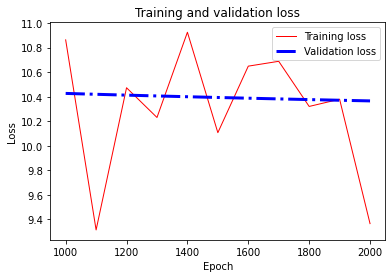

<Figure size 432x288 with 0 Axes>

Final Training loss: 9.36601, Final Validation loss: 10.366018, Training RMSE: 11.116206, Validation RMSE: 11.034725
-------------------------------------------------------------------------------------


Fold 3, lr: 5e-05, batch_size: 64, number_epochs: 2000, type_loss_func: MAE, type_optimizer: Adagrad, neural_network_structure: multilayer_perceptron1
Epoch: 1000, Training loss: 8.418734, Validation loss: 9.076226, 
Epoch: 2000, Training loss: 9.654203, Validation loss: 9.028914, 
The total training time is: 5.983033999999975


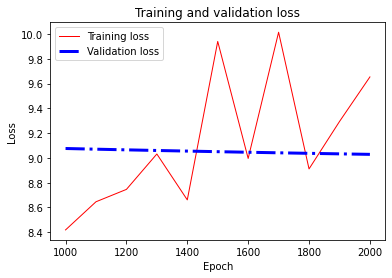

<Figure size 432x288 with 0 Axes>

Final Training loss: 9.654203, Final Validation loss: 9.028914, Training RMSE: 10.93359, Validation RMSE: 10.790257
-------------------------------------------------------------------------------------


Fold 4, lr: 5e-05, batch_size: 64, number_epochs: 2000, type_loss_func: MAE, type_optimizer: Adagrad, neural_network_structure: multilayer_perceptron1
Epoch: 1000, Training loss: 7.917368, Validation loss: 7.5816355, 
Epoch: 2000, Training loss: 7.252138, Validation loss: 7.5252337, 
The total training time is: 6.194422000000031


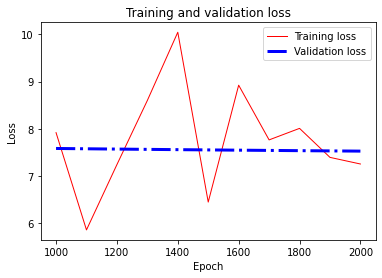

<Figure size 432x288 with 0 Axes>

Final Training loss: 7.252138, Final Validation loss: 7.5252337, Training RMSE: 11.704994, Validation RMSE: 11.521325
-------------------------------------------------------------------------------------


Fold 5, lr: 5e-05, batch_size: 64, number_epochs: 2000, type_loss_func: MAE, type_optimizer: Adagrad, neural_network_structure: multilayer_perceptron1
Epoch: 1000, Training loss: 9.163582, Validation loss: 9.267662, 
Epoch: 2000, Training loss: 9.464798, Validation loss: 9.221564, 
The total training time is: 5.903986000000032


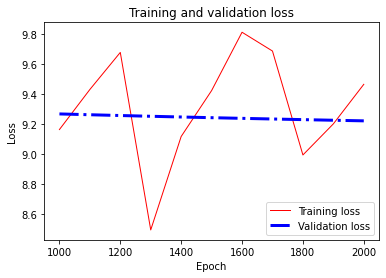

<Figure size 432x288 with 0 Axes>

Final Training loss: 9.464798, Final Validation loss: 9.221564, Training RMSE: 10.498562, Validation RMSE: 10.506972
-------------------------------------------------------------------------------------


Fold 6, lr: 5e-05, batch_size: 64, number_epochs: 2000, type_loss_func: MAE, type_optimizer: Adagrad, neural_network_structure: multilayer_perceptron1
Epoch: 1000, Training loss: 4.794439, Validation loss: 5.9437203, 
Epoch: 2000, Training loss: 6.507416, Validation loss: 5.9144793, 
The total training time is: 6.300966000000017


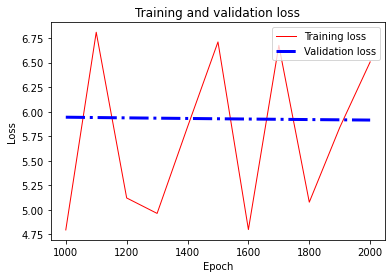

<Figure size 432x288 with 0 Axes>

Final Training loss: 6.507416, Final Validation loss: 5.9144793, Training RMSE: 8.52014, Validation RMSE: 8.590366
-------------------------------------------------------------------------------------


Fold 7, lr: 5e-05, batch_size: 64, number_epochs: 2000, type_loss_func: MAE, type_optimizer: Adagrad, neural_network_structure: multilayer_perceptron1
Epoch: 1000, Training loss: 5.961007, Validation loss: 5.5510745, 
Epoch: 2000, Training loss: 5.17149, Validation loss: 5.5088105, 
The total training time is: 6.157570999999962


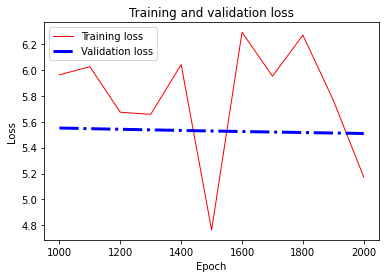

<Figure size 432x288 with 0 Axes>

Final Training loss: 5.17149, Final Validation loss: 5.5088105, Training RMSE: 6.886016, Validation RMSE: 6.85712
-------------------------------------------------------------------------------------


Fold 8, lr: 5e-05, batch_size: 64, number_epochs: 2000, type_loss_func: MAE, type_optimizer: Adagrad, neural_network_structure: multilayer_perceptron1
Epoch: 1000, Training loss: 5.374432, Validation loss: 5.6287913, 
Epoch: 2000, Training loss: 4.979115, Validation loss: 5.598983, 
The total training time is: 6.28100500000005


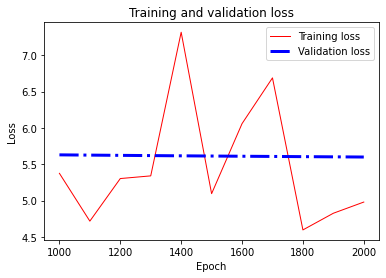

<Figure size 432x288 with 0 Axes>

Final Training loss: 4.979115, Final Validation loss: 5.598983, Training RMSE: 9.848027, Validation RMSE: 9.541651
-------------------------------------------------------------------------------------


Fold 9, lr: 5e-05, batch_size: 64, number_epochs: 2000, type_loss_func: MAE, type_optimizer: Adagrad, neural_network_structure: multilayer_perceptron1
Epoch: 1000, Training loss: 5.83306, Validation loss: 5.751601, 
Epoch: 2000, Training loss: 5.1965227, Validation loss: 5.712662, 
The total training time is: 5.917318000000023


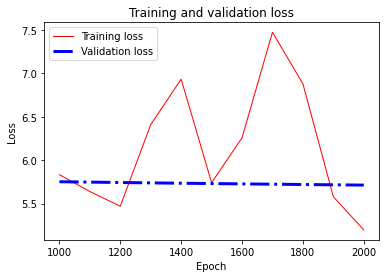

<Figure size 432x288 with 0 Axes>

Final Training loss: 5.1965227, Final Validation loss: 5.712662, Training RMSE: 8.769614, Validation RMSE: 8.360601
-------------------------------------------------------------------------------------


Fold 10, lr: 5e-05, batch_size: 64, number_epochs: 2000, type_loss_func: MAE, type_optimizer: Adagrad, neural_network_structure: multilayer_perceptron1
Epoch: 1000, Training loss: 9.027117, Validation loss: 7.6408067, 
Epoch: 2000, Training loss: 7.35704, Validation loss: 7.5897727, 
The total training time is: 7.192945000000009


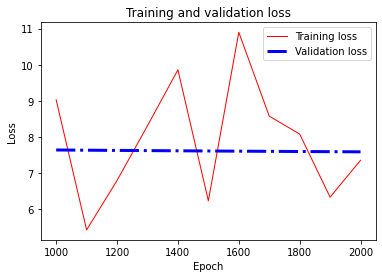

<Figure size 432x288 with 0 Axes>

Final Training loss: 7.35704, Final Validation loss: 7.5897727, Training RMSE: 11.243743, Validation RMSE: 11.020936
-------------------------------------------------------------------------------------


For the model with learning rate: 5e-05, batch size: 64, number_epochs: 2000, type_optimizer: Adagrad, neural_network_structure: multilayer_perceptron1 

Average Training RMSE for the 10 folds: 9.474608 

Average Validation RMSE for the 10 folds: 9.44032 


-------------------------------------------------------------------------------------


Fold 1, lr: 5e-05, batch_size: 64, number_epochs: 2000, type_loss_func: MAE, type_optimizer: Adagrad, neural_network_structure: multilayer_perceptron2
Epoch: 1000, Training loss: 15.120995, Validation loss: 14.61858, 
Epoch: 2000, Training loss: 14.69528, Validation loss: 14.423823, 
The total training time is: 7.38450499999999


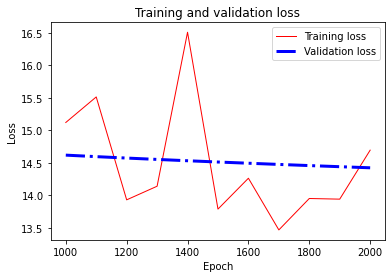

<Figure size 432x288 with 0 Axes>

Final Training loss: 14.69528, Final Validation loss: 14.423823, Training RMSE: 17.210081, Validation RMSE: 17.38886
-------------------------------------------------------------------------------------


Fold 2, lr: 5e-05, batch_size: 64, number_epochs: 2000, type_loss_func: MAE, type_optimizer: Adagrad, neural_network_structure: multilayer_perceptron2
Epoch: 1000, Training loss: 18.376396, Validation loss: 18.243423, 
Epoch: 2000, Training loss: 17.604656, Validation loss: 17.996592, 
The total training time is: 7.574922000000015


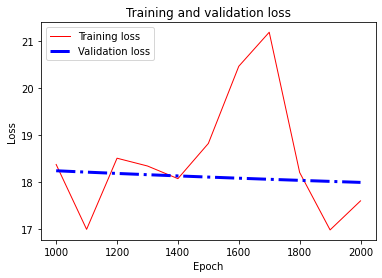

<Figure size 432x288 with 0 Axes>

Final Training loss: 17.604656, Final Validation loss: 17.996592, Training RMSE: 20.477207, Validation RMSE: 20.812557
-------------------------------------------------------------------------------------


Fold 3, lr: 5e-05, batch_size: 64, number_epochs: 2000, type_loss_func: MAE, type_optimizer: Adagrad, neural_network_structure: multilayer_perceptron2
Epoch: 1000, Training loss: 36.772095, Validation loss: 36.51571, 
Epoch: 2000, Training loss: 39.554955, Validation loss: 36.258514, 
The total training time is: 7.387445999999954


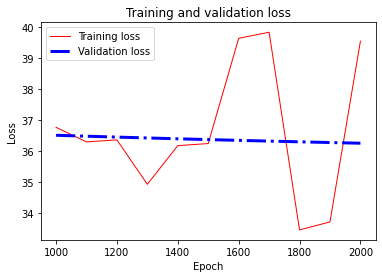

<Figure size 432x288 with 0 Axes>

Final Training loss: 39.554955, Final Validation loss: 36.258514, Training RMSE: 41.345463, Validation RMSE: 41.233078
-------------------------------------------------------------------------------------


Fold 4, lr: 5e-05, batch_size: 64, number_epochs: 2000, type_loss_func: MAE, type_optimizer: Adagrad, neural_network_structure: multilayer_perceptron2
Epoch: 1000, Training loss: 17.752903, Validation loss: 17.878237, 
Epoch: 2000, Training loss: 17.290424, Validation loss: 17.618711, 
The total training time is: 7.603760000000079


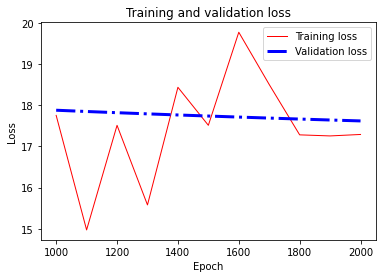

<Figure size 432x288 with 0 Axes>

Final Training loss: 17.290424, Final Validation loss: 17.618711, Training RMSE: 21.01003, Validation RMSE: 21.21256
-------------------------------------------------------------------------------------


Fold 5, lr: 5e-05, batch_size: 64, number_epochs: 2000, type_loss_func: MAE, type_optimizer: Adagrad, neural_network_structure: multilayer_perceptron2
Epoch: 1000, Training loss: 19.192856, Validation loss: 17.66528, 
Epoch: 2000, Training loss: 15.258013, Validation loss: 17.477953, 
The total training time is: 7.57199700000001


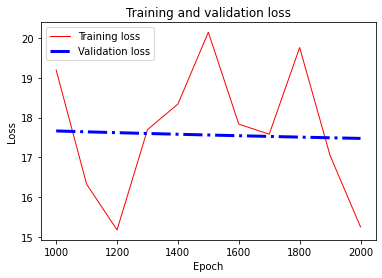

<Figure size 432x288 with 0 Axes>

Final Training loss: 15.258013, Final Validation loss: 17.477953, Training RMSE: 23.078001, Validation RMSE: 23.28044
-------------------------------------------------------------------------------------


Fold 6, lr: 5e-05, batch_size: 64, number_epochs: 2000, type_loss_func: MAE, type_optimizer: Adagrad, neural_network_structure: multilayer_perceptron2
Epoch: 1000, Training loss: 10.365231, Validation loss: 9.387801, 
Epoch: 2000, Training loss: 9.470179, Validation loss: 9.268851, 
The total training time is: 7.767438000000084


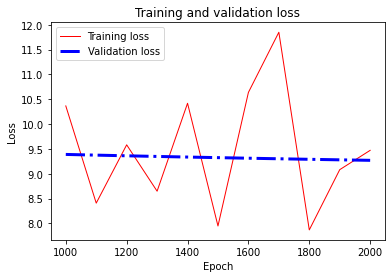

<Figure size 432x288 with 0 Axes>

Final Training loss: 9.470179, Final Validation loss: 9.268851, Training RMSE: 12.824141, Validation RMSE: 12.636561
-------------------------------------------------------------------------------------


Fold 7, lr: 5e-05, batch_size: 64, number_epochs: 2000, type_loss_func: MAE, type_optimizer: Adagrad, neural_network_structure: multilayer_perceptron2
Epoch: 1000, Training loss: 13.124685, Validation loss: 13.575935, 
Epoch: 2000, Training loss: 16.04169, Validation loss: 13.416036, 
The total training time is: 7.686278000000016


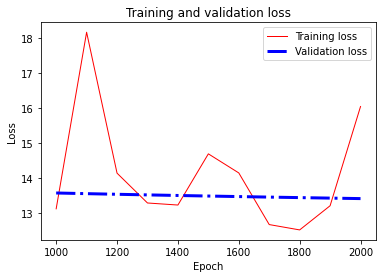

<Figure size 432x288 with 0 Axes>

Final Training loss: 16.04169, Final Validation loss: 13.416036, Training RMSE: 18.230667, Validation RMSE: 17.84242
-------------------------------------------------------------------------------------


Fold 8, lr: 5e-05, batch_size: 64, number_epochs: 2000, type_loss_func: MAE, type_optimizer: Adagrad, neural_network_structure: multilayer_perceptron2
Epoch: 1000, Training loss: 48.954353, Validation loss: 45.281464, 
Epoch: 2000, Training loss: 42.41167, Validation loss: 44.889606, 
The total training time is: 7.589956000000029


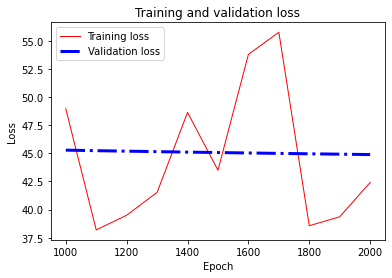

<Figure size 432x288 with 0 Axes>

Final Training loss: 42.41167, Final Validation loss: 44.889606, Training RMSE: 57.982605, Validation RMSE: 58.48412
-------------------------------------------------------------------------------------


Fold 9, lr: 5e-05, batch_size: 64, number_epochs: 2000, type_loss_func: MAE, type_optimizer: Adagrad, neural_network_structure: multilayer_perceptron2
Epoch: 1000, Training loss: 8.216677, Validation loss: 7.729231, 
Epoch: 2000, Training loss: 7.857076, Validation loss: 7.588922, 
The total training time is: 7.653122999999937


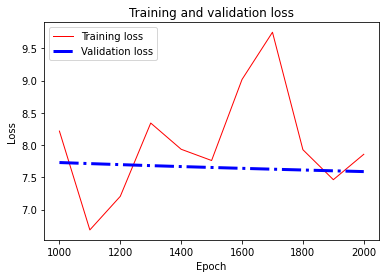

<Figure size 432x288 with 0 Axes>

Final Training loss: 7.857076, Final Validation loss: 7.588922, Training RMSE: 9.200957, Validation RMSE: 8.975228
-------------------------------------------------------------------------------------


Fold 10, lr: 5e-05, batch_size: 64, number_epochs: 2000, type_loss_func: MAE, type_optimizer: Adagrad, neural_network_structure: multilayer_perceptron2
Epoch: 1000, Training loss: 13.676529, Validation loss: 14.25153, 
Epoch: 2000, Training loss: 12.6916065, Validation loss: 14.128733, 
The total training time is: 7.63922500000001


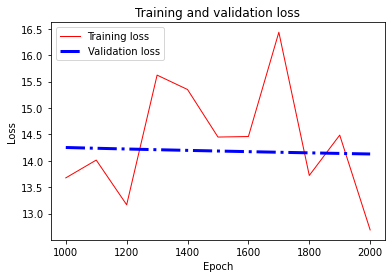

<Figure size 432x288 with 0 Axes>

Final Training loss: 12.6916065, Final Validation loss: 14.128733, Training RMSE: 16.765547, Validation RMSE: 16.712189
-------------------------------------------------------------------------------------


For the model with learning rate: 5e-05, batch size: 64, number_epochs: 2000, type_optimizer: Adagrad, neural_network_structure: multilayer_perceptron2 

Average Training RMSE for the 10 folds: 10.77805 

Average Validation RMSE for the 10 folds: 10.751001 


-------------------------------------------------------------------------------------


Fold 1, lr: 5e-05, batch_size: 64, number_epochs: 2000, type_loss_func: MAE, type_optimizer: Adagrad, neural_network_structure: multilayer_perceptron3
Epoch: 1000, Training loss: 21.690594, Validation loss: 21.213263, 
Epoch: 2000, Training loss: 19.562904, Validation loss: 20.786497, 
The total training time is: 8.220137000000022


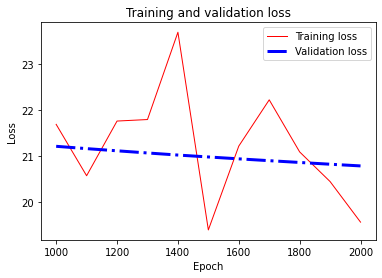

<Figure size 432x288 with 0 Axes>

Final Training loss: 19.562904, Final Validation loss: 20.786497, Training RMSE: 25.106998, Validation RMSE: 24.637081
-------------------------------------------------------------------------------------


Fold 2, lr: 5e-05, batch_size: 64, number_epochs: 2000, type_loss_func: MAE, type_optimizer: Adagrad, neural_network_structure: multilayer_perceptron3
Epoch: 1000, Training loss: 19.366985, Validation loss: 19.699938, 
Epoch: 2000, Training loss: 19.150654, Validation loss: 19.48104, 
The total training time is: 8.148677999999904


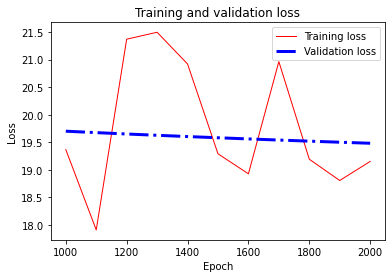

<Figure size 432x288 with 0 Axes>

Final Training loss: 19.150654, Final Validation loss: 19.48104, Training RMSE: 21.449812, Validation RMSE: 21.560848
-------------------------------------------------------------------------------------


Fold 3, lr: 5e-05, batch_size: 64, number_epochs: 2000, type_loss_func: MAE, type_optimizer: Adagrad, neural_network_structure: multilayer_perceptron3
Epoch: 1000, Training loss: 12.397744, Validation loss: 12.7150755, 
Epoch: 2000, Training loss: 12.253291, Validation loss: 12.457362, 
The total training time is: 8.077519999999936


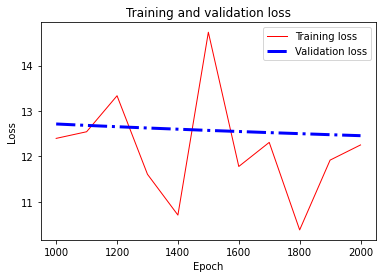

<Figure size 432x288 with 0 Axes>

Final Training loss: 12.253291, Final Validation loss: 12.457362, Training RMSE: 17.26171, Validation RMSE: 17.287964
-------------------------------------------------------------------------------------


Fold 4, lr: 5e-05, batch_size: 64, number_epochs: 2000, type_loss_func: MAE, type_optimizer: Adagrad, neural_network_structure: multilayer_perceptron3
Epoch: 1000, Training loss: 18.024086, Validation loss: 18.363554, 
Epoch: 2000, Training loss: 17.712006, Validation loss: 18.121008, 
The total training time is: 7.886997000000065


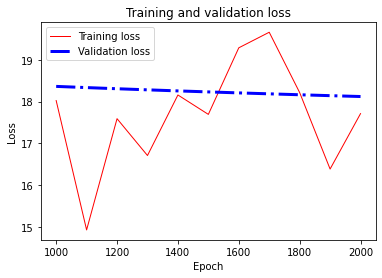

<Figure size 432x288 with 0 Axes>

Final Training loss: 17.712006, Final Validation loss: 18.121008, Training RMSE: 20.495457, Validation RMSE: 20.735151
-------------------------------------------------------------------------------------


Fold 5, lr: 5e-05, batch_size: 64, number_epochs: 2000, type_loss_func: MAE, type_optimizer: Adagrad, neural_network_structure: multilayer_perceptron3
Epoch: 1000, Training loss: 11.359243, Validation loss: 14.437956, 
Epoch: 2000, Training loss: 12.878937, Validation loss: 14.250573, 
The total training time is: 8.503909999999905


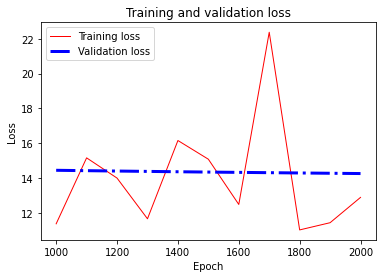

<Figure size 432x288 with 0 Axes>

Final Training loss: 12.878937, Final Validation loss: 14.250573, Training RMSE: 32.12936, Validation RMSE: 36.366993
-------------------------------------------------------------------------------------


Fold 6, lr: 5e-05, batch_size: 64, number_epochs: 2000, type_loss_func: MAE, type_optimizer: Adagrad, neural_network_structure: multilayer_perceptron3
Epoch: 1000, Training loss: 23.205923, Validation loss: 22.570818, 
Epoch: 2000, Training loss: 20.412437, Validation loss: 22.16988, 
The total training time is: 8.186337999999978


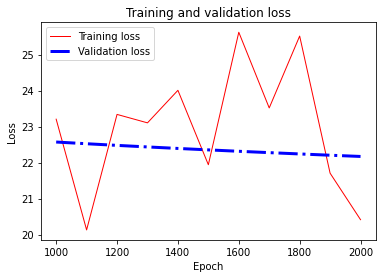

<Figure size 432x288 with 0 Axes>

Final Training loss: 20.412437, Final Validation loss: 22.16988, Training RMSE: 25.20184, Validation RMSE: 24.93571
-------------------------------------------------------------------------------------


Fold 7, lr: 5e-05, batch_size: 64, number_epochs: 2000, type_loss_func: MAE, type_optimizer: Adagrad, neural_network_structure: multilayer_perceptron3
Epoch: 1000, Training loss: 28.44534, Validation loss: 27.533276, 
Epoch: 2000, Training loss: 27.597832, Validation loss: 27.237604, 
The total training time is: 8.327681999999868


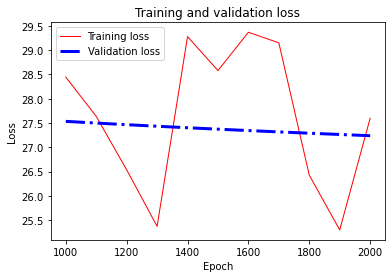

<Figure size 432x288 with 0 Axes>

Final Training loss: 27.597832, Final Validation loss: 27.237604, Training RMSE: 33.69651, Validation RMSE: 33.499107
-------------------------------------------------------------------------------------


Fold 8, lr: 5e-05, batch_size: 64, number_epochs: 2000, type_loss_func: MAE, type_optimizer: Adagrad, neural_network_structure: multilayer_perceptron3
Epoch: 1000, Training loss: 10.172928, Validation loss: 11.234468, 
Epoch: 2000, Training loss: 13.768944, Validation loss: 11.01884, 
The total training time is: 8.222533000000112


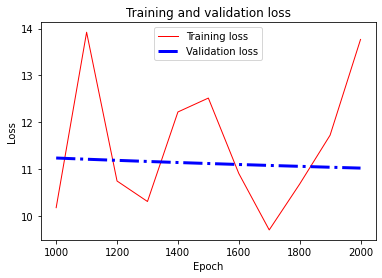

<Figure size 432x288 with 0 Axes>

Final Training loss: 13.768944, Final Validation loss: 11.01884, Training RMSE: 15.613603, Validation RMSE: 15.026288
-------------------------------------------------------------------------------------


Fold 9, lr: 5e-05, batch_size: 64, number_epochs: 2000, type_loss_func: MAE, type_optimizer: Adagrad, neural_network_structure: multilayer_perceptron3
Epoch: 1000, Training loss: 54.714996, Validation loss: 53.0346, 
Epoch: 2000, Training loss: 49.410347, Validation loss: 52.537434, 
The total training time is: 9.52897699999994


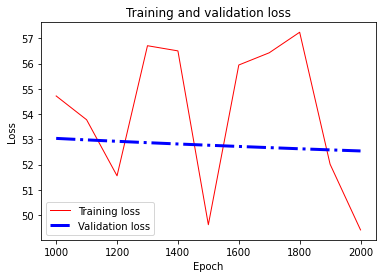

<Figure size 432x288 with 0 Axes>

Final Training loss: 49.410347, Final Validation loss: 52.537434, Training RMSE: 59.14089, Validation RMSE: 58.944702
-------------------------------------------------------------------------------------


Fold 10, lr: 5e-05, batch_size: 64, number_epochs: 2000, type_loss_func: MAE, type_optimizer: Adagrad, neural_network_structure: multilayer_perceptron3
Epoch: 1000, Training loss: 6.792615, Validation loss: 7.269894, 
Epoch: 2000, Training loss: 7.0315776, Validation loss: 7.0548964, 
The total training time is: 8.629403000000138


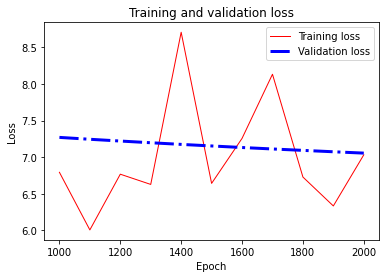

<Figure size 432x288 with 0 Axes>

Final Training loss: 7.0315776, Final Validation loss: 7.0548964, Training RMSE: 9.342246, Validation RMSE: 9.213858
-------------------------------------------------------------------------------------


For the model with learning rate: 5e-05, batch size: 64, number_epochs: 2000, type_optimizer: Adagrad, neural_network_structure: multilayer_perceptron3 

Average Training RMSE for the 10 folds: 12.041866 

Average Validation RMSE for the 10 folds: 12.040149 


-------------------------------------------------------------------------------------


Fold 1, lr: 5e-05, batch_size: 64, number_epochs: 3000, type_loss_func: MSE, type_optimizer: GradientDescent, neural_network_structure: multilayer_perceptron1
Epoch: 1000, Training loss: 12.073267, Validation loss: 13.371616, 
Epoch: 2000, Training loss: 6.154279, Validation loss: 6.840299, 
Epoch: 3000, Training loss: 5.028014, Validation loss: 4.8561316, 
The total training time is: 9.085945999999922


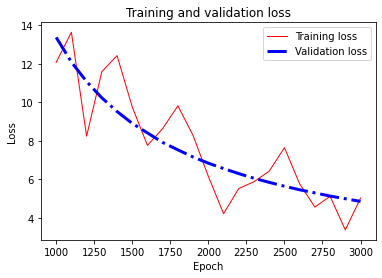

<Figure size 432x288 with 0 Axes>

Final Training loss: 5.028014, Final Validation loss: 4.8561316, Training RMSE: 2.2357812, Validation RMSE: 2.203663
-------------------------------------------------------------------------------------


Fold 2, lr: 5e-05, batch_size: 64, number_epochs: 3000, type_loss_func: MSE, type_optimizer: GradientDescent, neural_network_structure: multilayer_perceptron1
Epoch: 1000, Training loss: 5.1116495, Validation loss: 9.572878, 
Epoch: 2000, Training loss: 5.939655, Validation loss: 5.5309935, 
Epoch: 3000, Training loss: 3.6724129, Validation loss: 4.0755916, 
The total training time is: 9.059104000000161


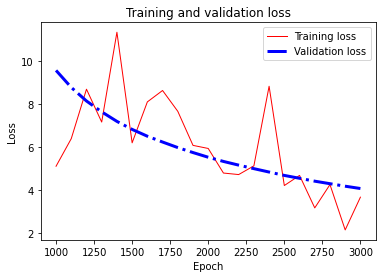

<Figure size 432x288 with 0 Axes>

Final Training loss: 3.6724129, Final Validation loss: 4.0755916, Training RMSE: 1.9718535, Validation RMSE: 2.0188096
-------------------------------------------------------------------------------------


Fold 3, lr: 5e-05, batch_size: 64, number_epochs: 3000, type_loss_func: MSE, type_optimizer: GradientDescent, neural_network_structure: multilayer_perceptron1
Epoch: 1000, Training loss: 8.139013, Validation loss: 8.426761, 
Epoch: 2000, Training loss: 4.324419, Validation loss: 4.730485, 
Epoch: 3000, Training loss: 2.673054, Validation loss: 3.8813105, 
The total training time is: 9.266979999999876


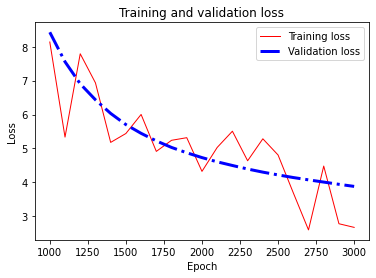

<Figure size 432x288 with 0 Axes>

Final Training loss: 2.673054, Final Validation loss: 3.8813105, Training RMSE: 1.963366, Validation RMSE: 1.9701042
-------------------------------------------------------------------------------------


Fold 4, lr: 5e-05, batch_size: 64, number_epochs: 3000, type_loss_func: MSE, type_optimizer: GradientDescent, neural_network_structure: multilayer_perceptron1
Epoch: 1000, Training loss: 5.1480556, Validation loss: 6.455276, 
Epoch: 2000, Training loss: 2.635885, Validation loss: 2.7778232, 
Epoch: 3000, Training loss: 1.7590468, Validation loss: 1.9275858, 
The total training time is: 9.199435000000221


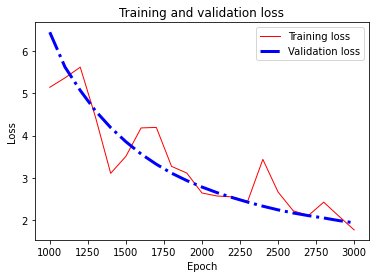

<Figure size 432x288 with 0 Axes>

Final Training loss: 1.7590468, Final Validation loss: 1.9275858, Training RMSE: 1.4061719, Validation RMSE: 1.3883753
-------------------------------------------------------------------------------------


Fold 5, lr: 5e-05, batch_size: 64, number_epochs: 3000, type_loss_func: MSE, type_optimizer: GradientDescent, neural_network_structure: multilayer_perceptron1
Epoch: 1000, Training loss: 4.3621483, Validation loss: 5.158202, 
Epoch: 2000, Training loss: 2.4347167, Validation loss: 3.3091772, 
Epoch: 3000, Training loss: 2.269131, Validation loss: 2.7604747, 
The total training time is: 9.180370000000039


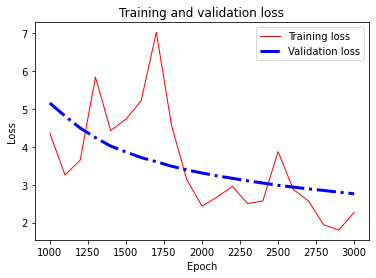

<Figure size 432x288 with 0 Axes>

Final Training loss: 2.269131, Final Validation loss: 2.7604747, Training RMSE: 1.6553357, Validation RMSE: 1.6614677
-------------------------------------------------------------------------------------


Fold 6, lr: 5e-05, batch_size: 64, number_epochs: 3000, type_loss_func: MSE, type_optimizer: GradientDescent, neural_network_structure: multilayer_perceptron1
Epoch: 1000, Training loss: 5.2783813, Validation loss: 6.478741, 
Epoch: 2000, Training loss: 2.9096394, Validation loss: 4.3818192, 
Epoch: 3000, Training loss: 2.9206696, Validation loss: 3.616418, 
The total training time is: 9.53131499999995


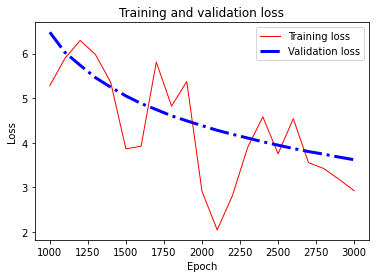

<Figure size 432x288 with 0 Axes>

Final Training loss: 2.9206696, Final Validation loss: 3.616418, Training RMSE: 1.8808457, Validation RMSE: 1.9016882
-------------------------------------------------------------------------------------


Fold 7, lr: 5e-05, batch_size: 64, number_epochs: 3000, type_loss_func: MSE, type_optimizer: GradientDescent, neural_network_structure: multilayer_perceptron1
Epoch: 1000, Training loss: 8.447993, Validation loss: 9.145206, 
Epoch: 2000, Training loss: 4.363738, Validation loss: 4.731771, 
Epoch: 3000, Training loss: 4.439995, Validation loss: 3.4560006, 
The total training time is: 9.027796999999964


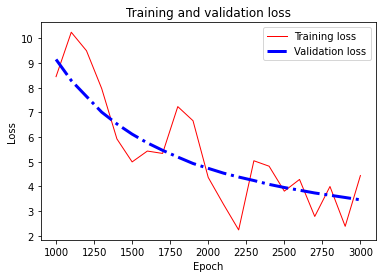

<Figure size 432x288 with 0 Axes>

Final Training loss: 4.439995, Final Validation loss: 3.4560006, Training RMSE: 1.8660322, Validation RMSE: 1.8590322
-------------------------------------------------------------------------------------


Fold 8, lr: 5e-05, batch_size: 64, number_epochs: 3000, type_loss_func: MSE, type_optimizer: GradientDescent, neural_network_structure: multilayer_perceptron1
Epoch: 1000, Training loss: 6.2380104, Validation loss: 8.859009, 
Epoch: 2000, Training loss: 3.909294, Validation loss: 5.502929, 
Epoch: 3000, Training loss: 3.7956235, Validation loss: 4.459783, 
The total training time is: 9.454385000000002


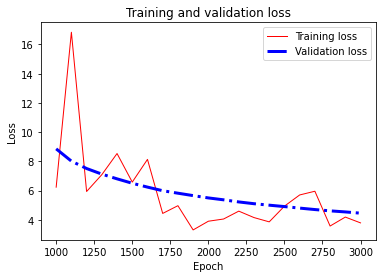

<Figure size 432x288 with 0 Axes>

Final Training loss: 3.7956235, Final Validation loss: 4.459783, Training RMSE: 2.1136115, Validation RMSE: 2.1118197
-------------------------------------------------------------------------------------


Fold 9, lr: 5e-05, batch_size: 64, number_epochs: 3000, type_loss_func: MSE, type_optimizer: GradientDescent, neural_network_structure: multilayer_perceptron1
Epoch: 1000, Training loss: 7.449378, Validation loss: 8.240607, 
Epoch: 2000, Training loss: 3.1469636, Validation loss: 3.478321, 
Epoch: 3000, Training loss: 2.427556, Validation loss: 2.5086188, 
The total training time is: 9.384363000000121


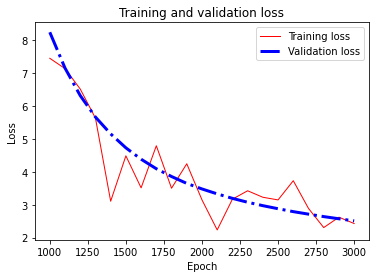

<Figure size 432x288 with 0 Axes>

Final Training loss: 2.427556, Final Validation loss: 2.5086188, Training RMSE: 1.5656817, Validation RMSE: 1.583862
-------------------------------------------------------------------------------------


Fold 10, lr: 5e-05, batch_size: 64, number_epochs: 3000, type_loss_func: MSE, type_optimizer: GradientDescent, neural_network_structure: multilayer_perceptron1
Epoch: 1000, Training loss: 14.847062, Validation loss: 16.534363, 
Epoch: 2000, Training loss: 5.953121, Validation loss: 7.442338, 
Epoch: 3000, Training loss: 5.230238, Validation loss: 4.6709795, 
The total training time is: 9.317129999999906


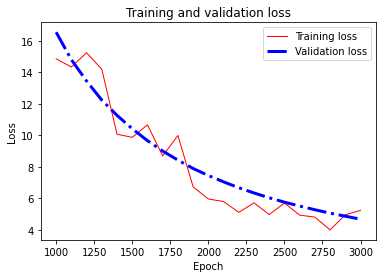

<Figure size 432x288 with 0 Axes>

Final Training loss: 5.230238, Final Validation loss: 4.6709795, Training RMSE: 2.1528945, Validation RMSE: 2.1612449
-------------------------------------------------------------------------------------


For the model with learning rate: 5e-05, batch size: 64, number_epochs: 3000, type_optimizer: GradientDescent, neural_network_structure: multilayer_perceptron1 

Average Training RMSE for the 10 folds: 11.260274 

Average Validation RMSE for the 10 folds: 11.259061 


-------------------------------------------------------------------------------------


Fold 1, lr: 5e-05, batch_size: 64, number_epochs: 3000, type_loss_func: MSE, type_optimizer: GradientDescent, neural_network_structure: multilayer_perceptron2
Epoch: 1000, Training loss: 2.0220506, Validation loss: 3.4902792, 
Epoch: 2000, Training loss: 2.0194817, Validation loss: 2.5666592, 
Epoch: 3000, Training loss: 2.3895068, Validation loss: 2.1792982, 
The total training time is: 11.522285999999895


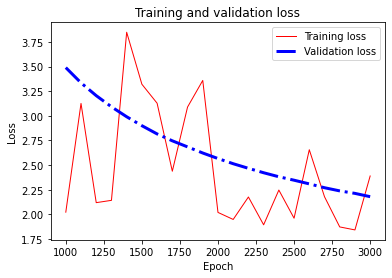

<Figure size 432x288 with 0 Axes>

Final Training loss: 2.3895068, Final Validation loss: 2.1792982, Training RMSE: 1.483969, Validation RMSE: 1.4762446
-------------------------------------------------------------------------------------


Fold 2, lr: 5e-05, batch_size: 64, number_epochs: 3000, type_loss_func: MSE, type_optimizer: GradientDescent, neural_network_structure: multilayer_perceptron2
Epoch: 1000, Training loss: 9.412563, Validation loss: 8.164677, 
Epoch: 2000, Training loss: 3.8867557, Validation loss: 4.0765104, 
Epoch: 3000, Training loss: 2.490604, Validation loss: 2.8081768, 
The total training time is: 11.961485999999923


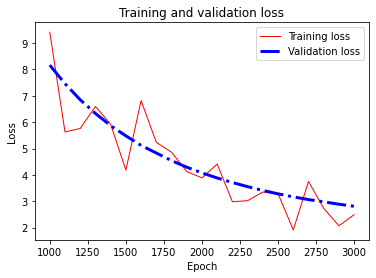

<Figure size 432x288 with 0 Axes>

Final Training loss: 2.490604, Final Validation loss: 2.8081768, Training RMSE: 1.635229, Validation RMSE: 1.6757616
-------------------------------------------------------------------------------------


Fold 3, lr: 5e-05, batch_size: 64, number_epochs: 3000, type_loss_func: MSE, type_optimizer: GradientDescent, neural_network_structure: multilayer_perceptron2
Epoch: 1000, Training loss: 5.406822, Validation loss: 5.72988, 
Epoch: 2000, Training loss: 2.5346584, Validation loss: 3.052852, 
Epoch: 3000, Training loss: 2.2137191, Validation loss: 2.2211826, 
The total training time is: 10.96715499999982


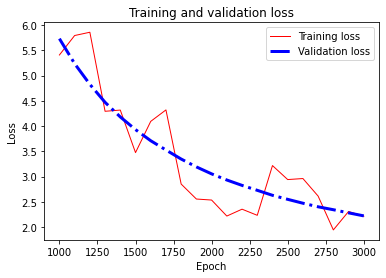

<Figure size 432x288 with 0 Axes>

Final Training loss: 2.2137191, Final Validation loss: 2.2211826, Training RMSE: 1.4894718, Validation RMSE: 1.4903632
-------------------------------------------------------------------------------------


Fold 4, lr: 5e-05, batch_size: 64, number_epochs: 3000, type_loss_func: MSE, type_optimizer: GradientDescent, neural_network_structure: multilayer_perceptron2
Epoch: 1000, Training loss: 6.56363, Validation loss: 7.4624114, 
Epoch: 2000, Training loss: 2.7698102, Validation loss: 4.823022, 
Epoch: 3000, Training loss: 2.7205505, Validation loss: 3.7598228, 
The total training time is: 11.458102999999937


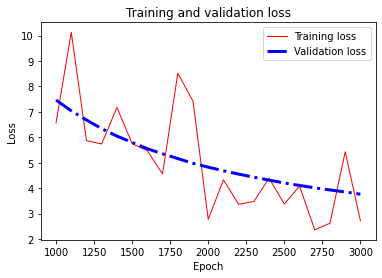

<Figure size 432x288 with 0 Axes>

Final Training loss: 2.7205505, Final Validation loss: 3.7598228, Training RMSE: 1.9097892, Validation RMSE: 1.9390262
-------------------------------------------------------------------------------------


Fold 5, lr: 5e-05, batch_size: 64, number_epochs: 3000, type_loss_func: MSE, type_optimizer: GradientDescent, neural_network_structure: multilayer_perceptron2
Epoch: 1000, Training loss: 5.060747, Validation loss: 5.888497, 
Epoch: 2000, Training loss: 3.0825572, Validation loss: 3.424985, 
Epoch: 3000, Training loss: 2.2635236, Validation loss: 2.6390812, 
The total training time is: 11.256421000000046


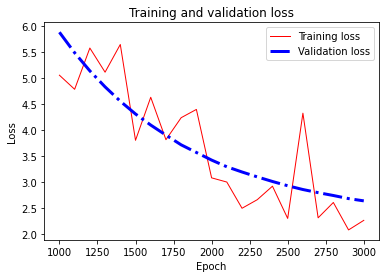

<Figure size 432x288 with 0 Axes>

Final Training loss: 2.2635236, Final Validation loss: 2.6390812, Training RMSE: 1.6121422, Validation RMSE: 1.624525
-------------------------------------------------------------------------------------


Fold 6, lr: 5e-05, batch_size: 64, number_epochs: 3000, type_loss_func: MSE, type_optimizer: GradientDescent, neural_network_structure: multilayer_perceptron2
Epoch: 1000, Training loss: 10.820263, Validation loss: 8.210424, 
Epoch: 2000, Training loss: 4.93282, Validation loss: 5.2846236, 
Epoch: 3000, Training loss: 2.9922214, Validation loss: 4.0911775, 
The total training time is: 11.012511000000131


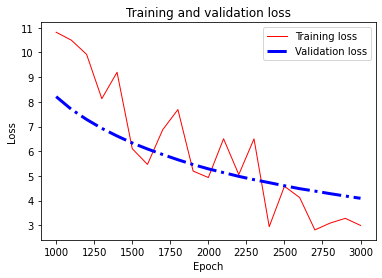

<Figure size 432x288 with 0 Axes>

Final Training loss: 2.9922214, Final Validation loss: 4.0911775, Training RMSE: 2.0509686, Validation RMSE: 2.022666
-------------------------------------------------------------------------------------


Fold 7, lr: 5e-05, batch_size: 64, number_epochs: 3000, type_loss_func: MSE, type_optimizer: GradientDescent, neural_network_structure: multilayer_perceptron2
Epoch: 1000, Training loss: 4.887795, Validation loss: 5.4048643, 
Epoch: 2000, Training loss: 2.4811187, Validation loss: 3.4158483, 
Epoch: 3000, Training loss: 2.693386, Validation loss: 2.6021104, 
The total training time is: 12.349681999999802


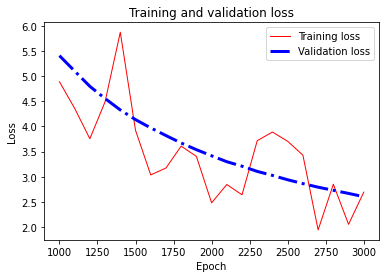

<Figure size 432x288 with 0 Axes>

Final Training loss: 2.693386, Final Validation loss: 2.6021104, Training RMSE: 1.6166586, Validation RMSE: 1.6131058
-------------------------------------------------------------------------------------


Fold 8, lr: 5e-05, batch_size: 64, number_epochs: 3000, type_loss_func: MSE, type_optimizer: GradientDescent, neural_network_structure: multilayer_perceptron2
Epoch: 1000, Training loss: 5.3250284, Validation loss: 5.700247, 
Epoch: 2000, Training loss: 2.087945, Validation loss: 3.734224, 
Epoch: 3000, Training loss: 2.2721844, Validation loss: 2.904463, 
The total training time is: 11.661383999999998


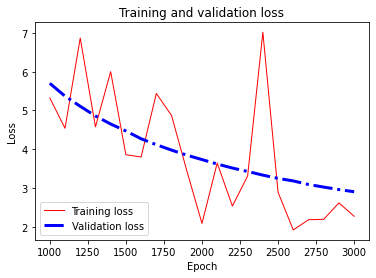

<Figure size 432x288 with 0 Axes>

Final Training loss: 2.2721844, Final Validation loss: 2.904463, Training RMSE: 1.6919347, Validation RMSE: 1.7042485
-------------------------------------------------------------------------------------


Fold 9, lr: 5e-05, batch_size: 64, number_epochs: 3000, type_loss_func: MSE, type_optimizer: GradientDescent, neural_network_structure: multilayer_perceptron2
Epoch: 1000, Training loss: 5.339742, Validation loss: 5.807903, 
Epoch: 2000, Training loss: 2.6475725, Validation loss: 3.4590647, 
Epoch: 3000, Training loss: 2.4224658, Validation loss: 2.736719, 
The total training time is: 11.560257999999976


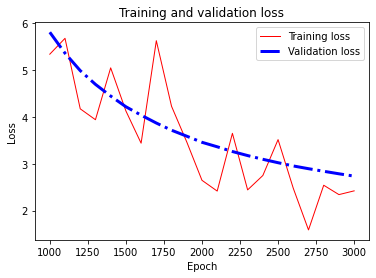

<Figure size 432x288 with 0 Axes>

Final Training loss: 2.4224658, Final Validation loss: 2.736719, Training RMSE: 1.6414042, Validation RMSE: 1.6543032
-------------------------------------------------------------------------------------


Fold 10, lr: 5e-05, batch_size: 64, number_epochs: 3000, type_loss_func: MSE, type_optimizer: GradientDescent, neural_network_structure: multilayer_perceptron2
Epoch: 1000, Training loss: 5.341749, Validation loss: 5.6332393, 
Epoch: 2000, Training loss: 2.7000122, Validation loss: 3.670933, 
Epoch: 3000, Training loss: 2.4742064, Validation loss: 2.8667097, 
The total training time is: 11.653721000000132


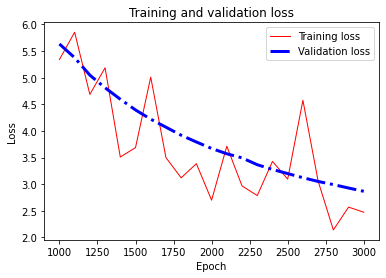

<Figure size 432x288 with 0 Axes>

Final Training loss: 2.4742064, Final Validation loss: 2.8667097, Training RMSE: 1.7108594, Validation RMSE: 1.6931361
-------------------------------------------------------------------------------------


For the model with learning rate: 5e-05, batch size: 64, number_epochs: 3000, type_optimizer: GradientDescent, neural_network_structure: multilayer_perceptron2 

Average Training RMSE for the 10 folds: 10.576271 

Average Validation RMSE for the 10 folds: 10.575508 


-------------------------------------------------------------------------------------


Fold 1, lr: 5e-05, batch_size: 64, number_epochs: 3000, type_loss_func: MSE, type_optimizer: GradientDescent, neural_network_structure: multilayer_perceptron3
Epoch: 1000, Training loss: 2.5437446, Validation loss: 3.2058923, 
Epoch: 2000, Training loss: 2.752664, Validation loss: 2.787488, 
Epoch: 3000, Training loss: 1.5634019, Validation loss: 2.5578666, 
The total training time is: 14.230004999999892


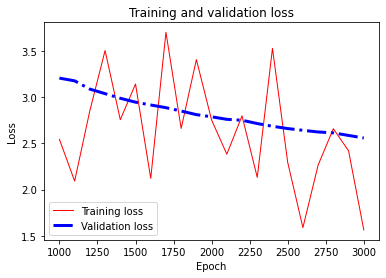

<Figure size 432x288 with 0 Axes>

Final Training loss: 1.5634019, Final Validation loss: 2.5578666, Training RMSE: 1.6108606, Validation RMSE: 1.5993332
-------------------------------------------------------------------------------------


Fold 2, lr: 5e-05, batch_size: 64, number_epochs: 3000, type_loss_func: MSE, type_optimizer: GradientDescent, neural_network_structure: multilayer_perceptron3
Epoch: 1000, Training loss: 4.374619, Validation loss: 4.7102146, 
Epoch: 2000, Training loss: 3.8031223, Validation loss: 3.6865132, 
Epoch: 3000, Training loss: 2.760857, Validation loss: 3.1064677, 
The total training time is: 12.990493999999899


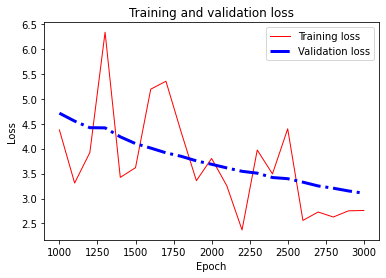

<Figure size 432x288 with 0 Axes>

Final Training loss: 2.760857, Final Validation loss: 3.1064677, Training RMSE: 1.772102, Validation RMSE: 1.7625175
-------------------------------------------------------------------------------------


Fold 3, lr: 5e-05, batch_size: 64, number_epochs: 3000, type_loss_func: MSE, type_optimizer: GradientDescent, neural_network_structure: multilayer_perceptron3
Epoch: 1000, Training loss: 2.5278323, Validation loss: 3.60741, 
Epoch: 2000, Training loss: 2.1798024, Validation loss: 2.5464725, 
Epoch: 3000, Training loss: 1.7337202, Validation loss: 2.0995495, 
The total training time is: 11.846893000000136


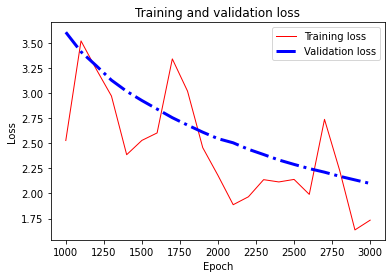

<Figure size 432x288 with 0 Axes>

Final Training loss: 1.7337202, Final Validation loss: 2.0995495, Training RMSE: 1.4697422, Validation RMSE: 1.4489822
-------------------------------------------------------------------------------------


Fold 4, lr: 5e-05, batch_size: 64, number_epochs: 3000, type_loss_func: MSE, type_optimizer: GradientDescent, neural_network_structure: multilayer_perceptron3
Epoch: 1000, Training loss: 6.1473093, Validation loss: 7.8366003, 
Epoch: 2000, Training loss: 3.1572611, Validation loss: 3.889435, 
Epoch: 3000, Training loss: 2.2233646, Validation loss: 2.7266653, 
The total training time is: 12.68145699999991


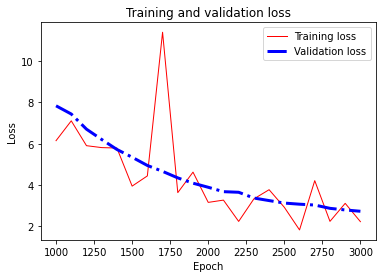

<Figure size 432x288 with 0 Axes>

Final Training loss: 2.2233646, Final Validation loss: 2.7266653, Training RMSE: 1.6582221, Validation RMSE: 1.6512617
-------------------------------------------------------------------------------------


Fold 5, lr: 5e-05, batch_size: 64, number_epochs: 3000, type_loss_func: MSE, type_optimizer: GradientDescent, neural_network_structure: multilayer_perceptron3
Epoch: 1000, Training loss: 3.2842298, Validation loss: 5.6681714, 
Epoch: 2000, Training loss: 3.2171478, Validation loss: 3.5294616, 
Epoch: 3000, Training loss: 2.6180944, Validation loss: 2.7160652, 
The total training time is: 12.558502999999973


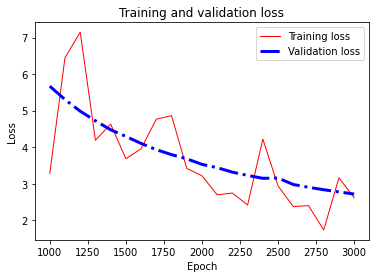

<Figure size 432x288 with 0 Axes>

Final Training loss: 2.6180944, Final Validation loss: 2.7160652, Training RMSE: 1.6726387, Validation RMSE: 1.6480489
-------------------------------------------------------------------------------------


Fold 6, lr: 5e-05, batch_size: 64, number_epochs: 3000, type_loss_func: MSE, type_optimizer: GradientDescent, neural_network_structure: multilayer_perceptron3
Epoch: 1000, Training loss: 4.615033, Validation loss: 3.9593737, 
Epoch: 2000, Training loss: 3.0681984, Validation loss: 2.4997997, 
Epoch: 3000, Training loss: 2.2256532, Validation loss: 2.0281105, 
The total training time is: 12.54284400000006


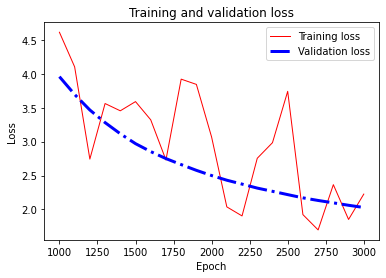

<Figure size 432x288 with 0 Axes>

Final Training loss: 2.2256532, Final Validation loss: 2.0281105, Training RMSE: 1.4620684, Validation RMSE: 1.4241174
-------------------------------------------------------------------------------------


Fold 7, lr: 5e-05, batch_size: 64, number_epochs: 3000, type_loss_func: MSE, type_optimizer: GradientDescent, neural_network_structure: multilayer_perceptron3
Epoch: 1000, Training loss: 4.382846, Validation loss: 5.498674, 
Epoch: 2000, Training loss: 2.9663882, Validation loss: 3.764255, 
Epoch: 3000, Training loss: 2.3356657, Validation loss: 2.6960974, 
The total training time is: 12.590636000000131


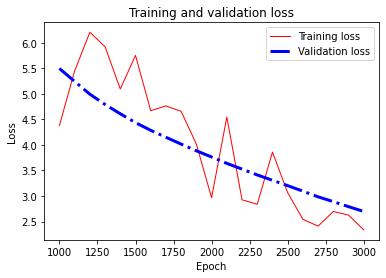

<Figure size 432x288 with 0 Axes>

Final Training loss: 2.3356657, Final Validation loss: 2.6960974, Training RMSE: 1.6649116, Validation RMSE: 1.6419797
-------------------------------------------------------------------------------------


Fold 8, lr: 5e-05, batch_size: 64, number_epochs: 3000, type_loss_func: MSE, type_optimizer: GradientDescent, neural_network_structure: multilayer_perceptron3
Epoch: 1000, Training loss: 4.0317345, Validation loss: 3.894961, 
Epoch: 2000, Training loss: 3.0098505, Validation loss: 2.753065, 
Epoch: 3000, Training loss: 1.6108406, Validation loss: 2.1704512, 
The total training time is: 12.299070999999913


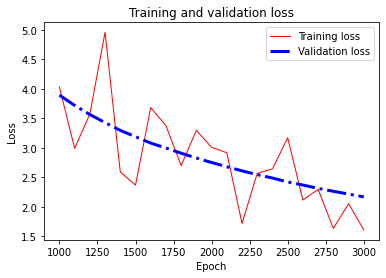

<Figure size 432x288 with 0 Axes>

Final Training loss: 1.6108406, Final Validation loss: 2.1704512, Training RMSE: 1.4730967, Validation RMSE: 1.4732451
-------------------------------------------------------------------------------------


Fold 9, lr: 5e-05, batch_size: 64, number_epochs: 3000, type_loss_func: MSE, type_optimizer: GradientDescent, neural_network_structure: multilayer_perceptron3
Epoch: 1000, Training loss: 4.556663, Validation loss: 5.5543838, 
Epoch: 2000, Training loss: 2.8198857, Validation loss: 3.542053, 
Epoch: 3000, Training loss: 2.4313796, Validation loss: 2.9332027, 
The total training time is: 12.376745000000028


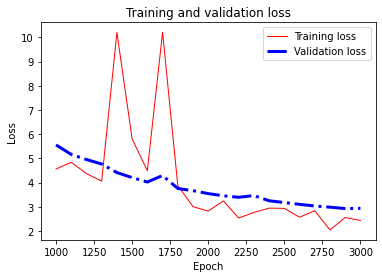

<Figure size 432x288 with 0 Axes>

Final Training loss: 2.4313796, Final Validation loss: 2.9332027, Training RMSE: 1.7343087, Validation RMSE: 1.7126596
-------------------------------------------------------------------------------------


Fold 10, lr: 5e-05, batch_size: 64, number_epochs: 3000, type_loss_func: MSE, type_optimizer: GradientDescent, neural_network_structure: multilayer_perceptron3
Epoch: 1000, Training loss: 3.2458558, Validation loss: 4.342897, 
Epoch: 2000, Training loss: 2.288268, Validation loss: 3.3705485, 
Epoch: 3000, Training loss: 2.7977796, Validation loss: 2.8642254, 
The total training time is: 11.883208999999852


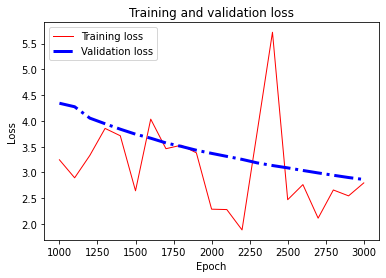

<Figure size 432x288 with 0 Axes>

Final Training loss: 2.7977796, Final Validation loss: 2.8642254, Training RMSE: 1.7383648, Validation RMSE: 1.6924022
-------------------------------------------------------------------------------------


For the model with learning rate: 5e-05, batch size: 64, number_epochs: 3000, type_optimizer: GradientDescent, neural_network_structure: multilayer_perceptron3 

Average Training RMSE for the 10 folds: 9.979562 

Average Validation RMSE for the 10 folds: 9.977505 


-------------------------------------------------------------------------------------


Fold 1, lr: 5e-05, batch_size: 64, number_epochs: 3000, type_loss_func: MSE, type_optimizer: Adagrad, neural_network_structure: multilayer_perceptron1
Epoch: 1000, Training loss: 224.93436, Validation loss: 187.59277, 
Epoch: 2000, Training loss: 127.326645, Validation loss: 185.68697, 
Epoch: 3000, Training loss: 150.3763, Validation loss: 184.22958, 
The total training time is: 10.161317000000054


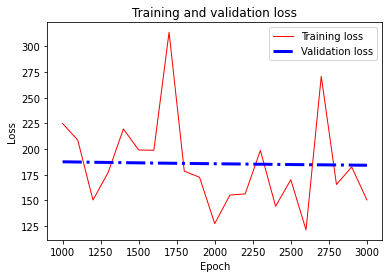

<Figure size 432x288 with 0 Axes>

Final Training loss: 150.3763, Final Validation loss: 184.22958, Training RMSE: 13.763371, Validation RMSE: 13.57312
-------------------------------------------------------------------------------------


Fold 2, lr: 5e-05, batch_size: 64, number_epochs: 3000, type_loss_func: MSE, type_optimizer: Adagrad, neural_network_structure: multilayer_perceptron1
Epoch: 1000, Training loss: 46.009422, Validation loss: 66.465126, 
Epoch: 2000, Training loss: 31.508684, Validation loss: 65.907425, 
Epoch: 3000, Training loss: 27.38036, Validation loss: 65.48668, 
The total training time is: 9.90713699999992


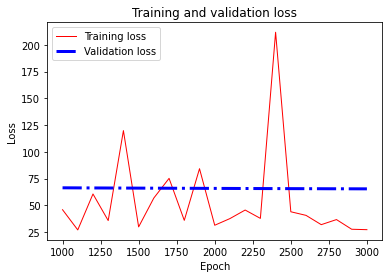

<Figure size 432x288 with 0 Axes>

Final Training loss: 27.38036, Final Validation loss: 65.48668, Training RMSE: 8.51167, Validation RMSE: 8.092384
-------------------------------------------------------------------------------------


Fold 3, lr: 5e-05, batch_size: 64, number_epochs: 3000, type_loss_func: MSE, type_optimizer: Adagrad, neural_network_structure: multilayer_perceptron1
Epoch: 1000, Training loss: 108.13544, Validation loss: 87.066895, 
Epoch: 2000, Training loss: 81.6673, Validation loss: 85.97411, 
Epoch: 3000, Training loss: 94.374435, Validation loss: 85.14589, 
The total training time is: 9.79727600000001


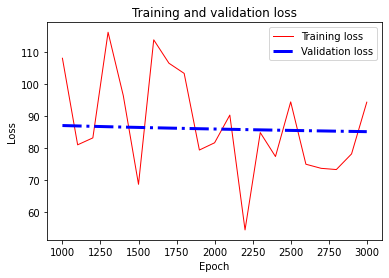

<Figure size 432x288 with 0 Axes>

Final Training loss: 94.374435, Final Validation loss: 85.14589, Training RMSE: 9.233941, Validation RMSE: 9.227453
-------------------------------------------------------------------------------------


Fold 4, lr: 5e-05, batch_size: 64, number_epochs: 3000, type_loss_func: MSE, type_optimizer: Adagrad, neural_network_structure: multilayer_perceptron1
Epoch: 1000, Training loss: 161.04489, Validation loss: 210.26805, 
Epoch: 2000, Training loss: 188.16644, Validation loss: 208.88313, 
Epoch: 3000, Training loss: 171.68968, Validation loss: 207.82948, 
The total training time is: 9.86674099999982


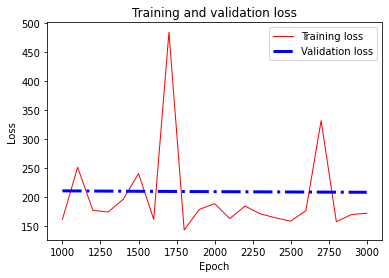

<Figure size 432x288 with 0 Axes>

Final Training loss: 171.68968, Final Validation loss: 207.82948, Training RMSE: 14.170335, Validation RMSE: 14.416292
-------------------------------------------------------------------------------------


Fold 5, lr: 5e-05, batch_size: 64, number_epochs: 3000, type_loss_func: MSE, type_optimizer: Adagrad, neural_network_structure: multilayer_perceptron1
Epoch: 1000, Training loss: 162.77936, Validation loss: 126.44771, 
Epoch: 2000, Training loss: 152.79593, Validation loss: 125.3734, 
Epoch: 3000, Training loss: 126.98944, Validation loss: 124.552925, 
The total training time is: 10.030922999999802


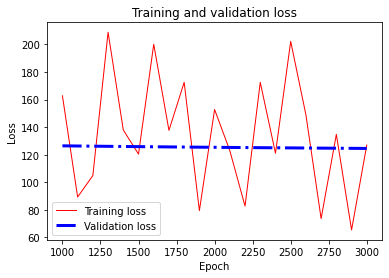

<Figure size 432x288 with 0 Axes>

Final Training loss: 126.98944, Final Validation loss: 124.552925, Training RMSE: 11.178429, Validation RMSE: 11.160328
-------------------------------------------------------------------------------------


Fold 6, lr: 5e-05, batch_size: 64, number_epochs: 3000, type_loss_func: MSE, type_optimizer: Adagrad, neural_network_structure: multilayer_perceptron1
Epoch: 1000, Training loss: 30.43114, Validation loss: 37.733166, 
Epoch: 2000, Training loss: 46.151367, Validation loss: 37.256454, 
Epoch: 3000, Training loss: 43.43696, Validation loss: 36.900326, 
The total training time is: 9.710816000000023


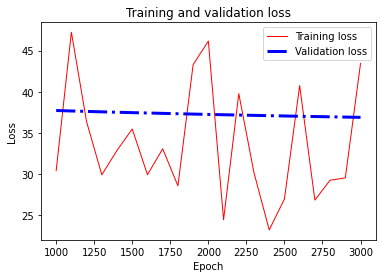

<Figure size 432x288 with 0 Axes>

Final Training loss: 43.43696, Final Validation loss: 36.900326, Training RMSE: 5.9077954, Validation RMSE: 6.074564
-------------------------------------------------------------------------------------


Fold 7, lr: 5e-05, batch_size: 64, number_epochs: 3000, type_loss_func: MSE, type_optimizer: Adagrad, neural_network_structure: multilayer_perceptron1
Epoch: 1000, Training loss: 148.10501, Validation loss: 139.02176, 
Epoch: 2000, Training loss: 122.28378, Validation loss: 137.75703, 
Epoch: 3000, Training loss: 123.64576, Validation loss: 136.79315, 
The total training time is: 9.846742999999833


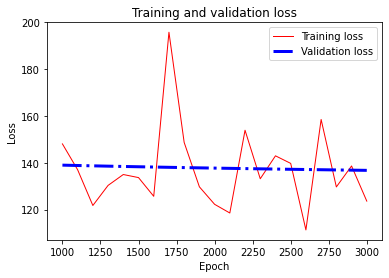

<Figure size 432x288 with 0 Axes>

Final Training loss: 123.64576, Final Validation loss: 136.79315, Training RMSE: 11.628677, Validation RMSE: 11.695861
-------------------------------------------------------------------------------------


Fold 8, lr: 5e-05, batch_size: 64, number_epochs: 3000, type_loss_func: MSE, type_optimizer: Adagrad, neural_network_structure: multilayer_perceptron1
Epoch: 1000, Training loss: 47.53553, Validation loss: 51.539143, 
Epoch: 2000, Training loss: 48.49105, Validation loss: 50.99075, 
Epoch: 3000, Training loss: 40.725914, Validation loss: 50.57247, 
The total training time is: 9.740108000000191


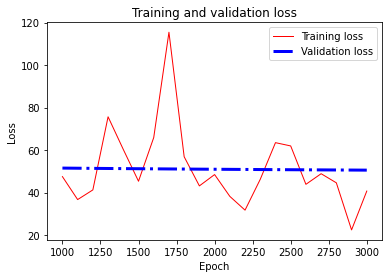

<Figure size 432x288 with 0 Axes>

Final Training loss: 40.725914, Final Validation loss: 50.57247, Training RMSE: 7.153342, Validation RMSE: 7.1114326
-------------------------------------------------------------------------------------


Fold 9, lr: 5e-05, batch_size: 64, number_epochs: 3000, type_loss_func: MSE, type_optimizer: Adagrad, neural_network_structure: multilayer_perceptron1
Epoch: 1000, Training loss: 42.599632, Validation loss: 39.70753, 
Epoch: 2000, Training loss: 28.745676, Validation loss: 39.153183, 
Epoch: 3000, Training loss: 32.219982, Validation loss: 38.733814, 
The total training time is: 9.795344999999998


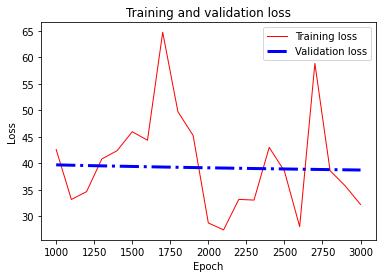

<Figure size 432x288 with 0 Axes>

Final Training loss: 32.219982, Final Validation loss: 38.733814, Training RMSE: 6.399456, Validation RMSE: 6.2236495
-------------------------------------------------------------------------------------


Fold 10, lr: 5e-05, batch_size: 64, number_epochs: 3000, type_loss_func: MSE, type_optimizer: Adagrad, neural_network_structure: multilayer_perceptron1
Epoch: 1000, Training loss: 41.808914, Validation loss: 34.88391, 
Epoch: 2000, Training loss: 26.747383, Validation loss: 34.320885, 
Epoch: 3000, Training loss: 27.98472, Validation loss: 33.89371, 
The total training time is: 9.82777699999997


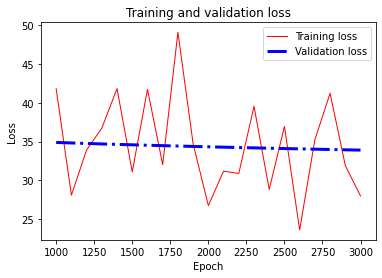

<Figure size 432x288 with 0 Axes>

Final Training loss: 27.98472, Final Validation loss: 33.89371, Training RMSE: 5.8249946, Validation RMSE: 5.8218307
-------------------------------------------------------------------------------------


For the model with learning rate: 5e-05, batch size: 64, number_epochs: 3000, type_optimizer: Adagrad, neural_network_structure: multilayer_perceptron1 

Average Training RMSE for the 10 folds: 9.941915 

Average Validation RMSE for the 10 folds: 9.937642 


-------------------------------------------------------------------------------------


Fold 1, lr: 5e-05, batch_size: 64, number_epochs: 3000, type_loss_func: MSE, type_optimizer: Adagrad, neural_network_structure: multilayer_perceptron2
Epoch: 1000, Training loss: 334.75125, Validation loss: 363.67123, 
Epoch: 2000, Training loss: 243.49625, Validation loss: 357.58902, 
Epoch: 3000, Training loss: 261.35495, Validation loss: 353.04495, 
The total training time is: 11.707361999999875


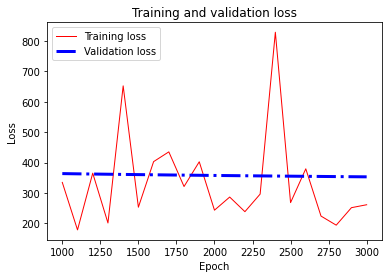

<Figure size 432x288 with 0 Axes>

Final Training loss: 261.35495, Final Validation loss: 353.04495, Training RMSE: 19.798077, Validation RMSE: 18.78949
-------------------------------------------------------------------------------------


Fold 2, lr: 5e-05, batch_size: 64, number_epochs: 3000, type_loss_func: MSE, type_optimizer: Adagrad, neural_network_structure: multilayer_perceptron2
Epoch: 1000, Training loss: 226.56961, Validation loss: 221.61353, 
Epoch: 2000, Training loss: 213.4673, Validation loss: 217.16983, 
Epoch: 3000, Training loss: 186.46637, Validation loss: 213.81377, 
The total training time is: 11.047857000000022


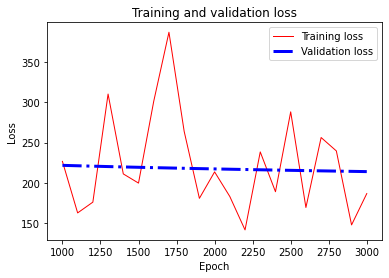

<Figure size 432x288 with 0 Axes>

Final Training loss: 186.46637, Final Validation loss: 213.81377, Training RMSE: 14.497094, Validation RMSE: 14.622372
-------------------------------------------------------------------------------------


Fold 3, lr: 5e-05, batch_size: 64, number_epochs: 3000, type_loss_func: MSE, type_optimizer: Adagrad, neural_network_structure: multilayer_perceptron2
Epoch: 1000, Training loss: 153.26735, Validation loss: 158.62038, 
Epoch: 2000, Training loss: 187.11482, Validation loss: 155.75432, 
Epoch: 3000, Training loss: 141.483, Validation loss: 153.60422, 
The total training time is: 11.816807000000153


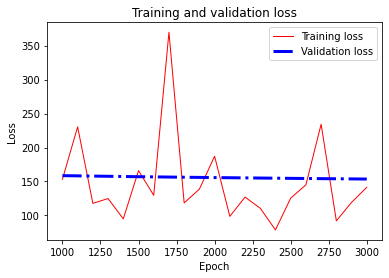

<Figure size 432x288 with 0 Axes>

Final Training loss: 141.483, Final Validation loss: 153.60422, Training RMSE: 12.253403, Validation RMSE: 12.393717
-------------------------------------------------------------------------------------


Fold 4, lr: 5e-05, batch_size: 64, number_epochs: 3000, type_loss_func: MSE, type_optimizer: Adagrad, neural_network_structure: multilayer_perceptron2
Epoch: 1000, Training loss: 2135.3672, Validation loss: 2044.821, 
Epoch: 2000, Training loss: 1883.524, Validation loss: 2011.2509, 
Epoch: 3000, Training loss: 1742.7292, Validation loss: 1985.7589, 
The total training time is: 11.691401000000042


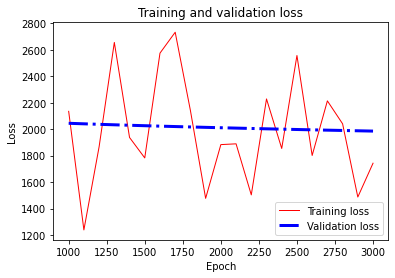

<Figure size 432x288 with 0 Axes>

Final Training loss: 1742.7292, Final Validation loss: 1985.7589, Training RMSE: 43.76115, Validation RMSE: 44.561855
-------------------------------------------------------------------------------------


Fold 5, lr: 5e-05, batch_size: 64, number_epochs: 3000, type_loss_func: MSE, type_optimizer: Adagrad, neural_network_structure: multilayer_perceptron2
Epoch: 1000, Training loss: 140.47035, Validation loss: 144.9053, 
Epoch: 2000, Training loss: 152.3609, Validation loss: 141.22662, 
Epoch: 3000, Training loss: 130.6631, Validation loss: 138.46915, 
The total training time is: 11.587062999999944


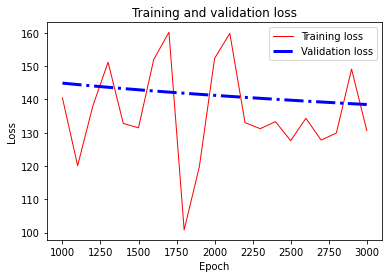

<Figure size 432x288 with 0 Axes>

Final Training loss: 130.6631, Final Validation loss: 138.46915, Training RMSE: 11.637936, Validation RMSE: 11.767291
-------------------------------------------------------------------------------------


Fold 6, lr: 5e-05, batch_size: 64, number_epochs: 3000, type_loss_func: MSE, type_optimizer: Adagrad, neural_network_structure: multilayer_perceptron2
Epoch: 1000, Training loss: 102.86247, Validation loss: 108.44122, 
Epoch: 2000, Training loss: 123.1391, Validation loss: 106.299194, 
Epoch: 3000, Training loss: 112.379166, Validation loss: 104.70276, 
The total training time is: 13.166895999999952


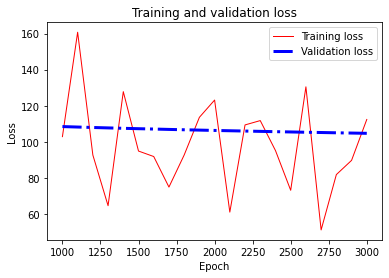

<Figure size 432x288 with 0 Axes>

Final Training loss: 112.379166, Final Validation loss: 104.70276, Training RMSE: 10.228618, Validation RMSE: 10.232436
-------------------------------------------------------------------------------------


Fold 7, lr: 5e-05, batch_size: 64, number_epochs: 3000, type_loss_func: MSE, type_optimizer: Adagrad, neural_network_structure: multilayer_perceptron2
Epoch: 1000, Training loss: 251.35413, Validation loss: 386.781, 
Epoch: 2000, Training loss: 199.42178, Validation loss: 380.44318, 
Epoch: 3000, Training loss: 252.59573, Validation loss: 375.68137, 
The total training time is: 11.497343


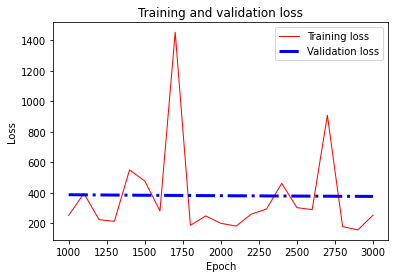

<Figure size 432x288 with 0 Axes>

Final Training loss: 252.59573, Final Validation loss: 375.68137, Training RMSE: 19.635183, Validation RMSE: 19.382502
-------------------------------------------------------------------------------------


Fold 8, lr: 5e-05, batch_size: 64, number_epochs: 3000, type_loss_func: MSE, type_optimizer: Adagrad, neural_network_structure: multilayer_perceptron2
Epoch: 1000, Training loss: 2648.4849, Validation loss: 2785.7798, 
Epoch: 2000, Training loss: 2732.5361, Validation loss: 2742.7754, 
Epoch: 3000, Training loss: 2223.9985, Validation loss: 2709.9414, 
The total training time is: 11.701178000000027


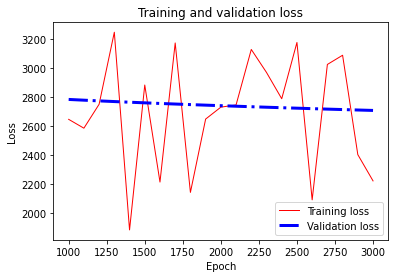

<Figure size 432x288 with 0 Axes>

Final Training loss: 2223.9985, Final Validation loss: 2709.9414, Training RMSE: 51.204185, Validation RMSE: 52.0571
-------------------------------------------------------------------------------------


Fold 9, lr: 5e-05, batch_size: 64, number_epochs: 3000, type_loss_func: MSE, type_optimizer: Adagrad, neural_network_structure: multilayer_perceptron2
Epoch: 1000, Training loss: 1002.9264, Validation loss: 1460.2034, 
Epoch: 2000, Training loss: 762.76495, Validation loss: 1442.7666, 
Epoch: 3000, Training loss: 747.53174, Validation loss: 1429.5607, 
The total training time is: 11.735138000000006


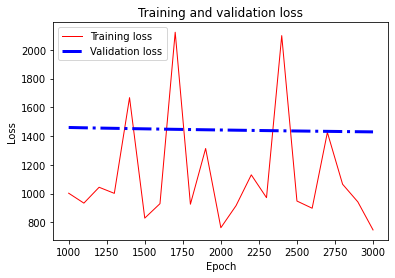

<Figure size 432x288 with 0 Axes>

Final Training loss: 747.53174, Final Validation loss: 1429.5607, Training RMSE: 35.521244, Validation RMSE: 37.809532
-------------------------------------------------------------------------------------


Fold 10, lr: 5e-05, batch_size: 64, number_epochs: 3000, type_loss_func: MSE, type_optimizer: Adagrad, neural_network_structure: multilayer_perceptron2
Epoch: 1000, Training loss: 350.57593, Validation loss: 358.32, 
Epoch: 2000, Training loss: 322.71973, Validation loss: 349.45688, 
Epoch: 3000, Training loss: 383.82916, Validation loss: 342.82693, 
The total training time is: 11.095671000000038


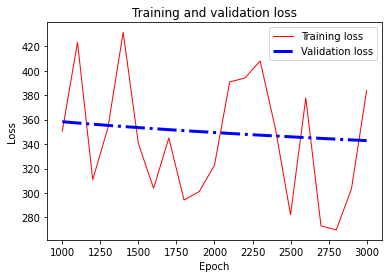

<Figure size 432x288 with 0 Axes>

Final Training loss: 383.82916, Final Validation loss: 342.82693, Training RMSE: 18.415724, Validation RMSE: 18.515587
-------------------------------------------------------------------------------------


For the model with learning rate: 5e-05, batch size: 64, number_epochs: 3000, type_optimizer: Adagrad, neural_network_structure: multilayer_perceptron2 

Average Training RMSE for the 10 folds: 10.750935 

Average Validation RMSE for the 10 folds: 10.7656145 


-------------------------------------------------------------------------------------


Fold 1, lr: 5e-05, batch_size: 64, number_epochs: 3000, type_loss_func: MSE, type_optimizer: Adagrad, neural_network_structure: multilayer_perceptron3
Epoch: 1000, Training loss: 617.3541, Validation loss: 617.20294, 
Epoch: 2000, Training loss: 517.9165, Validation loss: 600.1272, 
Epoch: 3000, Training loss: 501.1956, Validation loss: 587.33435, 
The total training time is: 12.504660999999942


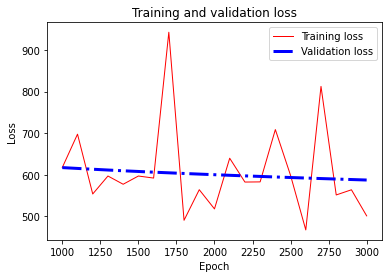

<Figure size 432x288 with 0 Axes>

Final Training loss: 501.1956, Final Validation loss: 587.33435, Training RMSE: 24.660164, Validation RMSE: 24.234982
-------------------------------------------------------------------------------------


Fold 2, lr: 5e-05, batch_size: 64, number_epochs: 3000, type_loss_func: MSE, type_optimizer: Adagrad, neural_network_structure: multilayer_perceptron3
Epoch: 1000, Training loss: 16372.99, Validation loss: 13992.491, 
Epoch: 2000, Training loss: 12564.59, Validation loss: 13732.415, 
Epoch: 3000, Training loss: 12502.56, Validation loss: 13535.238, 
The total training time is: 12.74940000000015


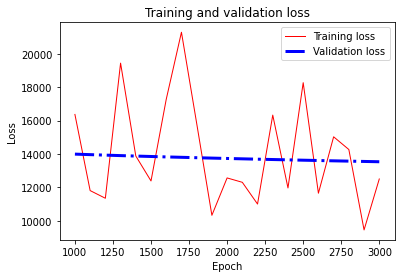

<Figure size 432x288 with 0 Axes>

Final Training loss: 12502.56, Final Validation loss: 13535.238, Training RMSE: 115.56624, Validation RMSE: 116.34104
-------------------------------------------------------------------------------------


Fold 3, lr: 5e-05, batch_size: 64, number_epochs: 3000, type_loss_func: MSE, type_optimizer: Adagrad, neural_network_structure: multilayer_perceptron3
Epoch: 1000, Training loss: 1171.8008, Validation loss: 957.97534, 
Epoch: 2000, Training loss: 968.6564, Validation loss: 936.8667, 
Epoch: 3000, Training loss: 801.37585, Validation loss: 920.9874, 
The total training time is: 12.305573999999979


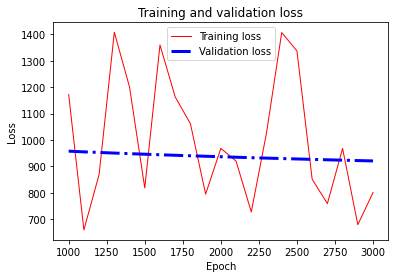

<Figure size 432x288 with 0 Axes>

Final Training loss: 801.37585, Final Validation loss: 920.9874, Training RMSE: 31.169147, Validation RMSE: 30.347775
-------------------------------------------------------------------------------------


Fold 4, lr: 5e-05, batch_size: 64, number_epochs: 3000, type_loss_func: MSE, type_optimizer: Adagrad, neural_network_structure: multilayer_perceptron3
Epoch: 1000, Training loss: 432.60956, Validation loss: 281.56366, 
Epoch: 2000, Training loss: 245.30515, Validation loss: 273.25293, 
Epoch: 3000, Training loss: 182.97485, Validation loss: 267.0149, 
The total training time is: 12.232242999999926


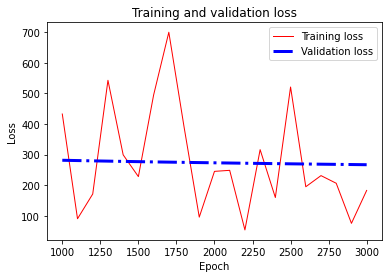

<Figure size 432x288 with 0 Axes>

Final Training loss: 182.97485, Final Validation loss: 267.0149, Training RMSE: 15.470637, Validation RMSE: 16.34059
-------------------------------------------------------------------------------------


Fold 5, lr: 5e-05, batch_size: 64, number_epochs: 3000, type_loss_func: MSE, type_optimizer: Adagrad, neural_network_structure: multilayer_perceptron3
Epoch: 1000, Training loss: 639.5185, Validation loss: 685.57776, 
Epoch: 2000, Training loss: 347.20233, Validation loss: 672.24426, 
Epoch: 3000, Training loss: 346.65393, Validation loss: 662.26483, 
The total training time is: 12.19728699999996


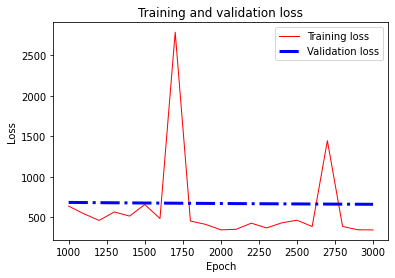

<Figure size 432x288 with 0 Axes>

Final Training loss: 346.65393, Final Validation loss: 662.26483, Training RMSE: 24.637033, Validation RMSE: 25.734507
-------------------------------------------------------------------------------------


Fold 6, lr: 5e-05, batch_size: 64, number_epochs: 3000, type_loss_func: MSE, type_optimizer: Adagrad, neural_network_structure: multilayer_perceptron3
Epoch: 1000, Training loss: 208.67686, Validation loss: 157.67398, 
Epoch: 2000, Training loss: 162.1384, Validation loss: 151.42982, 
Epoch: 3000, Training loss: 118.98272, Validation loss: 146.79572, 
The total training time is: 12.525724000000082


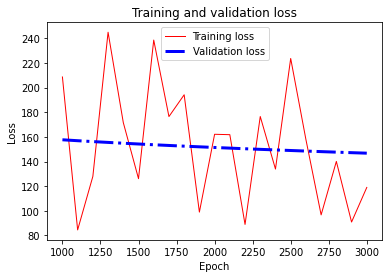

<Figure size 432x288 with 0 Axes>

Final Training loss: 118.98272, Final Validation loss: 146.79572, Training RMSE: 12.109694, Validation RMSE: 12.115928
-------------------------------------------------------------------------------------


Fold 7, lr: 5e-05, batch_size: 64, number_epochs: 3000, type_loss_func: MSE, type_optimizer: Adagrad, neural_network_structure: multilayer_perceptron3
Epoch: 1000, Training loss: 195.41956, Validation loss: 256.08472, 
Epoch: 2000, Training loss: 337.68622, Validation loss: 249.9185, 
Epoch: 3000, Training loss: 316.69836, Validation loss: 245.34993, 
The total training time is: 12.778791000000183


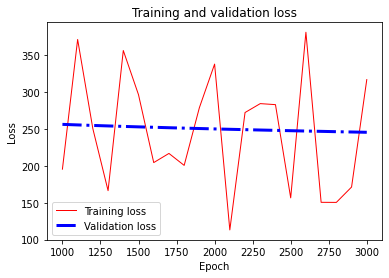

<Figure size 432x288 with 0 Axes>

Final Training loss: 316.69836, Final Validation loss: 245.34993, Training RMSE: 15.939899, Validation RMSE: 15.66365
-------------------------------------------------------------------------------------


Fold 8, lr: 5e-05, batch_size: 64, number_epochs: 3000, type_loss_func: MSE, type_optimizer: Adagrad, neural_network_structure: multilayer_perceptron3
Epoch: 1000, Training loss: 15200.709, Validation loss: 13010.261, 
Epoch: 2000, Training loss: 11386.799, Validation loss: 12806.3955, 
Epoch: 3000, Training loss: 8767.18, Validation loss: 12651.973, 
The total training time is: 12.757004999999936


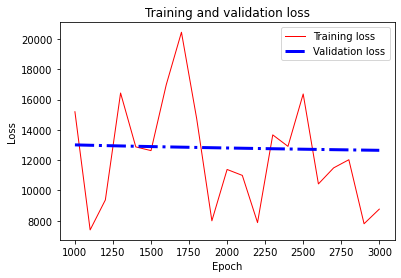

<Figure size 432x288 with 0 Axes>

Final Training loss: 8767.18, Final Validation loss: 12651.973, Training RMSE: 109.35504, Validation RMSE: 112.48099
-------------------------------------------------------------------------------------


Fold 9, lr: 5e-05, batch_size: 64, number_epochs: 3000, type_loss_func: MSE, type_optimizer: Adagrad, neural_network_structure: multilayer_perceptron3
Epoch: 1000, Training loss: 12967.142, Validation loss: 13765.276, 
Epoch: 2000, Training loss: 13219.5, Validation loss: 13515.294, 
Epoch: 3000, Training loss: 12788.613, Validation loss: 13327.095, 
The total training time is: 12.560387999999875


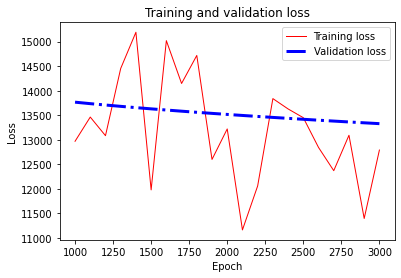

<Figure size 432x288 with 0 Axes>

Final Training loss: 12788.613, Final Validation loss: 13327.095, Training RMSE: 113.99241, Validation RMSE: 115.44304
-------------------------------------------------------------------------------------


Fold 10, lr: 5e-05, batch_size: 64, number_epochs: 3000, type_loss_func: MSE, type_optimizer: Adagrad, neural_network_structure: multilayer_perceptron3
Epoch: 1000, Training loss: 32.931763, Validation loss: 37.109303, 
Epoch: 2000, Training loss: 28.62622, Validation loss: 36.01795, 
Epoch: 3000, Training loss: 35.329727, Validation loss: 35.207104, 
The total training time is: 12.41050099999984


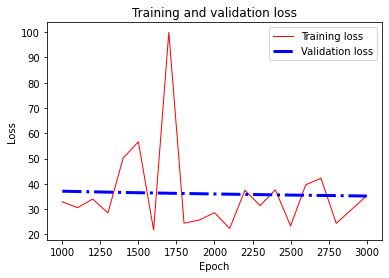

<Figure size 432x288 with 0 Axes>

Final Training loss: 35.329727, Final Validation loss: 35.207104, Training RMSE: 6.0151, Validation RMSE: 5.9335575
-------------------------------------------------------------------------------------


For the model with learning rate: 5e-05, batch size: 64, number_epochs: 3000, type_optimizer: Adagrad, neural_network_structure: multilayer_perceptron3 

Average Training RMSE for the 10 folds: 12.758747 

Average Validation RMSE for the 10 folds: 12.804392 


-------------------------------------------------------------------------------------


Fold 1, lr: 5e-05, batch_size: 64, number_epochs: 3000, type_loss_func: MAE, type_optimizer: GradientDescent, neural_network_structure: multilayer_perceptron1
Epoch: 1000, Training loss: 7.9257, Validation loss: 8.632017, 
Epoch: 2000, Training loss: 8.38616, Validation loss: 7.634491, 
Epoch: 3000, Training loss: 7.254179, Validation loss: 6.755287, 
The total training time is: 10.026840999999877


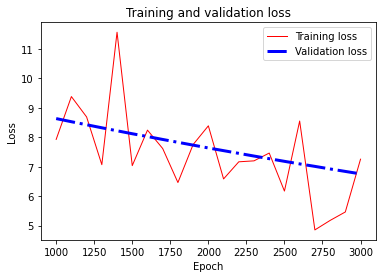

<Figure size 432x288 with 0 Axes>

Final Training loss: 7.254179, Final Validation loss: 6.755287, Training RMSE: 12.578049, Validation RMSE: 11.887198
-------------------------------------------------------------------------------------


Fold 2, lr: 5e-05, batch_size: 64, number_epochs: 3000, type_loss_func: MAE, type_optimizer: GradientDescent, neural_network_structure: multilayer_perceptron1
Epoch: 1000, Training loss: 6.200495, Validation loss: 6.215018, 
Epoch: 2000, Training loss: 5.550021, Validation loss: 5.5164523, 
Epoch: 3000, Training loss: 5.1944237, Validation loss: 4.8626056, 
The total training time is: 9.780264999999872


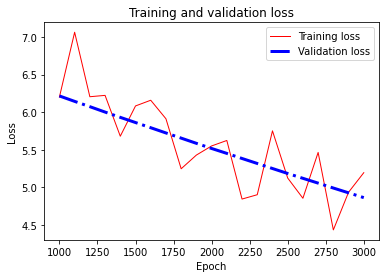

<Figure size 432x288 with 0 Axes>

Final Training loss: 5.1944237, Final Validation loss: 4.8626056, Training RMSE: 5.6929173, Validation RMSE: 5.7444024
-------------------------------------------------------------------------------------


Fold 3, lr: 5e-05, batch_size: 64, number_epochs: 3000, type_loss_func: MAE, type_optimizer: GradientDescent, neural_network_structure: multilayer_perceptron1
Epoch: 1000, Training loss: 6.2789974, Validation loss: 6.995658, 
Epoch: 2000, Training loss: 6.618874, Validation loss: 6.3473973, 
Epoch: 3000, Training loss: 5.73693, Validation loss: 5.7433667, 
The total training time is: 9.666756999999961


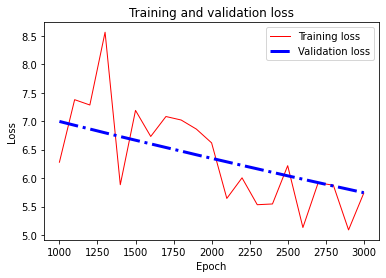

<Figure size 432x288 with 0 Axes>

Final Training loss: 5.73693, Final Validation loss: 5.7433667, Training RMSE: 7.652514, Validation RMSE: 7.6233253
-------------------------------------------------------------------------------------


Fold 4, lr: 5e-05, batch_size: 64, number_epochs: 3000, type_loss_func: MAE, type_optimizer: GradientDescent, neural_network_structure: multilayer_perceptron1
Epoch: 1000, Training loss: 5.756608, Validation loss: 5.785826, 
Epoch: 2000, Training loss: 3.7872794, Validation loss: 4.559017, 
Epoch: 3000, Training loss: 3.2585716, Validation loss: 3.5413826, 
The total training time is: 10.183669999999893


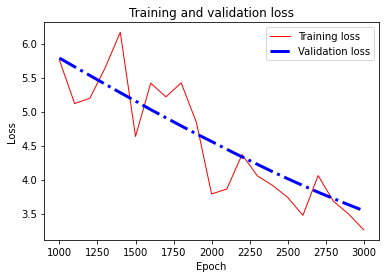

<Figure size 432x288 with 0 Axes>

Final Training loss: 3.2585716, Final Validation loss: 3.5413826, Training RMSE: 4.422904, Validation RMSE: 4.402635
-------------------------------------------------------------------------------------


Fold 5, lr: 5e-05, batch_size: 64, number_epochs: 3000, type_loss_func: MAE, type_optimizer: GradientDescent, neural_network_structure: multilayer_perceptron1
Epoch: 1000, Training loss: 3.3048167, Validation loss: 3.7636533, 
Epoch: 2000, Training loss: 2.620914, Validation loss: 3.4761713, 
Epoch: 3000, Training loss: 2.5726604, Validation loss: 3.2343493, 
The total training time is: 9.538442000000032


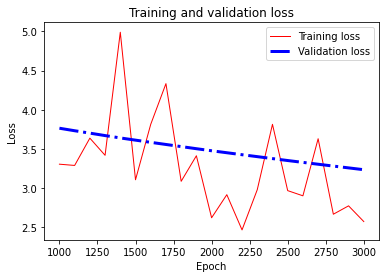

<Figure size 432x288 with 0 Axes>

Final Training loss: 2.5726604, Final Validation loss: 3.2343493, Training RMSE: 5.512845, Validation RMSE: 6.1168528
-------------------------------------------------------------------------------------


Fold 6, lr: 5e-05, batch_size: 64, number_epochs: 3000, type_loss_func: MAE, type_optimizer: GradientDescent, neural_network_structure: multilayer_perceptron1
Epoch: 1000, Training loss: 3.7110283, Validation loss: 3.834728, 
Epoch: 2000, Training loss: 3.275559, Validation loss: 3.2587447, 
Epoch: 3000, Training loss: 2.6072497, Validation loss: 2.8662617, 
The total training time is: 10.031008999999813


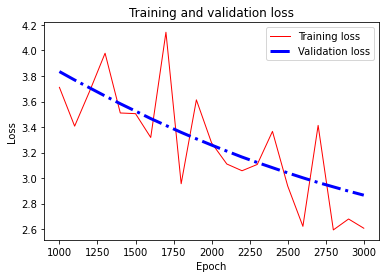

<Figure size 432x288 with 0 Axes>

Final Training loss: 2.6072497, Final Validation loss: 2.8662617, Training RMSE: 3.9203584, Validation RMSE: 3.9124036
-------------------------------------------------------------------------------------


Fold 7, lr: 5e-05, batch_size: 64, number_epochs: 3000, type_loss_func: MAE, type_optimizer: GradientDescent, neural_network_structure: multilayer_perceptron1
Epoch: 1000, Training loss: 6.010916, Validation loss: 5.695648, 
Epoch: 2000, Training loss: 5.0876493, Validation loss: 4.7619247, 
Epoch: 3000, Training loss: 4.317054, Validation loss: 4.284092, 
The total training time is: 9.992799000000105


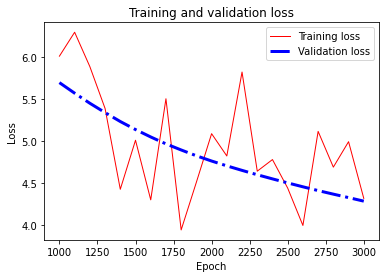

<Figure size 432x288 with 0 Axes>

Final Training loss: 4.317054, Final Validation loss: 4.284092, Training RMSE: 5.7218633, Validation RMSE: 5.670304
-------------------------------------------------------------------------------------


Fold 8, lr: 5e-05, batch_size: 64, number_epochs: 3000, type_loss_func: MAE, type_optimizer: GradientDescent, neural_network_structure: multilayer_perceptron1
Epoch: 1000, Training loss: 10.988271, Validation loss: 10.401022, 
Epoch: 2000, Training loss: 7.4103317, Validation loss: 8.559856, 
Epoch: 3000, Training loss: 6.6376867, Validation loss: 6.863267, 
The total training time is: 9.588680000000295


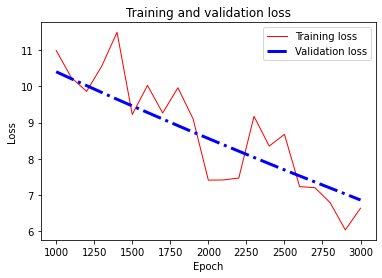

<Figure size 432x288 with 0 Axes>

Final Training loss: 6.6376867, Final Validation loss: 6.863267, Training RMSE: 8.733105, Validation RMSE: 8.689011
-------------------------------------------------------------------------------------


Fold 9, lr: 5e-05, batch_size: 64, number_epochs: 3000, type_loss_func: MAE, type_optimizer: GradientDescent, neural_network_structure: multilayer_perceptron1
Epoch: 1000, Training loss: 5.2014914, Validation loss: 5.024382, 
Epoch: 2000, Training loss: 4.908619, Validation loss: 4.4024863, 
Epoch: 3000, Training loss: 4.3390455, Validation loss: 3.8756397, 
The total training time is: 9.728860000000168


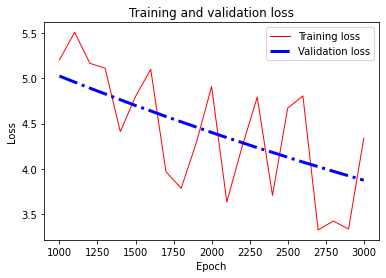

<Figure size 432x288 with 0 Axes>

Final Training loss: 4.3390455, Final Validation loss: 3.8756397, Training RMSE: 5.3815665, Validation RMSE: 5.488021
-------------------------------------------------------------------------------------


Fold 10, lr: 5e-05, batch_size: 64, number_epochs: 3000, type_loss_func: MAE, type_optimizer: GradientDescent, neural_network_structure: multilayer_perceptron1
Epoch: 1000, Training loss: 12.612671, Validation loss: 12.734099, 
Epoch: 2000, Training loss: 11.501034, Validation loss: 11.2090435, 
Epoch: 3000, Training loss: 9.837955, Validation loss: 9.778909, 
The total training time is: 9.572901999999885


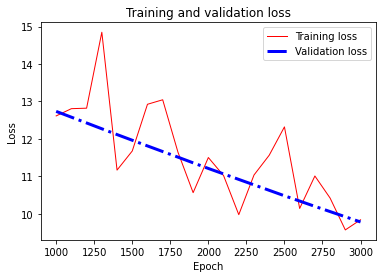

<Figure size 432x288 with 0 Axes>

Final Training loss: 9.837955, Final Validation loss: 9.778909, Training RMSE: 12.0555105, Validation RMSE: 11.925637
-------------------------------------------------------------------------------------


For the model with learning rate: 5e-05, batch size: 64, number_epochs: 3000, type_optimizer: GradientDescent, neural_network_structure: multilayer_perceptron1 

Average Training RMSE for the 10 folds: 12.464453 

Average Validation RMSE for the 10 folds: 12.506581 


-------------------------------------------------------------------------------------


Fold 1, lr: 5e-05, batch_size: 64, number_epochs: 3000, type_loss_func: MAE, type_optimizer: GradientDescent, neural_network_structure: multilayer_perceptron2
Epoch: 1000, Training loss: 3.120425, Validation loss: 3.538376, 
Epoch: 2000, Training loss: 2.1815321, Validation loss: 2.802172, 
Epoch: 3000, Training loss: 2.1691494, Validation loss: 2.457669, 
The total training time is: 12.046973999999864


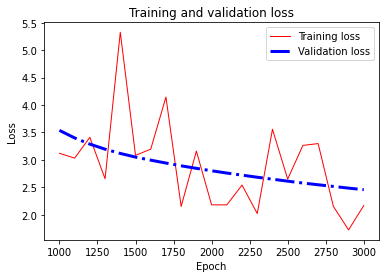

<Figure size 432x288 with 0 Axes>

Final Training loss: 2.1691494, Final Validation loss: 2.457669, Training RMSE: 7.039447, Validation RMSE: 6.0150065
-------------------------------------------------------------------------------------


Fold 2, lr: 5e-05, batch_size: 64, number_epochs: 3000, type_loss_func: MAE, type_optimizer: GradientDescent, neural_network_structure: multilayer_perceptron2
Epoch: 1000, Training loss: 5.2277994, Validation loss: 5.2338557, 
Epoch: 2000, Training loss: 3.6115918, Validation loss: 4.3950543, 
Epoch: 3000, Training loss: 3.0727592, Validation loss: 3.7366896, 
The total training time is: 11.876028000000133


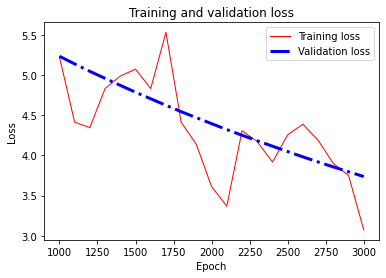

<Figure size 432x288 with 0 Axes>

Final Training loss: 3.0727592, Final Validation loss: 3.7366896, Training RMSE: 4.984614, Validation RMSE: 5.060218
-------------------------------------------------------------------------------------


Fold 3, lr: 5e-05, batch_size: 64, number_epochs: 3000, type_loss_func: MAE, type_optimizer: GradientDescent, neural_network_structure: multilayer_perceptron2
Epoch: 1000, Training loss: 7.4951067, Validation loss: 7.0941396, 
Epoch: 2000, Training loss: 5.2573714, Validation loss: 5.1082454, 
Epoch: 3000, Training loss: 3.485725, Validation loss: 4.320479, 
The total training time is: 12.144112999999834


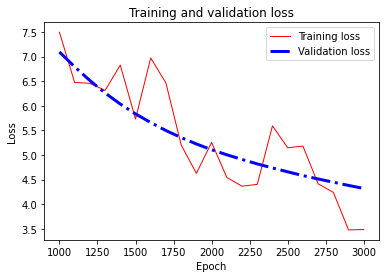

<Figure size 432x288 with 0 Axes>

Final Training loss: 3.485725, Final Validation loss: 4.320479, Training RMSE: 7.4196215, Validation RMSE: 7.08894
-------------------------------------------------------------------------------------


Fold 4, lr: 5e-05, batch_size: 64, number_epochs: 3000, type_loss_func: MAE, type_optimizer: GradientDescent, neural_network_structure: multilayer_perceptron2
Epoch: 1000, Training loss: 4.5862656, Validation loss: 6.040505, 
Epoch: 2000, Training loss: 4.775139, Validation loss: 4.5506845, 
Epoch: 3000, Training loss: 3.4873095, Validation loss: 3.6801624, 
The total training time is: 11.579548000000159


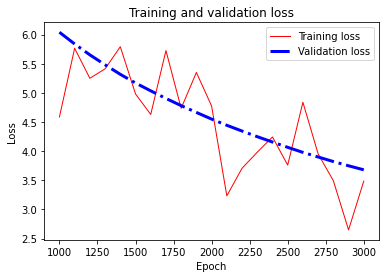

<Figure size 432x288 with 0 Axes>

Final Training loss: 3.4873095, Final Validation loss: 3.6801624, Training RMSE: 6.0858736, Validation RMSE: 6.315654
-------------------------------------------------------------------------------------


Fold 5, lr: 5e-05, batch_size: 64, number_epochs: 3000, type_loss_func: MAE, type_optimizer: GradientDescent, neural_network_structure: multilayer_perceptron2
Epoch: 1000, Training loss: 8.50288, Validation loss: 10.093461, 
Epoch: 2000, Training loss: 6.8975782, Validation loss: 7.260315, 
Epoch: 3000, Training loss: 4.1106606, Validation loss: 5.4412646, 
The total training time is: 12.445619000000079


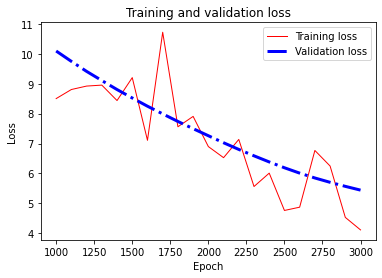

<Figure size 432x288 with 0 Axes>

Final Training loss: 4.1106606, Final Validation loss: 5.4412646, Training RMSE: 8.661171, Validation RMSE: 9.30227
-------------------------------------------------------------------------------------


Fold 6, lr: 5e-05, batch_size: 64, number_epochs: 3000, type_loss_func: MAE, type_optimizer: GradientDescent, neural_network_structure: multilayer_perceptron2
Epoch: 1000, Training loss: 13.675856, Validation loss: 14.389238, 
Epoch: 2000, Training loss: 6.5866995, Validation loss: 6.1204123, 
Epoch: 3000, Training loss: 3.7010834, Validation loss: 4.0660753, 
The total training time is: 13.655943000000207


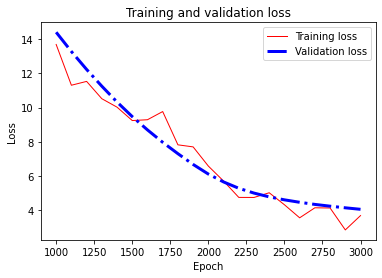

<Figure size 432x288 with 0 Axes>

Final Training loss: 3.7010834, Final Validation loss: 4.0660753, Training RMSE: 6.1567397, Validation RMSE: 6.080716
-------------------------------------------------------------------------------------


Fold 7, lr: 5e-05, batch_size: 64, number_epochs: 3000, type_loss_func: MAE, type_optimizer: GradientDescent, neural_network_structure: multilayer_perceptron2
Epoch: 1000, Training loss: 7.767967, Validation loss: 7.787868, 
Epoch: 2000, Training loss: 5.216151, Validation loss: 5.5094447, 
Epoch: 3000, Training loss: 3.0667925, Validation loss: 4.0921597, 
The total training time is: 12.074841000000106


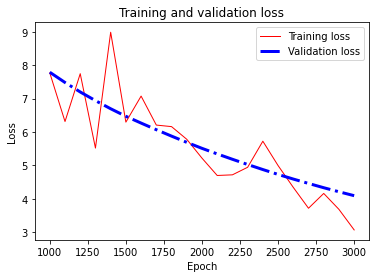

<Figure size 432x288 with 0 Axes>

Final Training loss: 3.0667925, Final Validation loss: 4.0921597, Training RMSE: 8.304335, Validation RMSE: 8.052108
-------------------------------------------------------------------------------------


Fold 8, lr: 5e-05, batch_size: 64, number_epochs: 3000, type_loss_func: MAE, type_optimizer: GradientDescent, neural_network_structure: multilayer_perceptron2
Epoch: 1000, Training loss: 5.779527, Validation loss: 7.0306063, 
Epoch: 2000, Training loss: 5.306223, Validation loss: 4.821332, 
Epoch: 3000, Training loss: 3.661818, Validation loss: 4.0805836, 
The total training time is: 12.11792400000013


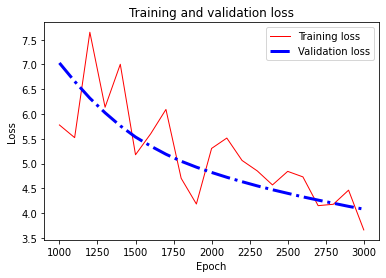

<Figure size 432x288 with 0 Axes>

Final Training loss: 3.661818, Final Validation loss: 4.0805836, Training RMSE: 5.6043925, Validation RMSE: 5.5316463
-------------------------------------------------------------------------------------


Fold 9, lr: 5e-05, batch_size: 64, number_epochs: 3000, type_loss_func: MAE, type_optimizer: GradientDescent, neural_network_structure: multilayer_perceptron2
Epoch: 1000, Training loss: 6.752322, Validation loss: 7.0735583, 
Epoch: 2000, Training loss: 4.8882923, Validation loss: 5.071796, 
Epoch: 3000, Training loss: 4.1345825, Validation loss: 4.1877418, 
The total training time is: 11.780201000000034


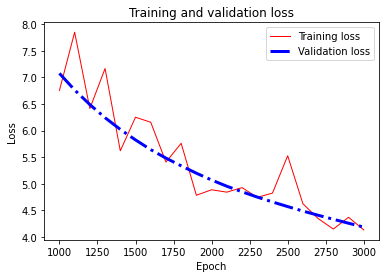

<Figure size 432x288 with 0 Axes>

Final Training loss: 4.1345825, Final Validation loss: 4.1877418, Training RMSE: 5.699044, Validation RMSE: 5.626376
-------------------------------------------------------------------------------------


Fold 10, lr: 5e-05, batch_size: 64, number_epochs: 3000, type_loss_func: MAE, type_optimizer: GradientDescent, neural_network_structure: multilayer_perceptron2
Epoch: 1000, Training loss: 3.729591, Validation loss: 4.4853716, 
Epoch: 2000, Training loss: 3.005352, Validation loss: 2.8612583, 
Epoch: 3000, Training loss: 2.6460695, Validation loss: 2.1626692, 
The total training time is: 12.422453000000132


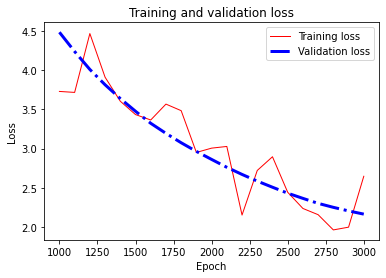

<Figure size 432x288 with 0 Axes>

Final Training loss: 2.6460695, Final Validation loss: 2.1626692, Training RMSE: 2.8385305, Validation RMSE: 2.7614677
-------------------------------------------------------------------------------------


For the model with learning rate: 5e-05, batch size: 64, number_epochs: 3000, type_optimizer: GradientDescent, neural_network_structure: multilayer_perceptron2 

Average Training RMSE for the 10 folds: 12.155198 

Average Validation RMSE for the 10 folds: 12.190425 


-------------------------------------------------------------------------------------


Fold 1, lr: 5e-05, batch_size: 64, number_epochs: 3000, type_loss_func: MAE, type_optimizer: GradientDescent, neural_network_structure: multilayer_perceptron3
Epoch: 1000, Training loss: 7.825376, Validation loss: 7.846566, 
Epoch: 2000, Training loss: 6.407446, Validation loss: 6.1265645, 
Epoch: 3000, Training loss: 5.200497, Validation loss: 5.2435985, 
The total training time is: 13.038892000000033


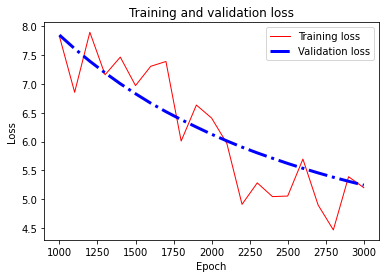

<Figure size 432x288 with 0 Axes>

Final Training loss: 5.200497, Final Validation loss: 5.2435985, Training RMSE: 6.314853, Validation RMSE: 6.301554
-------------------------------------------------------------------------------------


Fold 2, lr: 5e-05, batch_size: 64, number_epochs: 3000, type_loss_func: MAE, type_optimizer: GradientDescent, neural_network_structure: multilayer_perceptron3
Epoch: 1000, Training loss: 4.30462, Validation loss: 4.4039555, 
Epoch: 2000, Training loss: 2.995939, Validation loss: 2.883539, 
Epoch: 3000, Training loss: 2.3270106, Validation loss: 2.4697769, 
The total training time is: 12.867538999999852


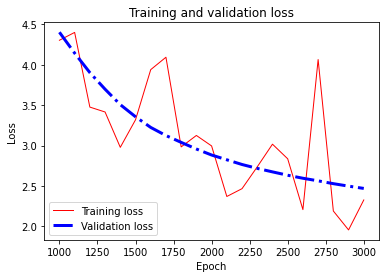

<Figure size 432x288 with 0 Axes>

Final Training loss: 2.3270106, Final Validation loss: 2.4697769, Training RMSE: 4.2216754, Validation RMSE: 4.339623
-------------------------------------------------------------------------------------


Fold 3, lr: 5e-05, batch_size: 64, number_epochs: 3000, type_loss_func: MAE, type_optimizer: GradientDescent, neural_network_structure: multilayer_perceptron3
Epoch: 1000, Training loss: 7.2378974, Validation loss: 7.6494274, 
Epoch: 2000, Training loss: 2.9418595, Validation loss: 3.764514, 
Epoch: 3000, Training loss: 2.6407354, Validation loss: 2.8249319, 
The total training time is: 13.068462000000181


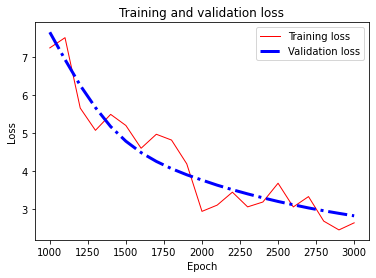

<Figure size 432x288 with 0 Axes>

Final Training loss: 2.6407354, Final Validation loss: 2.8249319, Training RMSE: 4.3576846, Validation RMSE: 4.4662266
-------------------------------------------------------------------------------------


Fold 4, lr: 5e-05, batch_size: 64, number_epochs: 3000, type_loss_func: MAE, type_optimizer: GradientDescent, neural_network_structure: multilayer_perceptron3
Epoch: 1000, Training loss: 4.616666, Validation loss: 4.959749, 
Epoch: 2000, Training loss: 3.882388, Validation loss: 3.780709, 
Epoch: 3000, Training loss: 3.1997108, Validation loss: 3.239119, 
The total training time is: 13.140704000000369


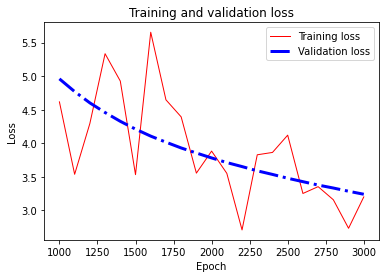

<Figure size 432x288 with 0 Axes>

Final Training loss: 3.1997108, Final Validation loss: 3.239119, Training RMSE: 5.0749125, Validation RMSE: 5.0189486
-------------------------------------------------------------------------------------


Fold 5, lr: 5e-05, batch_size: 64, number_epochs: 3000, type_loss_func: MAE, type_optimizer: GradientDescent, neural_network_structure: multilayer_perceptron3
Epoch: 1000, Training loss: 3.4602048, Validation loss: 3.1639187, 
Epoch: 2000, Training loss: 1.7847108, Validation loss: 2.4934711, 
Epoch: 3000, Training loss: 1.837955, Validation loss: 2.189606, 
The total training time is: 13.014165999999932


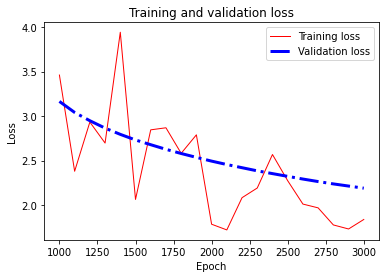

<Figure size 432x288 with 0 Axes>

Final Training loss: 1.837955, Final Validation loss: 2.189606, Training RMSE: 3.8436406, Validation RMSE: 4.108102
-------------------------------------------------------------------------------------


Fold 6, lr: 5e-05, batch_size: 64, number_epochs: 3000, type_loss_func: MAE, type_optimizer: GradientDescent, neural_network_structure: multilayer_perceptron3
Epoch: 1000, Training loss: 9.677584, Validation loss: 9.613767, 
Epoch: 2000, Training loss: 3.1374533, Validation loss: 2.9073133, 
Epoch: 3000, Training loss: 1.7986047, Validation loss: 2.1741378, 
The total training time is: 13.429693999999927


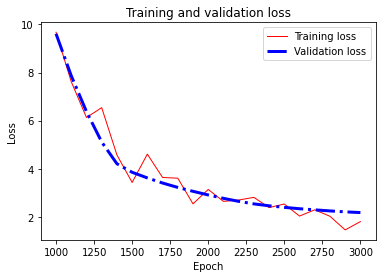

<Figure size 432x288 with 0 Axes>

Final Training loss: 1.7986047, Final Validation loss: 2.1741378, Training RMSE: 4.06431, Validation RMSE: 3.905546
-------------------------------------------------------------------------------------


Fold 7, lr: 5e-05, batch_size: 64, number_epochs: 3000, type_loss_func: MAE, type_optimizer: GradientDescent, neural_network_structure: multilayer_perceptron3
Epoch: 1000, Training loss: 5.974525, Validation loss: 6.118184, 
Epoch: 2000, Training loss: 4.101863, Validation loss: 4.032347, 
Epoch: 3000, Training loss: 3.2569866, Validation loss: 3.2652445, 
The total training time is: 13.471188999999868


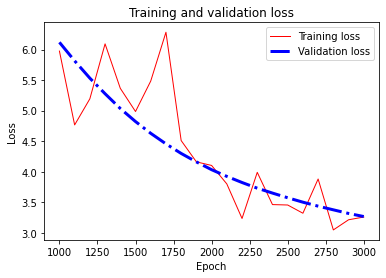

<Figure size 432x288 with 0 Axes>

Final Training loss: 3.2569866, Final Validation loss: 3.2652445, Training RMSE: 4.1634135, Validation RMSE: 4.080041
-------------------------------------------------------------------------------------


Fold 8, lr: 5e-05, batch_size: 64, number_epochs: 3000, type_loss_func: MAE, type_optimizer: GradientDescent, neural_network_structure: multilayer_perceptron3
Epoch: 1000, Training loss: 7.205068, Validation loss: 7.076562, 
Epoch: 2000, Training loss: 3.8818827, Validation loss: 4.12901, 
Epoch: 3000, Training loss: 3.5907416, Validation loss: 3.4214458, 
The total training time is: 12.994939000000159


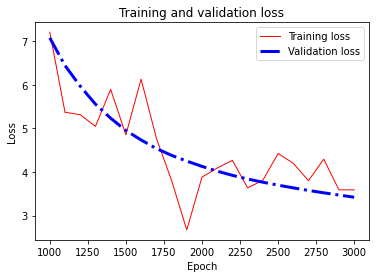

<Figure size 432x288 with 0 Axes>

Final Training loss: 3.5907416, Final Validation loss: 3.4214458, Training RMSE: 5.028899, Validation RMSE: 5.0056233
-------------------------------------------------------------------------------------


Fold 9, lr: 5e-05, batch_size: 64, number_epochs: 3000, type_loss_func: MAE, type_optimizer: GradientDescent, neural_network_structure: multilayer_perceptron3
Epoch: 1000, Training loss: 6.0309224, Validation loss: 6.5549417, 
Epoch: 2000, Training loss: 3.2630305, Validation loss: 3.8458352, 
Epoch: 3000, Training loss: 2.6092749, Validation loss: 3.0123696, 
The total training time is: 13.37227699999994


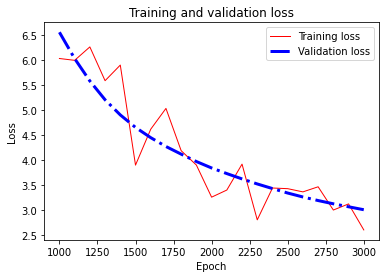

<Figure size 432x288 with 0 Axes>

Final Training loss: 2.6092749, Final Validation loss: 3.0123696, Training RMSE: 3.8551154, Validation RMSE: 3.9703767
-------------------------------------------------------------------------------------


Fold 10, lr: 5e-05, batch_size: 64, number_epochs: 3000, type_loss_func: MAE, type_optimizer: GradientDescent, neural_network_structure: multilayer_perceptron3
Epoch: 1000, Training loss: 4.4280415, Validation loss: 4.318243, 
Epoch: 2000, Training loss: 2.8730848, Validation loss: 3.0301504, 
Epoch: 3000, Training loss: 1.965652, Validation loss: 2.3990679, 
The total training time is: 12.799466999999822


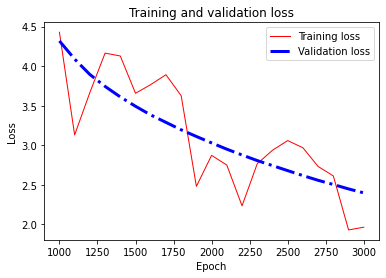

<Figure size 432x288 with 0 Axes>

Final Training loss: 1.965652, Final Validation loss: 2.3990679, Training RMSE: 3.9105256, Validation RMSE: 3.791351
-------------------------------------------------------------------------------------


For the model with learning rate: 5e-05, batch size: 64, number_epochs: 3000, type_optimizer: GradientDescent, neural_network_structure: multilayer_perceptron3 

Average Training RMSE for the 10 folds: 11.78988 

Average Validation RMSE for the 10 folds: 11.824154 


-------------------------------------------------------------------------------------


Fold 1, lr: 5e-05, batch_size: 64, number_epochs: 3000, type_loss_func: MAE, type_optimizer: Adagrad, neural_network_structure: multilayer_perceptron1
Epoch: 1000, Training loss: 5.7639694, Validation loss: 5.8295293, 
Epoch: 2000, Training loss: 5.966243, Validation loss: 5.7895317, 
Epoch: 3000, Training loss: 6.1209164, Validation loss: 5.7589836, 
The total training time is: 10.787128999999823


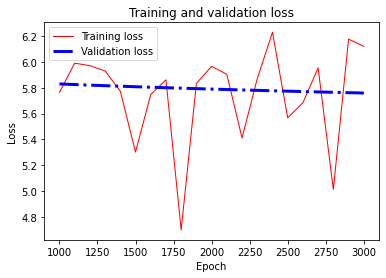

<Figure size 432x288 with 0 Axes>

Final Training loss: 6.1209164, Final Validation loss: 5.7589836, Training RMSE: 7.016543, Validation RMSE: 6.9279284
-------------------------------------------------------------------------------------


Fold 2, lr: 5e-05, batch_size: 64, number_epochs: 3000, type_loss_func: MAE, type_optimizer: Adagrad, neural_network_structure: multilayer_perceptron1
Epoch: 1000, Training loss: 9.714992, Validation loss: 9.209076, 
Epoch: 2000, Training loss: 8.60849, Validation loss: 9.149609, 
Epoch: 3000, Training loss: 8.521948, Validation loss: 9.104113, 
The total training time is: 10.416112999999768


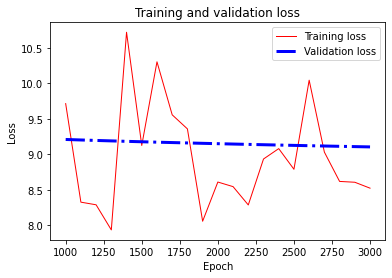

<Figure size 432x288 with 0 Axes>

Final Training loss: 8.521948, Final Validation loss: 9.104113, Training RMSE: 10.688432, Validation RMSE: 10.768481
-------------------------------------------------------------------------------------


Fold 3, lr: 5e-05, batch_size: 64, number_epochs: 3000, type_loss_func: MAE, type_optimizer: Adagrad, neural_network_structure: multilayer_perceptron1
Epoch: 1000, Training loss: 7.277506, Validation loss: 6.965424, 
Epoch: 2000, Training loss: 7.077721, Validation loss: 6.920872, 
Epoch: 3000, Training loss: 7.346358, Validation loss: 6.8867273, 
The total training time is: 10.778382999999849


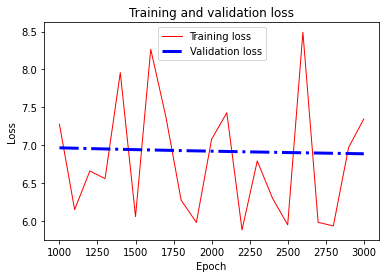

<Figure size 432x288 with 0 Axes>

Final Training loss: 7.346358, Final Validation loss: 6.8867273, Training RMSE: 9.134708, Validation RMSE: 9.0769205
-------------------------------------------------------------------------------------


Fold 4, lr: 5e-05, batch_size: 64, number_epochs: 3000, type_loss_func: MAE, type_optimizer: Adagrad, neural_network_structure: multilayer_perceptron1
Epoch: 1000, Training loss: 8.38829, Validation loss: 8.616319, 
Epoch: 2000, Training loss: 9.611453, Validation loss: 8.572747, 
Epoch: 3000, Training loss: 7.9531255, Validation loss: 8.539418, 
The total training time is: 10.316909000000123


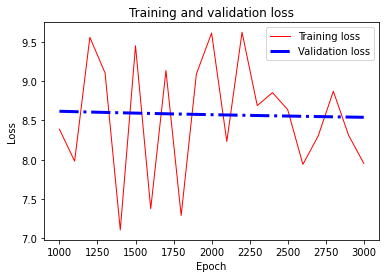

<Figure size 432x288 with 0 Axes>

Final Training loss: 7.9531255, Final Validation loss: 8.539418, Training RMSE: 10.674312, Validation RMSE: 10.562645
-------------------------------------------------------------------------------------


Fold 5, lr: 5e-05, batch_size: 64, number_epochs: 3000, type_loss_func: MAE, type_optimizer: Adagrad, neural_network_structure: multilayer_perceptron1
Epoch: 1000, Training loss: 5.363467, Validation loss: 5.57334, 
Epoch: 2000, Training loss: 5.143551, Validation loss: 5.53954, 
Epoch: 3000, Training loss: 5.6390305, Validation loss: 5.513728, 
The total training time is: 10.980537999999797


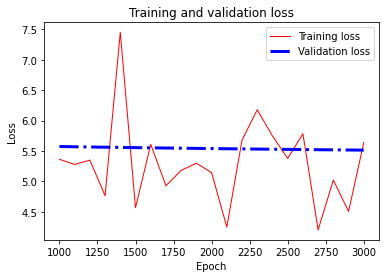

<Figure size 432x288 with 0 Axes>

Final Training loss: 5.6390305, Final Validation loss: 5.513728, Training RMSE: 8.353762, Validation RMSE: 8.894422
-------------------------------------------------------------------------------------


Fold 6, lr: 5e-05, batch_size: 64, number_epochs: 3000, type_loss_func: MAE, type_optimizer: Adagrad, neural_network_structure: multilayer_perceptron1
Epoch: 1000, Training loss: 10.488234, Validation loss: 11.851805, 
Epoch: 2000, Training loss: 12.418575, Validation loss: 11.794735, 
Epoch: 3000, Training loss: 11.250296, Validation loss: 11.751, 
The total training time is: 10.683835000000272


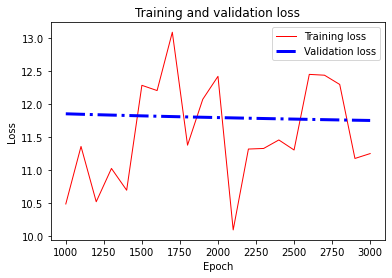

<Figure size 432x288 with 0 Axes>

Final Training loss: 11.250296, Final Validation loss: 11.751, Training RMSE: 13.661247, Validation RMSE: 13.768937
-------------------------------------------------------------------------------------


Fold 7, lr: 5e-05, batch_size: 64, number_epochs: 3000, type_loss_func: MAE, type_optimizer: Adagrad, neural_network_structure: multilayer_perceptron1
Epoch: 1000, Training loss: 5.4433155, Validation loss: 6.606366, 
Epoch: 2000, Training loss: 6.8115845, Validation loss: 6.564089, 
Epoch: 3000, Training loss: 6.6877565, Validation loss: 6.531722, 
The total training time is: 10.671077999999852


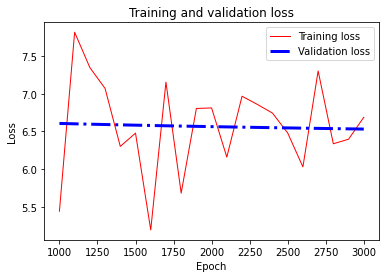

<Figure size 432x288 with 0 Axes>

Final Training loss: 6.6877565, Final Validation loss: 6.531722, Training RMSE: 8.58489, Validation RMSE: 8.653344
-------------------------------------------------------------------------------------


Fold 8, lr: 5e-05, batch_size: 64, number_epochs: 3000, type_loss_func: MAE, type_optimizer: Adagrad, neural_network_structure: multilayer_perceptron1
Epoch: 1000, Training loss: 5.1958714, Validation loss: 5.430196, 
Epoch: 2000, Training loss: 5.5736637, Validation loss: 5.3920107, 
Epoch: 3000, Training loss: 4.856357, Validation loss: 5.3632326, 
The total training time is: 11.094211000000087


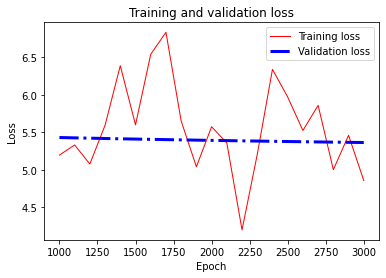

<Figure size 432x288 with 0 Axes>

Final Training loss: 4.856357, Final Validation loss: 5.3632326, Training RMSE: 7.9170547, Validation RMSE: 7.996302
-------------------------------------------------------------------------------------


Fold 9, lr: 5e-05, batch_size: 64, number_epochs: 3000, type_loss_func: MAE, type_optimizer: Adagrad, neural_network_structure: multilayer_perceptron1
Epoch: 1000, Training loss: 10.67923, Validation loss: 9.9574175, 
Epoch: 2000, Training loss: 9.434905, Validation loss: 9.915916, 
Epoch: 3000, Training loss: 9.564449, Validation loss: 9.884188, 
The total training time is: 10.939796999999999


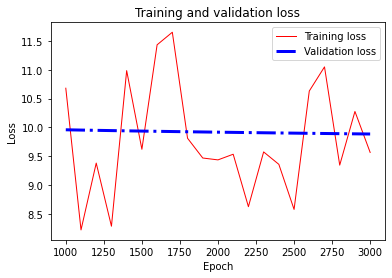

<Figure size 432x288 with 0 Axes>

Final Training loss: 9.564449, Final Validation loss: 9.884188, Training RMSE: 12.278817, Validation RMSE: 11.875732
-------------------------------------------------------------------------------------


Fold 10, lr: 5e-05, batch_size: 64, number_epochs: 3000, type_loss_func: MAE, type_optimizer: Adagrad, neural_network_structure: multilayer_perceptron1
Epoch: 1000, Training loss: 7.3945093, Validation loss: 7.506426, 
Epoch: 2000, Training loss: 6.684269, Validation loss: 7.4629364, 
Epoch: 3000, Training loss: 6.727065, Validation loss: 7.42957, 
The total training time is: 11.206030999999712


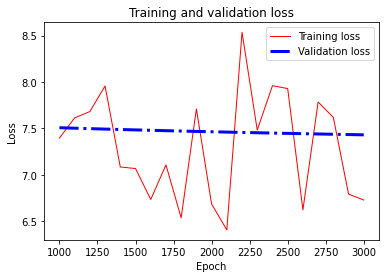

<Figure size 432x288 with 0 Axes>

Final Training loss: 6.727065, Final Validation loss: 7.42957, Training RMSE: 9.553091, Validation RMSE: 9.652881
-------------------------------------------------------------------------------------


For the model with learning rate: 5e-05, batch size: 64, number_epochs: 3000, type_optimizer: Adagrad, neural_network_structure: multilayer_perceptron1 

Average Training RMSE for the 10 folds: 11.698808 

Average Validation RMSE for the 10 folds: 11.732955 


-------------------------------------------------------------------------------------


Fold 1, lr: 5e-05, batch_size: 64, number_epochs: 3000, type_loss_func: MAE, type_optimizer: Adagrad, neural_network_structure: multilayer_perceptron2
Epoch: 1000, Training loss: 10.136141, Validation loss: 10.533042, 
Epoch: 2000, Training loss: 9.6765175, Validation loss: 10.396343, 
Epoch: 3000, Training loss: 10.766556, Validation loss: 10.292077, 
The total training time is: 12.982968000000255


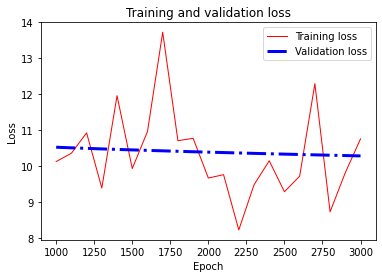

<Figure size 432x288 with 0 Axes>

Final Training loss: 10.766556, Final Validation loss: 10.292077, Training RMSE: 14.095044, Validation RMSE: 13.659824
-------------------------------------------------------------------------------------


Fold 2, lr: 5e-05, batch_size: 64, number_epochs: 3000, type_loss_func: MAE, type_optimizer: Adagrad, neural_network_structure: multilayer_perceptron2
Epoch: 1000, Training loss: 20.179672, Validation loss: 20.784018, 
Epoch: 2000, Training loss: 21.93187, Validation loss: 20.54117, 
Epoch: 3000, Training loss: 17.494835, Validation loss: 20.355997, 
The total training time is: 13.143329999999878


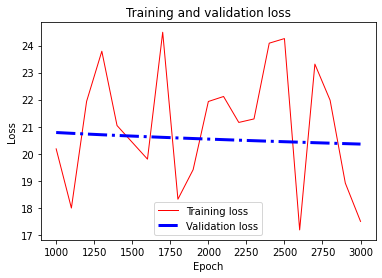

<Figure size 432x288 with 0 Axes>

Final Training loss: 17.494835, Final Validation loss: 20.355997, Training RMSE: 25.304857, Validation RMSE: 25.452019
-------------------------------------------------------------------------------------


Fold 3, lr: 5e-05, batch_size: 64, number_epochs: 3000, type_loss_func: MAE, type_optimizer: Adagrad, neural_network_structure: multilayer_perceptron2
Epoch: 1000, Training loss: 4.526041, Validation loss: 4.6004066, 
Epoch: 2000, Training loss: 3.8727202, Validation loss: 4.5295753, 
Epoch: 3000, Training loss: 3.8223486, Validation loss: 4.476246, 
The total training time is: 14.89578500000016


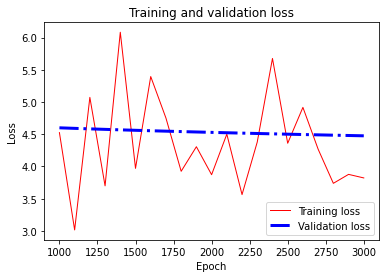

<Figure size 432x288 with 0 Axes>

Final Training loss: 3.8223486, Final Validation loss: 4.476246, Training RMSE: 8.072338, Validation RMSE: 7.427461
-------------------------------------------------------------------------------------


Fold 4, lr: 5e-05, batch_size: 64, number_epochs: 3000, type_loss_func: MAE, type_optimizer: Adagrad, neural_network_structure: multilayer_perceptron2
Epoch: 1000, Training loss: 23.504892, Validation loss: 23.620356, 
Epoch: 2000, Training loss: 22.296635, Validation loss: 23.277718, 
Epoch: 3000, Training loss: 21.152119, Validation loss: 23.018595, 
The total training time is: 13.363448999999946


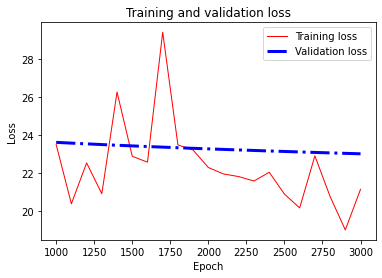

<Figure size 432x288 with 0 Axes>

Final Training loss: 21.152119, Final Validation loss: 23.018595, Training RMSE: 30.348734, Validation RMSE: 31.299007
-------------------------------------------------------------------------------------


Fold 5, lr: 5e-05, batch_size: 64, number_epochs: 3000, type_loss_func: MAE, type_optimizer: Adagrad, neural_network_structure: multilayer_perceptron2
Epoch: 1000, Training loss: 26.737267, Validation loss: 25.836445, 
Epoch: 2000, Training loss: 22.76221, Validation loss: 25.569267, 
Epoch: 3000, Training loss: 22.947449, Validation loss: 25.365974, 
The total training time is: 12.735520000000179


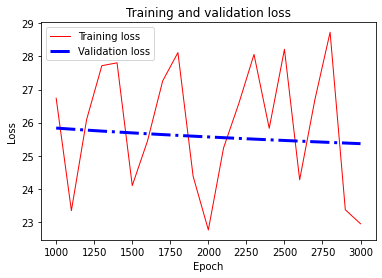

<Figure size 432x288 with 0 Axes>

Final Training loss: 22.947449, Final Validation loss: 25.365974, Training RMSE: 32.45276, Validation RMSE: 32.931618
-------------------------------------------------------------------------------------


Fold 6, lr: 5e-05, batch_size: 64, number_epochs: 3000, type_loss_func: MAE, type_optimizer: Adagrad, neural_network_structure: multilayer_perceptron2
Epoch: 1000, Training loss: 12.386662, Validation loss: 13.142183, 
Epoch: 2000, Training loss: 13.184982, Validation loss: 12.9503355, 
Epoch: 3000, Training loss: 13.610026, Validation loss: 12.803674, 
The total training time is: 14.755016999999953


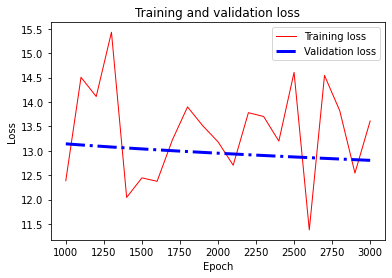

<Figure size 432x288 with 0 Axes>

Final Training loss: 13.610026, Final Validation loss: 12.803674, Training RMSE: 15.393132, Validation RMSE: 15.283758
-------------------------------------------------------------------------------------


Fold 7, lr: 5e-05, batch_size: 64, number_epochs: 3000, type_loss_func: MAE, type_optimizer: Adagrad, neural_network_structure: multilayer_perceptron2
Epoch: 1000, Training loss: 13.952639, Validation loss: 11.780416, 
Epoch: 2000, Training loss: 12.280251, Validation loss: 11.673386, 
Epoch: 3000, Training loss: 13.039361, Validation loss: 11.592236, 
The total training time is: 12.781324999999924


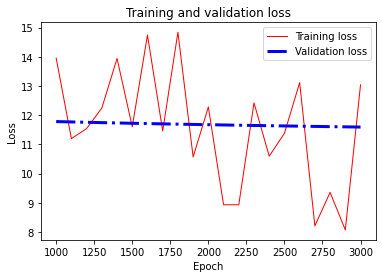

<Figure size 432x288 with 0 Axes>

Final Training loss: 13.039361, Final Validation loss: 11.592236, Training RMSE: 20.941727, Validation RMSE: 20.933535
-------------------------------------------------------------------------------------


Fold 8, lr: 5e-05, batch_size: 64, number_epochs: 3000, type_loss_func: MAE, type_optimizer: Adagrad, neural_network_structure: multilayer_perceptron2
Epoch: 1000, Training loss: 9.36825, Validation loss: 9.986809, 
Epoch: 2000, Training loss: 10.126176, Validation loss: 9.824844, 
Epoch: 3000, Training loss: 8.834726, Validation loss: 9.701686, 
The total training time is: 13.160178000000087


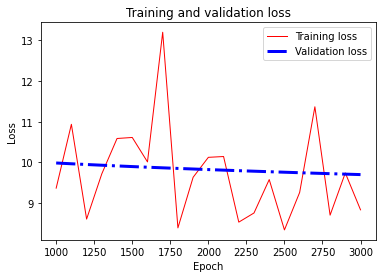

<Figure size 432x288 with 0 Axes>

Final Training loss: 8.834726, Final Validation loss: 9.701686, Training RMSE: 13.169326, Validation RMSE: 13.07385
-------------------------------------------------------------------------------------


Fold 9, lr: 5e-05, batch_size: 64, number_epochs: 3000, type_loss_func: MAE, type_optimizer: Adagrad, neural_network_structure: multilayer_perceptron2
Epoch: 1000, Training loss: 8.063936, Validation loss: 7.5163474, 
Epoch: 2000, Training loss: 7.0872364, Validation loss: 7.4030557, 
Epoch: 3000, Training loss: 7.5112805, Validation loss: 7.316778, 
The total training time is: 13.916519000000335


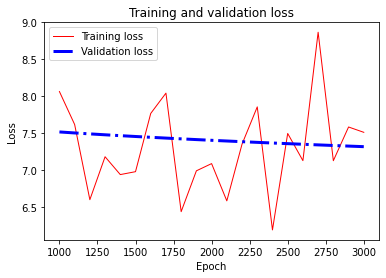

<Figure size 432x288 with 0 Axes>

Final Training loss: 7.5112805, Final Validation loss: 7.316778, Training RMSE: 9.128663, Validation RMSE: 8.938794
-------------------------------------------------------------------------------------


Fold 10, lr: 5e-05, batch_size: 64, number_epochs: 3000, type_loss_func: MAE, type_optimizer: Adagrad, neural_network_structure: multilayer_perceptron2
Epoch: 1000, Training loss: 9.54225, Validation loss: 8.688234, 
Epoch: 2000, Training loss: 8.223132, Validation loss: 8.545209, 
Epoch: 3000, Training loss: 8.879213, Validation loss: 8.436283, 
The total training time is: 13.11996900000031


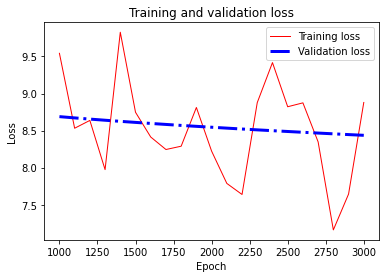

<Figure size 432x288 with 0 Axes>

Final Training loss: 8.879213, Final Validation loss: 8.436283, Training RMSE: 10.871915, Validation RMSE: 10.73683
-------------------------------------------------------------------------------------


For the model with learning rate: 5e-05, batch size: 64, number_epochs: 3000, type_optimizer: Adagrad, neural_network_structure: multilayer_perceptron2 

Average Training RMSE for the 10 folds: 11.971809 

Average Validation RMSE for the 10 folds: 12.004291 


-------------------------------------------------------------------------------------


Fold 1, lr: 5e-05, batch_size: 64, number_epochs: 3000, type_loss_func: MAE, type_optimizer: Adagrad, neural_network_structure: multilayer_perceptron3
Epoch: 1000, Training loss: 30.583221, Validation loss: 29.471733, 
Epoch: 2000, Training loss: 27.35798, Validation loss: 29.064535, 
Epoch: 3000, Training loss: 29.295353, Validation loss: 28.757948, 
The total training time is: 14.02741100000003


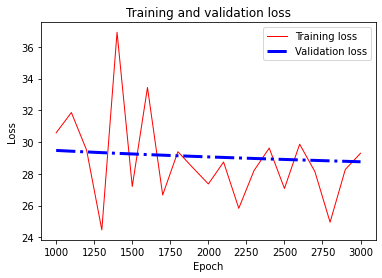

<Figure size 432x288 with 0 Axes>

Final Training loss: 29.295353, Final Validation loss: 28.757948, Training RMSE: 34.231846, Validation RMSE: 33.996597
-------------------------------------------------------------------------------------


Fold 2, lr: 5e-05, batch_size: 64, number_epochs: 3000, type_loss_func: MAE, type_optimizer: Adagrad, neural_network_structure: multilayer_perceptron3
Epoch: 1000, Training loss: 11.250306, Validation loss: 10.194038, 
Epoch: 2000, Training loss: 9.127367, Validation loss: 9.983827, 
Epoch: 3000, Training loss: 9.631645, Validation loss: 9.823815, 
The total training time is: 13.881647000000157


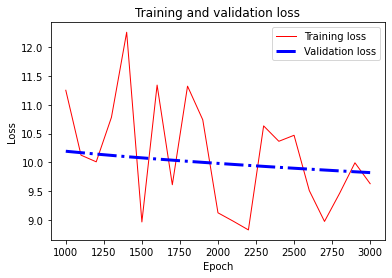

<Figure size 432x288 with 0 Axes>

Final Training loss: 9.631645, Final Validation loss: 9.823815, Training RMSE: 12.880941, Validation RMSE: 12.676769
-------------------------------------------------------------------------------------


Fold 3, lr: 5e-05, batch_size: 64, number_epochs: 3000, type_loss_func: MAE, type_optimizer: Adagrad, neural_network_structure: multilayer_perceptron3
Epoch: 1000, Training loss: 34.479813, Validation loss: 32.68071, 
Epoch: 2000, Training loss: 35.820328, Validation loss: 32.18113, 
Epoch: 3000, Training loss: 28.54291, Validation loss: 31.802275, 
The total training time is: 14.308308000000125


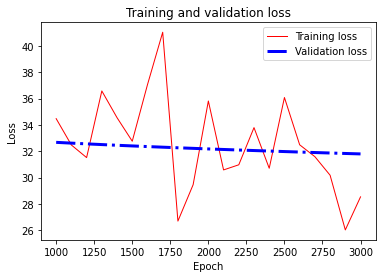

<Figure size 432x288 with 0 Axes>

Final Training loss: 28.54291, Final Validation loss: 31.802275, Training RMSE: 50.822735, Validation RMSE: 49.05967
-------------------------------------------------------------------------------------


Fold 4, lr: 5e-05, batch_size: 64, number_epochs: 3000, type_loss_func: MAE, type_optimizer: Adagrad, neural_network_structure: multilayer_perceptron3
Epoch: 1000, Training loss: 8.693224, Validation loss: 9.28996, 
Epoch: 2000, Training loss: 8.540362, Validation loss: 9.131598, 
Epoch: 3000, Training loss: 6.4567475, Validation loss: 9.011933, 
The total training time is: 13.97853299999997


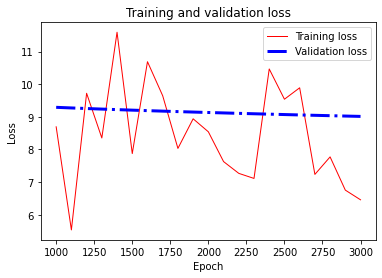

<Figure size 432x288 with 0 Axes>

Final Training loss: 6.4567475, Final Validation loss: 9.011933, Training RMSE: 18.081778, Validation RMSE: 18.579636
-------------------------------------------------------------------------------------


Fold 5, lr: 5e-05, batch_size: 64, number_epochs: 3000, type_loss_func: MAE, type_optimizer: Adagrad, neural_network_structure: multilayer_perceptron3
Epoch: 1000, Training loss: 12.694757, Validation loss: 11.135873, 
Epoch: 2000, Training loss: 10.516504, Validation loss: 10.913983, 
Epoch: 3000, Training loss: 9.7640705, Validation loss: 10.745101, 
The total training time is: 14.007105000000138


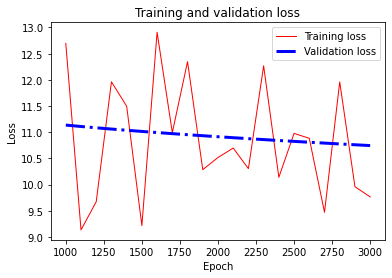

<Figure size 432x288 with 0 Axes>

Final Training loss: 9.7640705, Final Validation loss: 10.745101, Training RMSE: 13.799742, Validation RMSE: 13.756362
-------------------------------------------------------------------------------------


Fold 6, lr: 5e-05, batch_size: 64, number_epochs: 3000, type_loss_func: MAE, type_optimizer: Adagrad, neural_network_structure: multilayer_perceptron3
Epoch: 1000, Training loss: 12.5092535, Validation loss: 13.301347, 
Epoch: 2000, Training loss: 11.9790325, Validation loss: 12.969336, 
Epoch: 3000, Training loss: 12.775488, Validation loss: 12.717684, 
The total training time is: 13.873507999999674


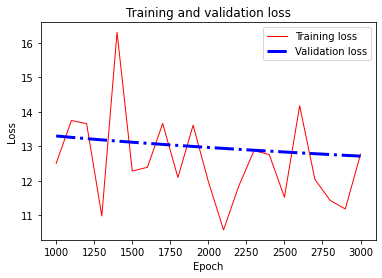

<Figure size 432x288 with 0 Axes>

Final Training loss: 12.775488, Final Validation loss: 12.717684, Training RMSE: 17.831797, Validation RMSE: 17.758419
-------------------------------------------------------------------------------------


Fold 7, lr: 5e-05, batch_size: 64, number_epochs: 3000, type_loss_func: MAE, type_optimizer: Adagrad, neural_network_structure: multilayer_perceptron3
Epoch: 1000, Training loss: 22.48987, Validation loss: 22.287798, 
Epoch: 2000, Training loss: 20.561724, Validation loss: 22.013798, 
Epoch: 3000, Training loss: 21.98373, Validation loss: 21.80552, 
The total training time is: 13.950862000000143


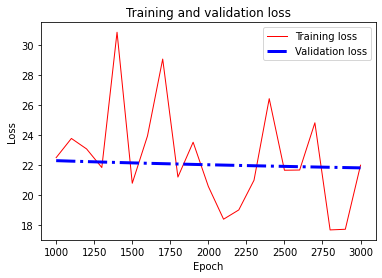

<Figure size 432x288 with 0 Axes>

Final Training loss: 21.98373, Final Validation loss: 21.80552, Training RMSE: 42.29566, Validation RMSE: 40.840076
-------------------------------------------------------------------------------------


Fold 8, lr: 5e-05, batch_size: 64, number_epochs: 3000, type_loss_func: MAE, type_optimizer: Adagrad, neural_network_structure: multilayer_perceptron3
Epoch: 1000, Training loss: 30.503128, Validation loss: 33.713184, 
Epoch: 2000, Training loss: 32.944702, Validation loss: 33.278767, 
Epoch: 3000, Training loss: 31.451805, Validation loss: 32.94861, 
The total training time is: 13.972037


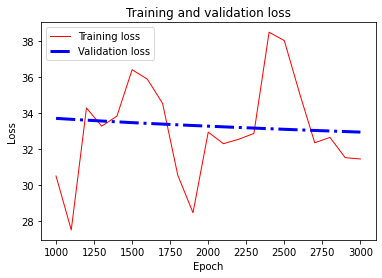

<Figure size 432x288 with 0 Axes>

Final Training loss: 31.451805, Final Validation loss: 32.94861, Training RMSE: 43.56228, Validation RMSE: 43.408493
-------------------------------------------------------------------------------------


Fold 9, lr: 5e-05, batch_size: 64, number_epochs: 3000, type_loss_func: MAE, type_optimizer: Adagrad, neural_network_structure: multilayer_perceptron3
Epoch: 1000, Training loss: 3.6948988, Validation loss: 3.7421613, 
Epoch: 2000, Training loss: 3.2803984, Validation loss: 3.6399338, 
Epoch: 3000, Training loss: 2.8419342, Validation loss: 3.5640538, 
The total training time is: 14.503309999999601


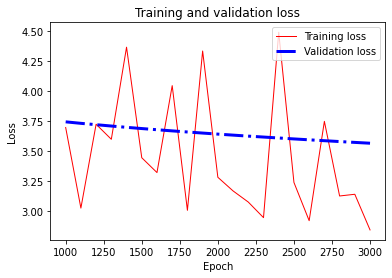

<Figure size 432x288 with 0 Axes>

Final Training loss: 2.8419342, Final Validation loss: 3.5640538, Training RMSE: 5.6565905, Validation RMSE: 6.6060433
-------------------------------------------------------------------------------------


Fold 10, lr: 5e-05, batch_size: 64, number_epochs: 3000, type_loss_func: MAE, type_optimizer: Adagrad, neural_network_structure: multilayer_perceptron3
Epoch: 1000, Training loss: 21.320507, Validation loss: 21.434835, 
Epoch: 2000, Training loss: 19.392675, Validation loss: 21.183481, 
Epoch: 3000, Training loss: 19.704773, Validation loss: 20.99309, 
The total training time is: 14.211138000000119


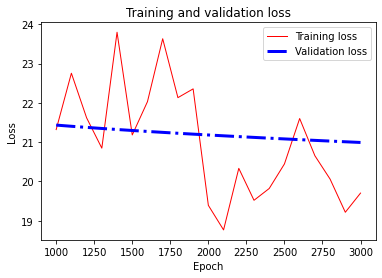

<Figure size 432x288 with 0 Axes>

Final Training loss: 19.704773, Final Validation loss: 20.99309, Training RMSE: 24.423029, Validation RMSE: 23.943861
-------------------------------------------------------------------------------------


For the model with learning rate: 5e-05, batch size: 64, number_epochs: 3000, type_optimizer: Adagrad, neural_network_structure: multilayer_perceptron3 

Average Training RMSE for the 10 folds: 12.57126 

Average Validation RMSE for the 10 folds: 12.590053 


-------------------------------------------------------------------------------------


Fold 1, lr: 5e-05, batch_size: 64, number_epochs: 4000, type_loss_func: MSE, type_optimizer: GradientDescent, neural_network_structure: multilayer_perceptron1
Epoch: 1000, Training loss: 5.595275, Validation loss: 7.7852583, 
Epoch: 2000, Training loss: 2.1826723, Validation loss: 3.305514, 
Epoch: 3000, Training loss: 2.777936, Validation loss: 2.3705943, 
Epoch: 4000, Training loss: 1.9348505, Validation loss: 2.047265, 
The total training 

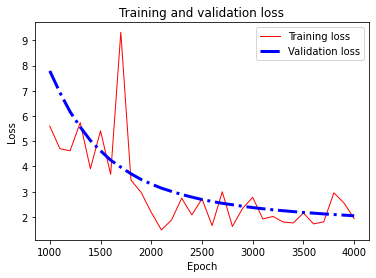

<Figure size 432x288 with 0 Axes>

Final Training loss: 1.9348505, Final Validation loss: 2.047265, Training RMSE: 1.4195726, Validation RMSE: 1.4308267
-------------------------------------------------------------------------------------


Fold 2, lr: 5e-05, batch_size: 64, number_epochs: 4000, type_loss_func: MSE, type_optimizer: GradientDescent, neural_network_structure: multilayer_perceptron1
Epoch: 1000, Training loss: 3.2358017, Validation loss: 5.4477253, 
Epoch: 2000, Training loss: 3.1175902, Validation loss: 2.892375, 
Epoch: 3000, Training loss: 2.3114448, Validation loss: 2.2514305, 
Epoch: 4000, Training loss: 2.2863631, Validation loss: 1.9337528, 
The total training time is: 15.151636999999937


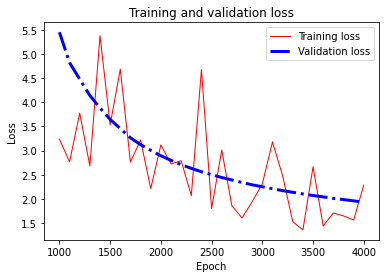

<Figure size 432x288 with 0 Axes>

Final Training loss: 2.2863631, Final Validation loss: 1.9337528, Training RMSE: 1.3829771, Validation RMSE: 1.3905944
-------------------------------------------------------------------------------------


Fold 3, lr: 5e-05, batch_size: 64, number_epochs: 4000, type_loss_func: MSE, type_optimizer: GradientDescent, neural_network_structure: multilayer_perceptron1
Epoch: 1000, Training loss: 6.058899, Validation loss: 7.2222643, 
Epoch: 2000, Training loss: 3.7325945, Validation loss: 3.7195904, 
Epoch: 3000, Training loss: 1.9096955, Validation loss: 2.7487655, 
Epoch: 4000, Training loss: 3.037657, Validation loss: 2.3125548, 
The total training time is: 14.114745000000312


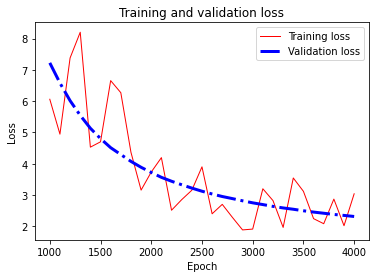

<Figure size 432x288 with 0 Axes>

Final Training loss: 3.037657, Final Validation loss: 2.3125548, Training RMSE: 1.5443053, Validation RMSE: 1.5207087
-------------------------------------------------------------------------------------


Fold 4, lr: 5e-05, batch_size: 64, number_epochs: 4000, type_loss_func: MSE, type_optimizer: GradientDescent, neural_network_structure: multilayer_perceptron1
Epoch: 1000, Training loss: 5.8492584, Validation loss: 7.8032565, 
Epoch: 2000, Training loss: 3.3408287, Validation loss: 3.2845492, 
Epoch: 3000, Training loss: 2.6258693, Validation loss: 2.355972, 
Epoch: 4000, Training loss: 1.6304253, Validation loss: 1.972357, 
The total training time is: 13.87001999999984


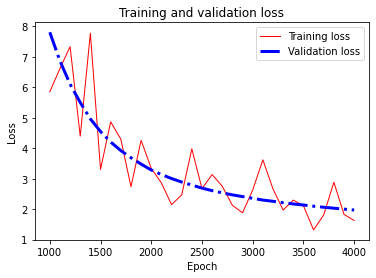

<Figure size 432x288 with 0 Axes>

Final Training loss: 1.6304253, Final Validation loss: 1.972357, Training RMSE: 1.4433279, Validation RMSE: 1.4044063
-------------------------------------------------------------------------------------


Fold 5, lr: 5e-05, batch_size: 64, number_epochs: 4000, type_loss_func: MSE, type_optimizer: GradientDescent, neural_network_structure: multilayer_perceptron1
Epoch: 1000, Training loss: 7.9203644, Validation loss: 8.794383, 
Epoch: 2000, Training loss: 3.0178409, Validation loss: 3.9781952, 
Epoch: 3000, Training loss: 3.0620837, Validation loss: 2.807247, 
Epoch: 4000, Training loss: 2.6643448, Validation loss: 2.3167925, 
The total training time is: 13.997033999999985


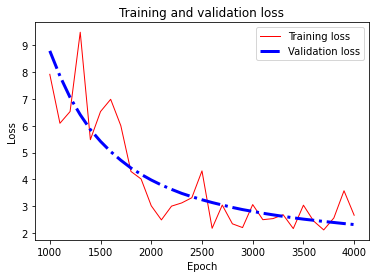

<Figure size 432x288 with 0 Axes>

Final Training loss: 2.6643448, Final Validation loss: 2.3167925, Training RMSE: 1.5359101, Validation RMSE: 1.5221013
-------------------------------------------------------------------------------------


Fold 6, lr: 5e-05, batch_size: 64, number_epochs: 4000, type_loss_func: MSE, type_optimizer: GradientDescent, neural_network_structure: multilayer_perceptron1
Epoch: 1000, Training loss: 5.738884, Validation loss: 7.327283, 
Epoch: 2000, Training loss: 2.6915402, Validation loss: 4.0710125, 
Epoch: 3000, Training loss: 1.8479189, Validation loss: 2.9973009, 
Epoch: 4000, Training loss: 2.5741868, Validation loss: 2.4265797, 
The total training time is: 14.079356000000189


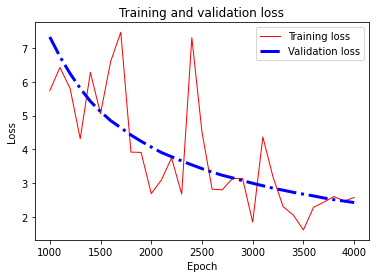

<Figure size 432x288 with 0 Axes>

Final Training loss: 2.5741868, Final Validation loss: 2.4265797, Training RMSE: 1.5096065, Validation RMSE: 1.5577483
-------------------------------------------------------------------------------------


Fold 7, lr: 5e-05, batch_size: 64, number_epochs: 4000, type_loss_func: MSE, type_optimizer: GradientDescent, neural_network_structure: multilayer_perceptron1
Epoch: 1000, Training loss: 16.396872, Validation loss: 13.6358595, 
Epoch: 2000, Training loss: 3.112996, Validation loss: 4.3117504, 
Epoch: 3000, Training loss: 3.323666, Validation loss: 3.0134676, 
Epoch: 4000, Training loss: 3.2235122, Validation loss: 2.575641, 
The total training time is: 14.135709000000134


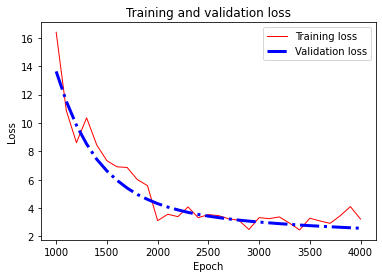

<Figure size 432x288 with 0 Axes>

Final Training loss: 3.2235122, Final Validation loss: 2.575641, Training RMSE: 1.6229075, Validation RMSE: 1.6048803
-------------------------------------------------------------------------------------


Fold 8, lr: 5e-05, batch_size: 64, number_epochs: 4000, type_loss_func: MSE, type_optimizer: GradientDescent, neural_network_structure: multilayer_perceptron1
Epoch: 1000, Training loss: 6.326126, Validation loss: 6.8067427, 
Epoch: 2000, Training loss: 3.3909125, Validation loss: 4.225547, 
Epoch: 3000, Training loss: 3.0441241, Validation loss: 3.2190113, 
Epoch: 4000, Training loss: 3.669962, Validation loss: 2.66557, 
The total training time is: 14.219061000000238


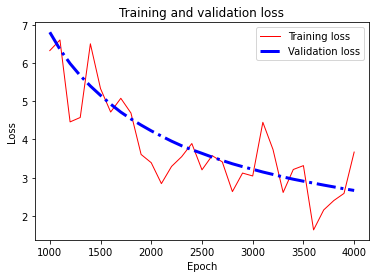

<Figure size 432x288 with 0 Axes>

Final Training loss: 3.669962, Final Validation loss: 2.66557, Training RMSE: 1.6201601, Validation RMSE: 1.6326574
-------------------------------------------------------------------------------------




KeyboardInterrupt: ignored

In [4]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=10)

train_x = []
test_x = []
train_y = []
test_y = []

select_epoch_from = 1000
batch_iteration = 0

train_loss = 0
val_loss = 0

# record the train losses for the total 10 fold models
kfold_train_losses = []
# record the validate losses for the total 10 fold models
kfold_val_losses = []

hyperParameters = {'lr':[0.001,0.003,0.005,0.007],'batch_size':[64,128,256],'number_epochs':[7000,9000,11000,13000,15000],'type_loss_func':["MSE","MAE"，"MSLE"],'type_optimizer':["GradientDescent","RMSProp","Momentum","Adam"],'neural_network_structure':["multilayer_perceptron1","multilayer_perceptron2","multilayer_perceptron3"]}

rmses = []
bset_lr = 0
best_batchsize = 0
best_number_epochs = 0
best_loss_func = ""
best_type_optimizer = ""
best_neural_network_structure = ""
best_training_rmse = 0
best_validation_rmse = 0

with tf.Session() as sess: 
    for lr in hyperParameters['lr']:
        for batch_size in hyperParameters['batch_size']:
            for number_epochs in hyperParameters['number_epochs']:
                for type_loss_func in hyperParameters['type_loss_func']:
                    for type_optimizer in hyperParameters['type_optimizer']:
                        for neural_network_structure in hyperParameters['neural_network_structure']:
                            fold = 0
                            for train_index, val_index in kf.split(X_train, y_train):
                                if neural_network_structure == "multilayer_perceptron1":
                                   neural_network = multilayer_perceptron1(X_p)
                                elif neural_network_structure == "multilayer_perceptron2":
                                     neural_network = multilayer_perceptron2(X_p)
                                elif neural_network_structure == "multilayer_perceptron3":
                                     neural_network = multilayer_perceptron3(X_p)
                                mse_1 = tf.keras.losses.MeanSquaredError()
                                RMSE_pre = mse_1(neural_network,Y_p)
                                eval_RMSE = tf.cast(tf.sqrt(RMSE_pre),dtype=tf.float32)
                                if type_loss_func == "MSE":
                                   mse = tf.keras.losses.MeanSquaredError()
                                   loss_func = mse(neural_network,Y_p)
                                elif type_loss_func == "MAE":
                                     mae = tf.keras.losses.MeanAbsoluteError()
                                     loss_func = mse(neural_network,Y_p)
                                elif type_loss_func == "MSLE":
                                     msle = tf.keras.losses.MeanSquaredLogarithmicError()()
                                     loss_func = msl(neural_network,Y_p)
                                # define optimizer
                                if type_optimizer == "GradientDescent":
                                   optimizer = tf.train.GradientDescentOptimizer(lr).minimize(loss_func)
                                elif type_optimizer == "RMSProp":
                                     optimizer = tf.train.RMSPropOptimizer(lr).minimize(loss_func)
                                elif type_optimizer == "Momentum":
                                     optimizer = tf.train.MomentumOptimize(lr).minimize(loss_func)
                                elif type_optimizer == "Adam":
                                     optimizer = tf.train.AdamOptimizer(lr).minimize(loss_func)
                                # initializaing variables
                                init = tf.global_variables_initializer()
                                sess.run(init)
                                start_time = time.clock() 
                                fold = fold + 1
                                train_x = X_train[train_index]
                                train_y = y_train[train_index]
                                val_x = X_train[val_index]
                                val_y = y_train[val_index]
                                batch_iteration = int(len(train_x) / batch_size) + 1
                
                                print("Fold %s, lr: %s, batch_size: %s, number_epochs: %s, type_loss_func: %s, type_optimizer: %s, neural_network_structure: %s" % (fold,lr,batch_size,number_epochs,type_loss_func,type_optimizer,neural_network_structure))
                
                                train_losses = []
                                val_losses = []
                                epochs = []
                                for epoch in range(1,number_epochs+1):
          
                                    n = epoch % batch_iteration
                                    s = 0 + batch_size * n
                                    if n == 0:
                                       e = len(train_x)
                                    else:
                                       e = batch_size + batch_size * n
                  
                                    batch_X = np.array(X_train[s:e])
                                    batch_y = np.array(y_train[s:e])

                                    _, train_loss = sess.run([optimizer, loss_func], feed_dict={X_p: batch_X, Y_p: batch_y})
                                    val_loss = loss_func.eval({X_p: val_x, Y_p: val_y})

                                    if epoch >= select_epoch_from and epoch % 100 == 0:
                                       train_losses.append(train_loss)
                                       val_losses.append(val_loss)
                                       epochs.append(epoch)

                                    #Display the epoch
                                    if epoch % 1000 == 0:
                                       print("Epoch: %d, "
                                            "Training loss: %s, "
                                            "Validation loss: %s, " % (epoch, train_loss, val_loss))
                
                                end_time = time.clock()
                                print("The total training time is: " + str(end_time-start_time))

                                pyplot.plot(epochs, train_losses, 'r', label='Training loss', linewidth=1, linestyle='-')
                                pyplot.plot(epochs, val_losses, 'b', label='Validation loss', linewidth=3, linestyle='-.')
                                pyplot.xlabel('Epoch') 
                                pyplot.ylabel('Loss')
                                pyplot.title('Training and validation loss')
                                pyplot.legend()
                                pyplot.figure()
                                pyplot.show()
                                pyplot.ioff()

                                kfold_train_RMSE = sess.run(eval_RMSE,feed_dict={X_p:train_x, Y_p:train_y})
                                kfold_val_RMSE = sess.run(eval_RMSE,feed_dict={X_p:val_x, Y_p:val_y})
                      
                                print("Final Training loss: %s, "
                                      "Final Validation loss: %s, " 
                                      "Training RMSE: %s, "
                                      "Validation RMSE: %s"% (train_loss, val_loss, kfold_train_RMSE, kfold_val_RMSE )) 
                                print("-------------------------------------------------------------------------------------\n\n")

                                kfold_train_losses.append(kfold_train_RMSE)
                                kfold_val_losses.append(kfold_val_RMSE)
  
                                if fold == 10:
                                  # average train RMSE for the 10 folds
                                   average_train_rmse_score_10fold = np.mean(kfold_train_losses)
                                   # average validate RMSE for the 10 folds
                                   average_val_rmse_score_10fold = np.mean(kfold_val_losses)
                                   print("For the model with learning rate: %s, batch size: %s, number_epochs: %s, type_optimizer: %s, neural_network_structure: %s \n" % (lr,batch_size,number_epochs,type_optimizer,neural_network_structure))
                                   print("Average Training RMSE for the 10 folds: %s \n" % str(average_train_rmse_score_10fold))
                                   print("Average Validation RMSE for the 10 folds: %s \n\n" % str(average_val_rmse_score_10fold))
                                   print("-------------------------------------------------------------------------------------\n\n")
                                   if lr == 0.00005 and batch_size == 64 and number_epochs == 2000 and type_loss_func == "MSE" and type_optimizer == "GradientDescent" and neural_network_structure == "multilayer_perceptron1":
                                   #best_training_rmse = average_train_rmse_score_10fold
                                      best_validation_rmse = average_val_rmse_score_10fold
                                      best_lr = 0.00005
                                      best_batchsize = 64
                                      best_number_epochs = 2000
                                      best_loss_func = "MSE"
                                      best_type_optimizer = "GradientDescent"
                                      best_neural_network_structure = "multilayer_perceptron1"
                                   else: 
                                        if average_val_rmse_score_10fold < best_validation_rmse:
                                        #best_training_rmse = average_train_rmse_score_10fold
                                           best_validation_rmse = average_val_rmse_score_10fold
                                           best_lr = lr
                                           best_batchsize = batch_size
                                           best_number_epochs = number_epochs
                                           best_loss_func = type_loss_func
                                           best_type_optimizer = type_optimizer
                                           best_neural_network_structure = neural_network_structure
    print("The best hyperparameters:\n") 
    print("learning rate: %s, batch size: %s, number_epochs: %s,type_loss_func: %s, type_optimizer: %s, neural_network_structure: %s, RMSE: %s\n" % (best_lr,best_batchsize,best_number_epochs,best_type_optimizer,best_neural_network_structure,best_validation_rmse))
    
    # Test model
    pred = (neural_network) 
    output=neural_network.eval({X_p: X_test}) 

    # plot prediction and labels
    pyplot.plot(y_test[0:500], 'ro', label='Testing labels')
    pyplot.plot(output[0:500], 'bo', label='Predictions')
    pyplot.xlabel('Instances') 
    pyplot.ylabel('Average_log(PM2.5 + 1)')
    pyplot.title('Partial Predictions and labels')
    pyplot.show()

    # final RMSE
    rmse_score = sess.run(eval_RMSE,feed_dict={X_p:X_test,Y_p:y_test})
    print("Average Test RMSE: " + str(rmse_score))
